In [1]:
#-------------------------------------------------------#
#IMPORT SCRIPTS#
#-------------------------------------------------------#
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import torch
import torch.nn as nn
from datetime import date
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from regularizationTrajectoryDataSets_Two_Parameters import *
from vectorNeuralNetArch import regularizationTrajNN
from makeSignals import myTrueModel, myTrueModel_2param
from calculateErrors import errorMethods as em

# ==============================================================================#

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
print('Is GPU available?', torch.cuda.is_available())

print('The current device is numbered as ', torch.cuda.current_device())
temp = torch.cuda.current_device()

print('The device is ', torch.cuda.device(temp))

print('The total number of devices is/are:', torch.cuda.device_count())

print('The device is named ', torch.cuda.get_device_name(temp))

Is GPU available? True
The current device is numbered as  0
The device is  <torch.cuda.device object at 0x7f2d784a0760>
The total number of devices is/are: 8
The device is named  Tesla V100-SXM2-32GB


In [3]:
maxvalSNR = 16
maxvalSNR2 = 6500

In [4]:
#-------------------------------------------------------#
#To Be Changed With What Neural Network You Wish to Make#
#-------------------------------------------------------#
#You MUST check everything marked with an (!)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#What data is being compared?
#REMINDER:  You most likley only wish to use MinMetric NNs

DATA_NAME_A = 'SNR900_lambdaneg1_NDNDvNDB_c1_is_03_'
DATA_NAME_B = 'SNR900_lambdaneg1_NDNDvNDB_c1_is_03_'
DATA_NAME_C = 'Week9_SNR10_lambdaneg2_NDNDvNDB_'
DATA_NAME_D = 'Week9_SNR10_lambdaneg3_NDNDvNDB_'
DATA_NAME_E = 'Week9_SNR10_lambdaneg4_NDNDvNDB_'

DATA_NAME_LIST = [DATA_NAME_A, DATA_NAME_B, DATA_NAME_C, DATA_NAME_D, DATA_NAME_E]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Description_A = '(ND, B) BIG'
Description_B = '(ND, ND)'
Description_C = 'N/A'
Description_D = 'N/A'
Description_E = 'N/A'
Description_List = [Description_A, Description_B, Description_C, Description_D, Description_E]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#What corresponding Neural Network will be compared?
NET_NAME_METHOD_A = DATA_NAME_A + 'NN_NDB_Big1'
NET_NAME_METHOD_B = DATA_NAME_B + 'NN_NDND'
NET_NAME_METHOD_C = DATA_NAME_C + 'NN_Week6'
NET_NAME_METHOD_D = DATA_NAME_D + 'NN_Week6'
NET_NAME_METHOD_E = DATA_NAME_E + 'NN_Week6'

NET_NAME_METHOD_LIST = [NET_NAME_METHOD_A, NET_NAME_METHOD_B, NET_NAME_METHOD_C, NET_NAME_METHOD_D, NET_NAME_METHOD_E]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# What were the decay inputs for these networks
decay_input_A = ['ND', 'B']
decay_input_B = ['ND', 'ND']
decay_input_C = ['ND', 'B']
decay_input_D = ['ND', 'B']
decay_input_E = ['ND', 'B']

decay_input_list = [decay_input_A, decay_input_B, decay_input_C, decay_input_D, decay_input_E]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#What is the SNR of the training and testing data?
SNR_A = 900
SNR_B = 900
SNR_C = 10000
SNR_D = 10000
SNR_E = 10000

SNR_LIST = [SNR_A, SNR_B, SNR_C, SNR_D, SNR_E]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Indicate which comparisons you would like to perform:
A_Comparison = True
B_Comparison = True
C_Comparison = False
D_Comparison = False
E_Comparison = False
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#What naming convention should resulting plots be based on?
PLOT_TEST_NAME = 'comparison_NDNDvsNDB_test'
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#What is the outlier tolerance?
TOL = 10000000000000000000000000000
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#What errors are you investigating?

ErrorType = ['PE', 'SE', 'LPE', 'LSE'] #Add Key for abreviations [@@@]

#What error do you want MinMetric model to train.
ErrorGraph = 'PE'

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [5]:
#-------------------------------------------------------#
#Assumed Data
#-------------------------------------------------------#
#The following will be assumed:

#All inputs are multiple decays
INPUT_TYPE_A = 'MultipleDecays'
INPUT_TYPE_B = 'MultipleDecays'
INPUT_TYPE_C = 'MultipleDecays'
INPUT_TYPE_D = 'MultipleDecays'
INPUT_TYPE_E = 'MultipleDecays'

INPUT_TYPE_LIST = [INPUT_TYPE_A, INPUT_TYPE_B, INPUT_TYPE_C, INPUT_TYPE_D, INPUT_TYPE_E]
#-----

H1, H2, H3, H4 = 32, 256, 256, 32  # dimensions of hidden layers (from Liu abst.)

#-----

# Number of Parameters (if num_params = 2 then params are (T21, T22) if num_params = 3 then params are (c1, T21, T22)
num_params = 2

if num_params == 2:
    c1 = 0.3
    c2 = 0.7
    
#-----

mySignalType = 'biexponential'

#-----
DATE = str(date.today())

#-----

error_name_list = ['Mean Percent Error', 'Mean Square Error', 'Percent Logarithmic Error', 'Square Logarithmic Error']

error_abv_list = ['$mpe$', '$mse$', '$mple$', '$msle$']

error_form_list = ['(Approximate - Exact)/Exact', '(Approximate - Exact)**2', '(log(Approximate) - log(Exact))/log(Exact)', '(log(Approximate) - log(Exact))**2']

#-----

# First and last measurement times of the signal
time_bounds = [0.0, 1.6 * 500.0]

#-----

# Duplications and Concatenations for each model
num_copies_A = 1
num_copies_B = 1
num_copies_C = 1
num_copies_D = 1
num_copies_E = 1

num_copies_list = [num_copies_A, num_copies_B, num_copies_C, num_copies_D, num_copies_E]
#-----

# For figures:  include NLLS performance in plots? If True, this will likely cause poor...
# ...axes scaling for ill-posed problems (even with outliers masked)
INCLUDE_NLLS = True

#-----

FIG_DIR_A = './_results/_figs/_snr' + str(SNR_A) + '/'

#-----

FIG_PATH = FIG_DIR_A + '_' + DATE + '_' + PLOT_TEST_NAME

#-----

# Check to see if directories used for saving exist. If they don't, make them.
if not os.path.exists(FIG_PATH): os.mkdir(FIG_PATH)
FIG_PATH += '/'

In [6]:
#-------------------------------------------------------#
# Some Directory/File Management
#-------------------------------------------------------#

# Paths to the saved data to load
DATA_DIR_A = './_results/_dataSets/_snr' + str(SNR_A) + '/'
DATA_DIR_B = './_results/_dataSets/_snr' + str(SNR_B) + '/'
DATA_DIR_C = './_results/_dataSets/_snr' + str(SNR_C) + '/'
DATA_DIR_D = './_results/_dataSets/_snr' + str(SNR_D) + '/'
DATA_DIR_E = './_results/_dataSets/_snr' + str(SNR_E) + '/'

TESTING_DATA_PATH_A = DATA_DIR_A + DATA_NAME_A + 'TestingData.csv'
TESTING_DATA_PATH_B = DATA_DIR_B + DATA_NAME_B + 'TestingData.csv'
TESTING_DATA_PATH_C = DATA_DIR_C + DATA_NAME_C + 'TestingData.csv'
TESTING_DATA_PATH_D = DATA_DIR_D + DATA_NAME_D + 'TestingData.csv'
TESTING_DATA_PATH_E = DATA_DIR_E + DATA_NAME_E + 'TestingData.csv'

TESTING_DATA_PATH_LIST = [TESTING_DATA_PATH_A, TESTING_DATA_PATH_B, TESTING_DATA_PATH_C, TESTING_DATA_PATH_D, TESTING_DATA_PATH_E]


# Paths to the save file of the neural net parameters you'd like to load
NET_DIR_A = './_results/_trainedNNs/_snr' + str(SNR_A) + '/'
NET_DIR_B = './_results/_trainedNNs/_snr' + str(SNR_B) + '/'
NET_DIR_C = './_results/_trainedNNs/_snr' + str(SNR_C) + '/'
NET_DIR_D = './_results/_trainedNNs/_snr' + str(SNR_D) + '/'
NET_DIR_E = './_results/_trainedNNs/_snr' + str(SNR_D) + '/'

NET_DIR_LIST = [NET_DIR_A, NET_DIR_B, NET_DIR_C, NET_DIR_D, NET_DIR_E]

NET_PATH_METHOD_A = NET_DIR_A + NET_NAME_METHOD_A
NET_PATH_METHOD_B = NET_DIR_B + NET_NAME_METHOD_B
NET_PATH_METHOD_C = NET_DIR_C + NET_NAME_METHOD_C
NET_PATH_METHOD_D = NET_DIR_D + NET_NAME_METHOD_D
NET_PATH_METHOD_E = NET_DIR_E + NET_NAME_METHOD_E

NET_PATH_METHOD_LIST = [NET_PATH_METHOD_A, NET_PATH_METHOD_B, NET_PATH_METHOD_C, NET_PATH_METHOD_D, NET_PATH_METHOD_E]

In [7]:
#-------------------------------------------------------#
# Track Comparisons
#-------------------------------------------------------#
first_Methods_list = ['A', 'B', 'C', 'D', 'E']
Compare_List = []

for element in DATA_NAME_LIST:
    if A_Comparison == True:
        if 0 not in Compare_List:
            Compare_List.append(0)
    if B_Comparison == True:
        if 1 not in Compare_List:
            Compare_List.append(1)
    if C_Comparison == True:
        if 2 not in Compare_List:
            Compare_List.append(2)
    if D_Comparison == True:
        if 3 not in Compare_List:
            Compare_List.append(3)
    if E_Comparison == True:
        if 4 not in Compare_List:
            Compare_List.append(4)

    
error_label_list = []

counter = 0
for Error in ErrorType:
    Error_Label = str(Error)
    
    if Error_Label == 'PE':
        PEnum = counter
    if Error_Label == 'SE':
        SEnum = counter
    if Error_Label == 'LPE':
        LPEnum = counter
    if Error_Label == 'LSE':
        LSEnum = counter
    
    counter = counter+1
    
    error_label_list.append(Error_Label)
    
print(Compare_List)

[0, 1]


In [8]:
#-------------------------------------------------------#
# Loading in Testing Data
#-------------------------------------------------------#
# A) Which features should be included in the input to the NN?
# -------------------------------------------------------------
#  -- The strings in the lists below are 'keys' in the DataFrames
#         that are stored at *_DATA_PATH.

method_dataset_list = []
num_times_list = []
ld_list = []

# What do you aim to have the NN predict?
if num_params == 2:
    target_names = ['T21_target', 'T22_target']
    particular_trajectories = ['T21_traj', 'T22_traj']
if num_params == 3:
    target_names = ['c1_target', 'T21_target', 'T22_target']
    particular_trajectories = ['c1_traj', 'T21_traj', 'T22_traj']

for place in  Compare_List:
    method_dataset = initDataSet(INPUT_TYPE_LIST[place], TESTING_DATA_PATH_LIST[place], target_names, time_bounds, trajectories=['T21_traj', 'T22_traj'], concat=num_copies_list[place], decay_input=decay_input_list[place])
    
    num_times = method_dataset.num_times
    ld = method_dataset.master_frame['reg_params'][0][0]
    #print(method_dataset[0])
    for Error in ErrorType:
        method_dataset_list.append(method_dataset)
        num_times_list.append(num_times)
        ld_list.append(ld)

[0.16]
1
[0.16]
1


In [9]:
NETLIST = []

for NET in NET_PATH_METHOD_LIST:
    for Error in ErrorType:
        #print(Error)
        NEWNET = NET+str('LSE')+'_minMetric.pth'
        NETLIST.append(NEWNET)

In [10]:
Compare_List

[0, 1]

In [11]:


#-------------------------------------------------------#
# Initialize Neural Net
#-------------------------------------------------------#
# A) Define NN layer widths
# --------------------------
methodNet_list = []
methodloader_list = []
NeuralNetList = []

inx = 0
Multiplier = 0
MethodLoop = len(ErrorType)

for place in  Compare_List:
    print('COMP LOOP', place)
    method_in_dim = calcInDim(INPUT_TYPE_LIST[place], method_dataset_list[place], concat=num_copies_list[place], decay_input=decay_input_list[place])

    out_dim = len(target_names)  # number of parameters we're aiming to predict
    # B) Define NN hyperparameters
    # -----------------------------
    P = dict()
    P['N_test'] = len(method_dataset_list[place])  # num. samples in testing set

    # C) Initialize NNs
    # ------------------
    
    # D) Load trained NN parameters
    # ------------------------------
    
    if place == 0:
            #from vectorNeuralNetArchBIG import regularizationTrajNN
            
            H1, H2, H3, H4 = 128, 1024, 1024, 128  
            methodNet = regularizationTrajNN(method_in_dim,  # Input layer size
                                      H1, H2, H3, H4,  # Hidden layer sizes
                                      out_dim)  # Output layer size
    elif place == 1:
            from vectorNeuralNetArch import regularizationTrajNN

            H1, H2, H3, H4 = 32, 256, 256, 32
            methodNet = regularizationTrajNN(method_in_dim,  # Input layer size
                                      H1, H2, H3, H4,  # Hidden layer sizes
                                      out_dim)  # Output layer size
            
    print(methodNet)
    for Error in ErrorType:
        print('ERROR LOOP', Error)
        if Error == 'PE':
            num = PEnum
        if Error == 'SE':
            num = SEnum
        if Error == 'LPE':
            num = LPEnum    
        if Error == 'LSE':
            num = LSEnum
        inx = (Multiplier*MethodLoop)+num
        
        
        #methodNet_list.append(methodNet)
        
        '''
        if torch.cuda.is_available() == True:
                methodNet.load_state_dict(torch.load(NETLIST[inx]))

        else:
                methodNet.load_state_dict(torch.load(NETLIST[inx], map_location=torch.device('cpu')))
        '''
        methodNet.load_state_dict(torch.load(NETLIST[inx], map_location=torch.device('cpu')))
        
        print('--------------------------')
        #for name, param in methodNet.named_parameters():
        #    print('name: ', name)
        #    print(type(param))
        #    print('param.shape: ', param.shape)
        #    print('param.requires_grad: ', param.requires_grad)
        #    print('=====')
        
        thesumofweight_list = []
        for param in methodNet.parameters():
                tempparam = param.data
                #print('TEMPPARAM', type(tempparam))
                thesumofweight_list.append(torch.sum(torch.square(tempparam)))
        thesumofweight = np.sqrt(np.sum(thesumofweight_list))
        print(first_Methods_list[place], Error, 'This models summed weights are', thesumofweight)
        
        NeuralNetList.append(methodNet)
        
        method_loader = DataLoader(method_dataset_list[inx], batch_size=P['N_test'])
        
        #print(method_loader)
        methodloader_list.append(method_loader)
    Multiplier = Multiplier+1

#print(len(NeuralNetList))
#print(len(methodloader_list))

COMP LOOP 0
regularizationTrajNN(
  (inputMap): Linear(in_features=128, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=1024, bias=True)
  (hidden2): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden3): Linear(in_features=1024, out_features=128, bias=True)
  (outputMap): Linear(in_features=128, out_features=2, bias=True)
)
ERROR LOOP PE
--------------------------
A PE This models summed weights are 55.239338
ERROR LOOP SE
--------------------------
A SE This models summed weights are 55.239338
ERROR LOOP LPE
--------------------------
A LPE This models summed weights are 55.239338
ERROR LOOP LSE
--------------------------
A LSE This models summed weights are 55.239338
COMP LOOP 1
regularizationTrajNN(
  (inputMap): Linear(in_features=128, out_features=32, bias=True)
  (hidden1): Linear(in_features=32, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_featu

In [12]:
#-------------------------------------------------------#
# Start Testing
#-------------------------------------------------------#
masked_params_nlls_list = []
masked_params_rnlls_list = []
masked_params_test_list = []
masked_noisy_decays_list = []
masked_error_nlls_list = []
masked_error_rnlls_list = []
masked_trajectory_list = []

predicted_T21_means_nlls_list = []
predicted_T21_stdevs_nlls_list = []
T21_error_means_nlls_list = []
T21_error_stdevs_nlls_list = []
twoT21_error_means_nlls_list = []
twoT21_error_stdevs_nlls_list = []

predicted_T22_means_nlls_list = []
predicted_T22_stdevs_nlls_list = []
T22_error_means_nlls_list = []
T22_error_stdevs_nlls_list = []

twoT22_error_means_nlls_list = []
twoT22_error_stdevs_nlls_list = []


predicted_T21_means_rnlls_list = []
predicted_T21_stdevs_rnlls_list = []
T21_error_means_rnlls_list = []
T21_error_stdevs_rnlls_list = []
twoT21_error_means_rnlls_list = []
twoT21_error_stdevs_rnlls_list = []

predicted_T22_means_rnlls_list = []
predicted_T22_stdevs_rnlls_list = []
T22_error_means_rnlls_list = []
T22_error_stdevs_rnlls_list = []

twoT22_error_means_rnlls_list = []
twoT22_error_stdevs_rnlls_list = []


predicted_c1_means_nlls_list = []
predicted_c1_stdevs_nlls_list = []
predicted_c1_means_rnlls_list = []
predicted_c1_stdevs_rnlls_list = []

c1_error_means_nlls_list = []
c1_error_stdevs_nlls_list = []
c1_error_means_rnlls_list = []
c1_error_stdevs_rnlls_list = []

predicted_c2_means_nlls_list = []
predicted_c2_stdevs_nlls_list = []
predicted_c2_means_rnlls_list = []
predicted_c2_stdevs_rnlls_list = []

c2_error_means_nlls_list = []
c2_error_stdevs_nlls_list = []
c2_error_means_rnlls_list = []
c2_error_stdevs_rnlls_list = []

predicted_c1_stdevs_nlls_wp_list = []
c1_error_means_nlls_wp_list = []
c1_error_stdevs_nlls_wp_list = []
                    
predicted_c1_stdevs_rnlls_wp_list = []
c1_error_means_rnlls_wp_list = []
c1_error_stdevs_rnlls_wp_list = []
                    
c2_perc_error_means_nlls_wp_list = []
c2_perc_error_stdevs_nlls_wp_list = []
                    
c2_perc_error_means_rnlls_wp_list = []
c2_perc_error_stdevs_rnlls_wp_list = []
                    
predicted_T21_stdevs_nlls_wp_list = []
T21_error_means_nlls_wp_list = []
T21_error_stdevs_nlls_wp_list = []
twoT21_error_means_nlls_wp_list = []
twoT21_error_stdevs_nlls_wp_list = []
                
predicted_T21_stdevs_rnlls_wp_list = []
T21_error_means_rnlls_wp_list = []
T21_error_stdevs_rnlls_wp_list = []
twoT21_error_means_rnlls_wp_list = []
twoT21_error_stdevs_rnlls_wp_list = []
                
predicted_T22_stdevs_nlls_wp_list = []
T22_error_means_nlls_wp_list = []
T22_error_stdevs_nlls_wp_list = []
twoT22_error_means_nlls_wp_list = []
twoT22_error_stdevs_nlls_wp_list = []
                
predicted_T22_stdevs_rnlls_wp_list = []
T22_error_means_rnlls_wp_list = []
T22_error_stdevs_rnlls_wp_list = []
twoT22_error_means_rnlls_wp_list = []
twoT22_error_stdevs_rnlls_wp_list = []


# - - -

unique_c1_targets_list = []
predicted_c1_means_ma_list = []
predicted_c1_stdevs_ma_list = []
c1_error_means_ma_list = []
c1_error_stdevs_ma_list = []
                
c2_error_means_ma_list = []
c2_error_stdevs_ma_list = []
                
unique_well_posedness_ratios_list = []
predicted_c1_stdevs_ma_wp_list = []
c1_error_means_ma_wp_list = []
c1_error_stdevs_ma_wp_list = []
                
c2_error_means_ma_wp_list = []
c2_error_stdevs_ma_wp_list = []
                
predicted_c1_means_ma_xy_list = []
predicted_c1_stdevs_ma_xy_list = []
c1_error_means_ma_xy_list = []
c1_error_stdevs_ma_xy_list = []
                
c2_error_means_ma_xy_list = []
c2_error_stdevs_ma_xy_list = []

# - - -

unique_T21_targets_list = []
predicted_T21_means_ma_list = []
predicted_T21_stdevs_ma_list = []
T21_error_means_ma_list = []
T21_error_stdevs_ma_list = []
twoT21_error_means_ma_list = []
twoT21_error_stdevs_ma_list = []
                
unique_T22_targets_list = []
predicted_T22_means_ma_list = []
predicted_T22_stdevs_ma_list = []
T22_error_means_ma_list = []
T22_error_stdevs_ma_list = []
twoT22_error_means_ma_list = []
twoT22_error_stdevs_ma_list = []
                
predicted_T21_stdevs_ma_wp_list = []
T21_error_means_ma_wp_list = []
T21_error_stdevs_ma_wp_list = []
twoT21_error_means_ma_wp_list = []
twoT21_error_stdevs_ma_wp_list = []
            
predicted_T22_stdevs_ma_wp_list = []
T22_error_means_ma_wp_list = []
T22_error_stdevs_ma_wp_list = []
twoT22_error_means_ma_wp_list = []
twoT22_error_stdevs_ma_wp_list = []
            
predicted_T21_means_ma_xy_list = []
predicted_T21_stdevs_ma_xy_list = []
T21_error_means_ma_xy_list = []
T21_error_stdevs_ma_xy_list = []
twoT21_error_means_ma_xy_list = []
twoT21_error_stdevs_ma_xy_list = []
        
predicted_T22_means_ma_xy_list = []
predicted_T22_stdevs_ma_xy_list = []
T22_error_means_ma_xy_list = []
T22_error_stdevs_ma_xy_list = []
twoT22_error_means_ma_xy_list = []
twoT22_error_stdevs_ma_xy_list = []

twoT21_error_means_nlls_xy_list = []
twoT22_error_means_nlls_xy_list = []
twoT21_error_stdevs_nlls_xy_list = []
twoT22_error_stdevs_nlls_xy_list = []

abs_error_ma_list = []
abs_error_nlls_list = []
abs_error_rnlls_list = []

sum_error_ma_list = []
sum_error_nlls_list = []
sum_error_rnlls_list = []

mean_T21_abs_error_nlls_list = []
mean_T22_abs_error_nlls_list = []
mean_T21_error_nlls_list = []
mean_T22_error_nlls_list = []
mean_c1_abs_error_nlls_list = []
mean_c2_error_nlls_list = []

mean_T21_abs_error_rnlls_list = []
mean_T22_abs_error_rnlls_list = []
mean_T21_error_rnlls_list = []
mean_T22_error_rnlls_list = []
mean_c1_abs_error_rnlls_list = []
mean_c2_error_rnlls_list = []
               
mean_T21_abs_error_ma_list = []
mean_c1_abs_error_ma_list = []
mean_T22_abs_error_ma_list = []

mean_c2_error_stdev_ma_list = []
mean_T21_error_ma_list = []
mean_T22_error_ma_list = []
mean_sum_error_ma_list = []

predicted_T21_stdevs_nlls_xy_list = []
predicted_T21_stdevs_ma_xy_list = []

predicted_T21_means_nlls_xy_list = []
predicted_T22_means_nlls_xy_list = []
predicted_T21_stdevs_nlls_xy_list = []
predicted_T22_stdevs_nlls_xy_list = []

params_ma_list = []

discard_list = []

inx = 0

Multiplier = 0
with torch.no_grad():  # indicates to auto_grad not to update computational graph
    # Test regularized decay input NN
    for place in Compare_List:
        if place == 0:
            newplace = place
        else:
            newplace = 5*place-1
        
        print('This is Method', first_Methods_list[place], ' or ', NET_NAME_METHOD_LIST[place])
        #print('place', place)
        print('################### --> methodloader_list', methodloader_list[newplace])
        
        #print('newplace', newplace)
        for trajectory, params_test in methodloader_list[newplace]:

            
            for Error in ErrorType:
                if Error == 'PE':
                    num = PEnum
                if Error == 'SE':
                    num = SEnum
                if Error == 'LPE':
                    num = LPEnum    
                if Error == 'LSE':
                    num = LSEnum
                    
                MethodLoop = len(ErrorType)
                #print('Multiplier', Multiplier)
                #print('MethodLoop', MethodLoop)
                #print('num', num)
                
                #print('Multiplier*MethodLoop + num')
                
                inx = (Multiplier*MethodLoop)+num
                
                print('\n\n----  Starting Testing  ----')
                print(f'    -- Number of tests is: {P["N_test"]}')

                ##---------------------------------##
                ##    Evaluate NLLS performance    ##
                ##---------------------------------##
                print('    -- Evaluating NLLS performance...')
                ## A) Initialize
                params_nlls = torch.zeros((P['N_test'], out_dim), dtype=torch.float64)
                params_rnlls = torch.zeros((P['N_test'], out_dim), dtype=torch.float64)
                noisy_decays = torch.zeros((P['N_test'], num_times), dtype=torch.float64)
                for sample in range(P['N_test']):
                    noisy_decays[sample, :] = method_dataset_list[place].master_frame['noisy_decay'][sample]
                if num_params == 2:
                    params_nlls[:, 0] = torch.Tensor(method_dataset_list[place].master_frame['T21_nlls'])
                    params_nlls[:, 1] = torch.Tensor(method_dataset_list[place].master_frame['T22_nlls'])
                    params_rnlls[:, 0] = torch.DoubleTensor(method_dataset_list[place].master_frame['T21_traj'])
                    params_rnlls[:, 1] = torch.DoubleTensor(method_dataset_list[place].master_frame['T22_traj'])
                if num_params == 3:
                    params_nlls[:, 0] = torch.Tensor(method_dataset_list[place].master_frame['c1_nlls'])
                    params_nlls[:, 1] = torch.Tensor(method_dataset_list[place].master_frame['T21_nlls'])
                    params_nlls[:, 2] = torch.Tensor(method_dataset_list[place].master_frame['T22_nlls'])
                    params_rnlls[:, 0] = torch.Tensor(method_dataset_list[place].master_frame['c1_traj'])
                    params_rnlls[:, 1] = torch.Tensor(method_dataset_list[place].master_frame['T21_traj'])
                    params_rnlls[:, 2] = torch.Tensor(method_dataset_list[place].master_frame['T22_traj'])
        
        
                # B) Calculate absolute error
                abs_error_nlls = torch.abs(params_nlls - params_test)
                abs_error_rnlls = torch.abs(params_rnlls - params_test)
                log_abs_error_nlls = torch.abs(torch.log(params_nlls) - torch.log(params_test))
                log_abs_error_rnlls = torch.abs(torch.log(params_rnlls) - torch.log(params_test))
                
                abs_error_nlls_list.append(abs_error_nlls)
                abs_error_rnlls_list.append(abs_error_rnlls)
                

                # C) Calculate errors.
                #      Note, **calculate error in c2 since it's bounded away from 0
                nlls_perc_error_denom = params_test.clone()
                rnlls_perc_error_denom = params_test.clone()


                if Error == 'PE':
                    num = PEnum
                    error_nlls = 100.0*abs_error_nlls/nlls_perc_error_denom
                    error_rnlls = 100.0*abs_error_rnlls/rnlls_perc_error_denom
                if Error == 'SE':
                    num = SEnum
                    error_nlls = (params_nlls - params_test)**2
                    error_rnlls = (params_rnlls - params_test)**2
                if Error == 'LPE':
                    num = LPEnum
                    error_nlls = 100.0*torch.log(abs_error_nlls)/torch.log(nlls_perc_error_denom)
                    error_rnlls = 100.0*log_abs_error_rnlls/torch.log(rnlls_perc_error_denom)
                if Error == 'LSE':
                    num = LSEnum
                    error_nlls = (torch.log(params_nlls) - torch.log(params_test))**2
                    error_rnlls = (torch.log(params_rnlls) - torch.log(params_test))**2

                #print(Error)
                # D) Discard all samples that contain outliers. A parameter estimate is an...
                #      ...outlier if it is less than Q1 - 1.5*IQR or greater than Q3 + 1.5*IQR
                # mask based on T21 errors



                if num_params ==2:
                    #===== ===== =====
                    #     MASK 1
                    #===== ===== =====
                    # mask baed on T21 errors
                    mask1 = em.mask_outliers(error_nlls[:, 0], TOL)

                    params_nlls_m1 = params_nlls[mask1, :]
                    params_rnlls_m1 = params_rnlls[mask1, :]
                    params_test_m1 = params_test[mask1, :]
                    noisy_decays_m1 = noisy_decays[mask1, :]
                    error_nlls_m1 = error_nlls[mask1, :]
                    error_rnlls_m1 = error_rnlls[mask1, :]
                    trajectory_m1 = trajectory[mask1, :]

                    #===== ===== =====
                    #     MASK 2
                    #===== ===== =====
                    # mask basd on T22 errors
                    mask2 = em.mask_outliers(error_nlls_m1[:, 1], TOL)

                    masked_params_nlls = params_nlls_m1[mask2, :]
                    masked_params_rnlls = params_rnlls_m1[mask2, :]
                    masked_params_test = params_test_m1[mask2, :]
                    masked_noisy_decays = noisy_decays_m1[mask2, :]
                    masked_error_nlls = error_nlls_m1[mask2, :]
                    masked_error_rnlls = error_rnlls_m1[mask2, :]
                    masked_trajectory = trajectory_m1[mask2, :]

                    masked_params_nlls_list.append(masked_params_nlls)
                    masked_params_rnlls_list.append(masked_params_rnlls)
                    masked_params_test_list.append(masked_params_test)
                    masked_noisy_decays_list.append(masked_noisy_decays)
                    masked_error_nlls_list.append(masked_error_nlls)
                    masked_error_rnlls_list.append(masked_error_rnlls)
                    masked_trajectory_list.append(masked_trajectory)

                if num_params == 3:
                    #===== ===== =====
                    #     MASK 1
                    #===== ===== =====
                    # mask baed on c2 errors
                    mask1 = em.mask_outliers(error_nlls[:, 0], TOL)

                    params_nlls_m1 = params_nlls[mask1, :]
                    params_rnlls_m1 = params_rnlls[mask1, :]
                    params_test_m1 = params_test[mask1, :]
                    noisy_decays_m1 = noisy_decays[mask1, :]
                    error_nlls_m1 = error_nlls[mask1, :]
                    error_rnlls_m1 = error_rnlls[mask1, :]
                    trajectory_m1 = trajectory[mask1, :]

                    #===== ===== =====
                    #     MASK 2
                    #===== ===== =====
                    mask2 = em.mask_outliers(error_nlls_m1[:, 1], TOL)

                    params_nlls_m2 = params_nlls_m1[mask2, :]
                    params_rnlls_m2 = params_rnlls_m1[mask2, :]
                    params_test_m2 = params_test_m1[mask2, :]
                    noisy_decays_m2 = noisy_decays_m1[mask2, :]
                    error_nlls_m2 = error_nlls_m1[mask2, :]
                    error_rnlls_m2 = error_rnlls_m1[mask2, :]
                    trajectory_m2 = trajectory_m1[mask2, :]

                    #===== ===== =====
                    #     MASK 3
                    #===== ===== =====
                    # mask basd on T22 errors
                    mask3 = em.mask_outliers(error_nlls_m2[:, 2], TOL)

                    masked_params_nlls = params_nlls_m2[mask3, :]
                    masked_params_rnlls = params_rnlls_m2[mask3, :]
                    masked_params_test = params_test_m2[mask3, :]
                    masked_noisy_decays = noisy_decays_m2[mask3, :]
                    masked_error_nlls = error_nlls_m2[mask3, :]
                    masked_error_rnlls = error_rnlls_m2[mask3, :]
                    masked_trajectory = trajectory_m2[mask3, :]

                    masked_params_nlls_list.append(masked_params_nlls)
                    masked_params_rnlls_list.append(masked_params_rnlls)
                    masked_params_test_list.append(masked_params_test)
                    masked_noisy_decays_list.append(masked_noisy_decays)
                    masked_error_nlls_list.append(masked_error_nlls)
                    masked_error_rnlls_list.append(masked_error_rnlls)
                    masked_trajectory_list.append(masked_trajectory)

                print(f' --> Discarded {P["N_test"] - len(masked_params_nlls[:, 0])}' +f' of {P["N_test"]} samples')
                discard = P["N_test"] - len(masked_params_nlls[:, 0])
                discard_list.append(discard)

                abs_error_nlls = torch.abs(masked_params_nlls - masked_params_test)
                mean_abs_error_nlls = torch.mean(abs_error_nlls, dim=0)

                abs_error_rnlls = torch.abs(masked_params_rnlls - masked_params_test)
                mean_abs_error_rnlls = torch.mean(abs_error_rnlls, dim=0)

                if num_params == 2:
                    mean_T21_abs_error_nlls, mean_T22_abs_error_nlls = mean_abs_error_nlls
                    mean_T21_error_nlls, mean_T22_error_nlls = torch.mean(masked_error_nlls, dim=0)

                    mean_T21_abs_error_rnlls, mean_T22_abs_error_rnlls = mean_abs_error_rnlls
                    mean_T21_error_rnlls, mean_T22_error_rnlls = torch.mean(masked_error_rnlls, dim=0)
                    
                if num_params == 3:
                    mean_c1_abs_error_nlls, mean_T21_abs_error_nlls, mean_T22_abs_error_nlls = mean_abs_error_nlls
                    mean_c1_abs_error_rnlls, mean_T21_abs_error_rnlls, mean_T22_abs_error_rnlls = mean_abs_error_rnlls

                    mean_c2_error_nlls, mean_T21_error_nlls, mean_T22_error_nlls = torch.mean(masked_error_nlls, dim=0)
                    mean_c2_error_rnlls, mean_T21_error_rnlls, mean_T22_error_rnlls = torch.mean(masked_error_rnlls, dim=0)
                    
                    mean_c1_abs_error_nlls_list.append(mean_c1_abs_error_nlls)
                    mean_c2_error_nlls_list.append(mean_c2_error_nlls)
                    mean_c1_abs_error_rnlls_list.append(mean_c1_abs_error_rnlls)
                    mean_c2_error_rnlls_list.append(mean_c2_error_rnlls)
                
                
                mean_T21_abs_error_nlls_list.append(mean_T21_abs_error_nlls)
                mean_T22_abs_error_nlls_list.append(mean_T22_abs_error_nlls)
                mean_T21_error_nlls_list.append(mean_T21_error_nlls)
                mean_T22_error_nlls_list.append(mean_T22_error_nlls)
                
                
                mean_T21_abs_error_rnlls_list.append(mean_T21_abs_error_rnlls)
                mean_T22_abs_error_rnlls_list.append(mean_T22_abs_error_rnlls)
                mean_T21_error_rnlls_list.append(mean_T21_error_rnlls)
                mean_T22_error_rnlls_list.append(mean_T22_error_rnlls)
                
                
                # sum of errors over parameters
                sum_error_nlls = torch.sum(masked_error_nlls, dim=1)
                sum_error_rnlls = torch.sum(masked_error_rnlls, dim=1)
                
                sum_error_nlls_list.append(sum_error_nlls)
                sum_error_rnlls_list.append(sum_error_rnlls)

                # average over samples
                mean_sum_error_nlls = torch.mean(sum_error_nlls, dim=0)
                mean_sum_error_rnlls = torch.mean(sum_error_rnlls, dim=0)

                if num_params == 2:
                    #
                    #     NLLS!
                    #

                    if Error == 'PE':
                        (_, predicted_T21_means_nlls, 
                         predicted_T21_stdevs_nlls, 
                         T21_error_means_nlls, 
                         T21_error_stdevs_nlls, 
                         twoT21_error_means_nlls, 
                         twoT21_error_stdevs_nlls) = em.PE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_nlls[:,0])
                        (_, predicted_T22_means_nlls, 
                         predicted_T22_stdevs_nlls, 
                         T22_error_means_nlls, 
                         T22_error_stdevs_nlls, 
                         twoT22_error_means_nlls, 
                         twoT22_error_stdevs_nlls) = em.PE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_nlls[:,1])
                    if Error == 'SE':
                        (_, predicted_T21_means_nlls, 
                         predicted_T21_stdevs_nlls, 
                         T21_error_means_nlls, 
                         T21_error_stdevs_nlls, 
                         twoT21_error_means_nlls, 
                         twoT21_error_stdevs_nlls) = em.SE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_nlls[:,0])
                        (_, predicted_T22_means_nlls, 
                         predicted_T22_stdevs_nlls, 
                         T22_error_means_nlls, 
                         T22_error_stdevs_nlls, 
                         twoT22_error_means_nlls, 
                         twoT22_error_stdevs_nlls) = em.SE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_nlls[:,1])
                    if Error == 'LPE':
                        (_, predicted_T21_means_nlls, 
                         predicted_T21_stdevs_nlls, 
                         T21_error_means_nlls, 
                         T21_error_stdevs_nlls, 
                         twoT21_error_means_nlls, 
                         twoT21_error_stdevs_nlls) = em.LPE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_nlls[:,0])
                        (_, predicted_T22_means_nlls, 
                         predicted_T22_stdevs_nlls, 
                         T22_error_means_nlls, 
                         T22_error_stdevs_nlls, 
                         twoT22_error_means_nlls, 
                         twoT22_error_stdevs_nlls) = em.LPE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_nlls[:,1])
                    if Error == 'LSE':
                        (_, predicted_T21_means_nlls, 
                         predicted_T21_stdevs_nlls, 
                         T21_error_means_nlls, 
                         T21_error_stdevs_nlls, 
                         twoT21_error_means_nlls, 
                         twoT21_error_stdevs_nlls) = em.LSE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_nlls[:,0])
                        (_, predicted_T22_means_nlls, 
                         predicted_T22_stdevs_nlls, 
                         T22_error_means_nlls, 
                         T22_error_stdevs_nlls, 
                         twoT22_error_means_nlls, 
                         twoT22_error_stdevs_nlls) = em.LSE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_nlls[:,1])
                    #
                    #     RNLLS!
                    #

                    if Error == 'PE':
                        (_, predicted_T21_means_rnlls, 
                         predicted_T21_stdevs_rnlls, 
                         T21_error_means_rnlls, 
                         T21_error_stdevs_rnlls, 
                         twoT21_error_means_rnlls, 
                         twoT21_error_stdevs_rnlls) = em.PE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_rnlls[:,0])
                        (_, predicted_T22_means_rnlls, 
                         predicted_T22_stdevs_rnlls, 
                         T22_error_means_rnlls, 
                         T22_error_stdevs_rnlls, 
                         twoT22_error_means_rnlls, 
                         twoT22_error_stdevs_rnlls) = em.PE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_rnlls[:,1])
                    if Error == 'SE':
                        (_, predicted_T21_means_rnlls, 
                         predicted_T21_stdevs_rnlls, 
                         T21_error_means_rnlls, 
                         T21_error_stdevs_rnlls, 
                         twoT21_error_means_rnlls, 
                         twoT21_error_stdevs_rnlls) = em.SE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_rnlls[:,0])
                        (_, predicted_T22_means_rnlls, 
                         predicted_T22_stdevs_rnlls, 
                         T22_error_means_rnlls, 
                         T22_error_stdevs_rnlls, 
                         twoT22_error_means_rnlls, 
                         twoT22_error_stdevs_rnlls) = em.SE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_rnlls[:,1])
                    if Error == 'LPE':
                        (_, predicted_T21_means_rnlls, 
                         predicted_T21_stdevs_rnlls, 
                         T21_error_means_rnlls, 
                         T21_error_stdevs_rnlls, 
                         twoT21_error_means_rnlls, 
                         twoT21_error_stdevs_rnlls) = em.LPE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_rnlls[:,0])
                        (_, predicted_T22_means_rnlls, 
                         predicted_T22_stdevs_rnlls, 
                         T22_error_means_rnlls, 
                         T22_error_stdevs_rnlls, 
                         twoT22_error_means_rnlls, 
                         twoT22_error_stdevs_rnlls) = em.LPE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_rnlls[:,1])
                    if Error == 'LSE':
                        (_, predicted_T21_means_rnlls, 
                         predicted_T21_stdevs_rnlls, 
                         T21_error_means_rnlls, 
                         T21_error_stdevs_rnlls, 
                         twoT21_error_means_rnlls, 
                         twoT21_error_stdevs_rnlls) = em.LSE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,0], 
                                                                                    masked_params_rnlls[:,0])
                        (_, predicted_T22_means_rnlls, 
                         predicted_T22_stdevs_rnlls, 
                         T22_error_means_rnlls, 
                         T22_error_stdevs_rnlls, 
                         twoT22_error_means_rnlls, 
                         twoT22_error_stdevs_rnlls) = em.LSE_prediction_averages_stdevs(em, 
                                                                                    masked_params_test[:,1], 
                                                                                    masked_params_rnlls[:,1])
                if num_params == 3:
                    if Error == 'PE':
                        (_, predicted_c1_means_nlls, predicted_c1_stdevs_nlls,
                         c1_error_means_nlls, c1_error_stdevs_nlls,
                         _, _) = em.PE_prediction_averages_stdevs(em, masked_params_test[:, 0], masked_params_nlls[:, 0])
                        (_, predicted_c1_means_rnlls, predicted_c1_stdevs_rnlls,
                         c1_error_means_rnlls, c1_error_stdevs_rnlls,
                         _, _) = em.PE_prediction_averages_stdevs(em, masked_params_test[:, 0], masked_params_rnlls[:, 0])
                        (_, _, _,
                         _, _,
                         twoc2_error_means_nlls, twoc2_error_stdevs_nlls) = em.PE_prediction_averages_stdevs(em,
                                                                                                              1.0 - masked_params_test[
                                                                                                                    :, 0],
                                                                                                              1.0 - masked_params_nlls[
                                                                                                                    :, 0])
                        (_, _, _,
                         _, _,
                         twoc2_error_means_rnlls, twoc2_error_stdevs_rnlls) = em.PE_prediction_averages_stdevs(em,
                                                                                                                1.0 - masked_params_test[
                                                                                                                      :, 0],
                                                                                                                1.0 - masked_params_rnlls[
                                                                                                                      :, 0])

                        (_, predicted_T21_means_nlls, predicted_T21_stdevs_nlls,
                         T21_error_means_nlls, T21_error_stdevs_nlls,
                         twoT21_error_means_nlls, twoT21_error_stdevs_nlls) = em.PE_prediction_averages_stdevs(em,
                                                                                                                masked_params_test[
                                                                                                                :, 1],
                                                                                                                masked_params_nlls[
                                                                                                                :, 1])
                        (_, predicted_T21_means_rnlls, predicted_T21_stdevs_rnlls,
                         T21_error_means_rnlls, T21_error_stdevs_rnlls,
                         twoT21_error_means_rnlls, twoT21_error_stdevs_rnlls) = em.PE_prediction_averages_stdevs(em,
                                                                                                                  masked_params_test[
                                                                                                                  :, 1],
                                                                                                                  masked_params_rnlls[
                                                                                                                  :, 1])

                        (_, predicted_T22_means_nlls, predicted_T22_stdevs_nlls,
                         T22_error_means_nlls, T22_error_stdevs_nlls,
                         twoT22_error_means_nlls, twoT22_error_stdevs_nlls) = em.PE_prediction_averages_stdevs(em,
                                                                                                                masked_params_test[
                                                                                                                :, 2],
                                                                                                                masked_params_nlls[
                                                                                                                :, 2])
                        (_, predicted_T22_means_rnlls, predicted_T22_stdevs_rnlls,
                         T22_error_means_rnlls, T22_error_stdevs_rnlls,
                         twoT22_error_means_rnlls, twoT22_error_stdevs_rnlls) = em.PE_prediction_averages_stdevs(em,
                                                                                                                  masked_params_test[
                                                                                                                  :, 2],
                                                                                                                  masked_params_rnlls[
                                                                                                                  :, 2])
                    if Error == 'SE':
                        (_, predicted_c1_means_nlls, predicted_c1_stdevs_nlls,c1_error_means_nlls, c1_error_stdevs_nlls, _, _) = em.SE_prediction_averages_stdevs(
                            em, masked_params_test[:, 0], masked_params_nlls[:, 0])
                        (_, predicted_c1_means_rnlls, predicted_c1_stdevs_rnlls,c1_error_means_rnlls, c1_error_stdevs_rnlls,_, _) = em.SE_prediction_averages_stdevs(
                            em, masked_params_test[:, 0], masked_params_rnlls[:, 0])
                        (_, _, _,_, _,twoc2_error_means_nlls, twoc2_error_stdevs_nlls) = em.SE_prediction_averages_stdevs(
                            em, 1.0 - masked_params_test[:, 0],1.0 - masked_params_nlls[:, 0])
                        (_, _, _, _, _, twoc2_error_means_rnlls, twoc2_error_stdevs_rnlls) = em.SE_prediction_averages_stdevs(
                            em, 1.0 - masked_params_test[:, 0], 1.0 - masked_params_rnlls[:, 0])

                        (_, predicted_T21_means_nlls, predicted_T21_stdevs_nlls,T21_error_means_nlls, T21_error_stdevs_nlls,twoT21_error_means_nlls, twoT21_error_stdevs_nlls) = em.SE_prediction_averages_stdevs(
                            em, masked_params_test[ :, 1],masked_params_nlls[ :, 1])
                        (_, predicted_T21_means_rnlls, predicted_T21_stdevs_rnlls, T21_error_means_rnlls, T21_error_stdevs_rnlls,twoT21_error_means_rnlls, twoT21_error_stdevs_rnlls) = em.SE_prediction_averages_stdevs(
                            em,masked_params_test[:, 1], masked_params_rnlls[:, 1])

                        (_, predicted_T22_means_nlls, predicted_T22_stdevs_nlls,T22_error_means_nlls, T22_error_stdevs_nlls,twoT22_error_means_nlls, twoT22_error_stdevs_nlls) = em.SE_prediction_averages_stdevs(
                            em, masked_params_test[ :, 2], masked_params_nlls[:, 2])
                        (_, predicted_T22_means_rnlls, predicted_T22_stdevs_rnlls,T22_error_means_rnlls, T22_error_stdevs_rnlls, twoT22_error_means_rnlls, twoT22_error_stdevs_rnlls) = em.SE_prediction_averages_stdevs(
                            em, masked_params_test[:, 2],masked_params_rnlls[:, 2])
                        
                    if Error == 'LPE':
                        (_, predicted_c1_means_nlls, predicted_c1_stdevs_nlls,
                         c1_error_means_nlls, c1_error_stdevs_nlls,_, _) = em.LPE_prediction_averages_stdevs(em, masked_params_test[:, 0], masked_params_nlls[:, 0])
                        (_, predicted_c1_means_rnlls, predicted_c1_stdevs_rnlls,c1_error_means_rnlls, c1_error_stdevs_rnlls,
                         _, _) = em.LPE_prediction_averages_stdevs(em, masked_params_test[:, 0], masked_params_rnlls[:, 0])
                        (_, _, _,
                         _, _,
                         twoc2_error_means_nlls, twoc2_error_stdevs_nlls) = em.LPE_prediction_averages_stdevs(em,
                                                                                                              1.0 - masked_params_test[
                                                                                                                    :, 0],
                                                                                                              1.0 - masked_params_nlls[
                                                                                                                    :, 0])
                        (_, _, _,
                         _, _,
                         twoc2_error_means_rnlls, twoc2_error_stdevs_rnlls) = em.LPE_prediction_averages_stdevs(em,
                                                                                                                1.0 - masked_params_test[
                                                                                                                      :, 0],
                                                                                                                1.0 - masked_params_rnlls[
                                                                                                                      :, 0])

                        (_, predicted_T21_means_nlls, predicted_T21_stdevs_nlls,
                         T21_error_means_nlls, T21_error_stdevs_nlls,
                         twoT21_error_means_nlls, twoT21_error_stdevs_nlls) = em.LPE_prediction_averages_stdevs(em,
                                                                                                                masked_params_test[
                                                                                                                :, 1],
                                                                                                                masked_params_nlls[
                                                                                                                :, 1])
                        (_, predicted_T21_means_rnlls, predicted_T21_stdevs_rnlls,
                         T21_error_means_rnlls, T21_error_stdevs_rnlls,
                         twoT21_error_means_rnlls, twoT21_error_stdevs_rnlls) = em.LPE_prediction_averages_stdevs(em,
                                                                                                                  masked_params_test[
                                                                                                                  :, 1],
                                                                                                                  masked_params_rnlls[
                                                                                                                  :, 1])

                        (_, predicted_T22_means_nlls, predicted_T22_stdevs_nlls,
                         T22_error_means_nlls, T22_error_stdevs_nlls,
                         twoT22_error_means_nlls, twoT22_error_stdevs_nlls) = em.LPE_prediction_averages_stdevs(em,
                                                                                                                masked_params_test[
                                                                                                                :, 2],
                                                                                                                masked_params_nlls[
                                                                                                                :, 2])
                        (_, predicted_T22_means_rnlls, predicted_T22_stdevs_rnlls,
                         T22_error_means_rnlls, T22_error_stdevs_rnlls,
                         twoT22_error_means_rnlls, twoT22_error_stdevs_rnlls) = em.LPE_prediction_averages_stdevs(em,
                                                                                                                  masked_params_test[
                                                                                                                  :, 2],
                                                                                                                  masked_params_rnlls[
                                                                                                                  :, 2])
                    if Error == 'LSE':
                        (_, predicted_c1_means_nlls, predicted_c1_stdevs_nlls,
                         c1_error_means_nlls, c1_error_stdevs_nlls,
                         _, _) = em.LSE_prediction_averages_stdevs(em, masked_params_test[:, 0], masked_params_nlls[:, 0])
                        (_, predicted_c1_means_rnlls, predicted_c1_stdevs_rnlls,
                         c1_error_means_rnlls, c1_error_stdevs_rnlls,
                         _, _) = em.LSE_prediction_averages_stdevs(em, masked_params_test[:, 0], masked_params_rnlls[:, 0])

                        (_, _, _,
                         _, _,
                         twoc2_error_means_nlls, twoc2_error_stdevs_nlls) = em.LSE_prediction_averages_stdevs(em,
                                                                                                              1.0 - masked_params_test[
                                                                                                                    :, 0],
                                                                                                              1.0 - masked_params_nlls[
                                                                                                                    :, 0])
                        (_, _, _,
                         _, _,
                         twoc2_error_means_rnlls, twoc2_error_stdevs_rnlls) = em.LSE_prediction_averages_stdevs(em,
                                                                                                                1.0 - masked_params_test[
                                                                                                                      :, 0],
                                                                                                                1.0 - masked_params_rnlls[
                                                                                                                      :, 0])

                        (_, predicted_T21_means_nlls, predicted_T21_stdevs_nlls,
                         T21_error_means_nlls, T21_error_stdevs_nlls,
                         twoT21_error_means_nlls, twoT21_error_stdevs_nlls) = em.LSE_prediction_averages_stdevs(em,
                                                                                                                masked_params_test[
                                                                                                                :, 1],
                                                                                                                masked_params_nlls[
                                                                                                                :, 1])
                        (_, predicted_T21_means_rnlls, predicted_T21_stdevs_rnlls,
                         T21_error_means_rnlls, T21_error_stdevs_rnlls,
                         twoT21_error_means_rnlls, twoT21_error_stdevs_rnlls) = em.LSE_prediction_averages_stdevs(em,
                                                                                                                  masked_params_test[
                                                                                                                  :, 1],
                                                                                                                  masked_params_rnlls[
                                                                                                                  :, 1])

                        (_, predicted_T22_means_nlls, predicted_T22_stdevs_nlls,
                         T22_error_means_nlls, T22_error_stdevs_nlls,
                         twoT22_error_means_nlls, twoT22_error_stdevs_nlls) = em.LSE_prediction_averages_stdevs(em,
                                                                                                                masked_params_test[
                                                                                                                :, 2],
                                                                                                                masked_params_nlls[
                                                                                                                :, 2])
                        (_, predicted_T22_means_rnlls, predicted_T22_stdevs_rnlls,
                         T22_error_means_rnlls, T22_error_stdevs_rnlls,
                         twoT22_error_means_rnlls, twoT22_error_stdevs_rnlls) = em.LSE_prediction_averages_stdevs(em,
                                                                                                                  masked_params_test[
                                                                                                                  :, 2],
                                                                                                                  masked_params_rnlls[
                                                                                                                  :, 2])

                #----------------------------
                # SAVING COLLECTED PARAMETERS
                #----------------------------

                predicted_T21_means_nlls_list.append(predicted_T21_means_nlls)
                predicted_T21_stdevs_nlls_list.append(predicted_T21_stdevs_nlls)
                T21_error_means_nlls_list.append(T21_error_means_nlls)
                T21_error_stdevs_nlls_list.append(T21_error_stdevs_nlls)
                twoT21_error_means_nlls_list.append(twoT21_error_means_nlls)
                twoT21_error_stdevs_nlls_list.append(twoT21_error_stdevs_nlls)

                predicted_T22_means_nlls_list.append(predicted_T22_means_nlls)
                predicted_T22_stdevs_nlls_list.append(predicted_T22_stdevs_nlls)
                T22_error_means_nlls_list.append(T22_error_means_nlls)
                T22_error_stdevs_nlls_list.append(T22_error_stdevs_nlls)

                twoT22_error_means_nlls_list.append(twoT22_error_means_nlls)
                twoT22_error_stdevs_nlls_list.append(twoT22_error_stdevs_nlls)



                predicted_T21_means_rnlls_list.append(predicted_T21_means_rnlls)
                predicted_T21_stdevs_rnlls_list.append(predicted_T21_stdevs_rnlls)
                T21_error_means_rnlls_list.append(T21_error_means_rnlls)
                T21_error_stdevs_rnlls_list.append(T21_error_stdevs_rnlls)
                twoT21_error_means_rnlls_list.append(twoT21_error_means_rnlls)
                twoT21_error_stdevs_rnlls_list.append(twoT21_error_stdevs_rnlls)

                predicted_T22_means_rnlls_list.append(predicted_T22_means_rnlls)
                predicted_T22_stdevs_rnlls_list.append(predicted_T22_stdevs_rnlls)
                T22_error_means_rnlls_list.append(T22_error_means_rnlls)
                T22_error_stdevs_rnlls_list.append(T22_error_stdevs_rnlls)

                twoT22_error_means_rnlls_list.append(twoT22_error_means_rnlls)
                twoT22_error_stdevs_rnlls_list.append(twoT22_error_stdevs_rnlls)

                if num_params ==3:

                    predicted_c1_means_nlls_list.append(predicted_c1_means_nlls) 
                    predicted_c1_stdevs_nlls_list.append(predicted_c1_stdevs_nlls)
                    predicted_c1_means_rnlls_list.append(predicted_c1_means_rnlls) 
                    predicted_c1_stdevs_rnlls_list.append(predicted_c1_stdevs_rnlls) 

                    c1_error_means_nlls_list.append(c1_error_means_nlls) 
                    c1_error_stdevs_nlls_list.append(c1_error_stdevs_nlls)
                    c1_error_means_rnlls_list.append(c1_error_means_rnlls) 
                    c1_error_stdevs_rnlls_list.append(c1_error_stdevs_rnlls)

                    predicted_c2_means_nlls_list.append(predicted_c2_means_nlls) 
                    predicted_c2_stdevs_nlls_list.append(predicted_c2_stdevs_nlls)
                    predicted_c2_means_rnlls_list.append(predicted_c2_means_rnlls) 
                    predicted_c2_stdevs_rnlls_list.append(predicted_c2_stdevs_rnlls) 

                    c2_error_means_nlls_list.append(c2_error_means_nlls) 
                    c2_error_stdevs_nlls_list.append(c2_error_stdevs_nlls)
                    c2_error_means_rnlls_list.append(c2_error_means_rnlls) 
                    c2_error_stdevs_rnlls_list.append(c2_error_stdevs_rnlls)

                # B.5) Errors as a function of well-posedness
                if num_params == 2:
                    (_, predicted_T21_stdevs_nlls_wp,T21_error_means_nlls_wp, T21_error_stdevs_nlls_wp,twoT21_error_means_nlls_wp, twoT21_error_stdevs_nlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 0],masked_params_test[:, 1],masked_params_test[:, 0],masked_params_nlls[:, 0], Error)
                    
                    (_, predicted_T22_stdevs_nlls_wp,T22_error_means_nlls_wp, T22_error_stdevs_nlls_wp,twoT22_error_means_nlls_wp, twoT22_error_stdevs_nlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 0],masked_params_test[:, 1],masked_params_test[:, 1],masked_params_nlls[:, 1], Error)
                    
                    (_, predicted_T21_stdevs_rnlls_wp,T21_error_means_rnlls_wp, T21_error_stdevs_rnlls_wp,twoT21_error_means_rnlls_wp, twoT21_error_stdevs_rnlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 0],masked_params_test[:, 1],masked_params_test[:, 0],masked_params_rnlls[:, 0], Error)
                    
                    (_, predicted_T22_stdevs_rnlls_wp,T22_error_means_rnlls_wp, T22_error_stdevs_rnlls_wp,twoT22_error_means_rnlls_wp, twoT22_error_stdevs_rnlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 0],masked_params_test[:, 1],masked_params_test[:, 1],masked_params_rnlls[:, 1], Error)
                
                if num_params == 3:
                    (_, predicted_c1_stdevs_nlls_wp, c1_error_means_nlls_wp, c1_error_stdevs_nlls_wp, _, _) = em.performance_vs_wellposedness(em,
                                                     masked_params_test[:, 1], masked_params_test[:, 2], masked_params_test[:, 0], masked_params_nlls[:, 0], Error)
                    (_, predicted_c1_stdevs_rnlls_wp,c1_error_means_rnlls_wp, c1_error_stdevs_rnlls_wp,_, _) = em.performance_vs_wellposedness(em,
                                                     masked_params_test[:, 1], masked_params_test[:, 2], masked_params_test[:, 0], masked_params_rnlls[:, 0], Error)
                    
                    (_, _, _, _,c2_perc_error_means_nlls_wp, c2_perc_error_stdevs_nlls_wp) = em.performance_vs_wellposedness(em,
                        masked_params_test[:, 1], masked_params_test[:, 2],1.0 - masked_params_test[:, 0], 1.0 - masked_params_nlls[:, 0], Error)
                    (_, _, _, _,c2_perc_error_means_rnlls_wp, c2_perc_error_stdevs_rnlls_wp) = em.performance_vs_wellposedness(em,
                        masked_params_test[:, 1],masked_params_test[:, 2],1.0 - masked_params_test[ :, 0],1.0 - masked_params_rnlls[:, 0], Error)
                    
                    (_, predicted_T21_stdevs_nlls_wp,T21_error_means_nlls_wp, T21_error_stdevs_nlls_wp,twoT21_error_means_nlls_wp, twoT21_error_stdevs_nlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 1],masked_params_test[:, 2],masked_params_test[:, 1],masked_params_nlls[:, 1], Error)
                    
                    (_, predicted_T22_stdevs_nlls_wp,T22_error_means_nlls_wp, T22_error_stdevs_nlls_wp,twoT22_error_means_nlls_wp, twoT22_error_stdevs_nlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 1],masked_params_test[:, 2],masked_params_test[:, 2],masked_params_nlls[:, 2], Error)
                    
                    (_, predicted_T21_stdevs_rnlls_wp,T21_error_means_rnlls_wp, T21_error_stdevs_rnlls_wp,twoT21_error_means_rnlls_wp, twoT21_error_stdevs_rnlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 1],masked_params_test[:, 2],masked_params_test[:, 1],masked_params_rnlls[:, 1], Error)
                    
                    (_, predicted_T22_stdevs_rnlls_wp,T22_error_means_rnlls_wp, T22_error_stdevs_rnlls_wp,twoT22_error_means_rnlls_wp, twoT22_error_stdevs_rnlls_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 1],masked_params_test[:, 2],masked_params_test[:, 2],masked_params_rnlls[:, 2], Error)
                
                    
                    predicted_c1_stdevs_nlls_wp_list.append(predicted_c1_stdevs_nlls_wp)
                    c1_error_means_nlls_wp_list.append(c1_error_means_nlls_wp)
                    c1_error_stdevs_nlls_wp_list.append(c1_error_stdevs_nlls_wp)
                    
                    predicted_c1_stdevs_rnlls_wp_list.append(predicted_c1_stdevs_rnlls_wp)
                    c1_error_means_rnlls_wp_list.append(c1_error_means_rnlls_wp)
                    c1_error_stdevs_rnlls_wp_list.append(c1_error_stdevs_rnlls_wp)
                    
                    c2_perc_error_means_nlls_wp_list.append(c2_perc_error_means_nlls_wp)
                    c2_perc_error_stdevs_nlls_wp_list.append(c2_perc_error_stdevs_nlls_wp)
                    
                    c2_perc_error_means_rnlls_wp_list.append(c2_perc_error_means_rnlls_wp)
                    c2_perc_error_stdevs_rnlls_wp_list.append(c2_perc_error_stdevs_rnlls_wp)
                    
                predicted_T21_stdevs_nlls_wp_list.append(predicted_T21_stdevs_nlls_wp)
                T21_error_means_nlls_wp_list.append(T21_error_means_nlls_wp)
                T21_error_stdevs_nlls_wp_list.append(T21_error_stdevs_nlls_wp)
                twoT21_error_means_nlls_wp_list.append(twoT21_error_means_nlls_wp)
                twoT21_error_stdevs_nlls_wp_list.append(twoT21_error_stdevs_nlls_wp)
                
                predicted_T21_stdevs_rnlls_wp_list.append(predicted_T21_stdevs_rnlls_wp)
                T21_error_means_rnlls_wp_list.append(T21_error_means_rnlls_wp)
                T21_error_stdevs_rnlls_wp_list.append(T21_error_stdevs_rnlls_wp)
                twoT21_error_means_rnlls_wp_list.append(twoT21_error_means_rnlls_wp)
                twoT21_error_stdevs_rnlls_wp_list.append(twoT21_error_stdevs_rnlls_wp)
                
                predicted_T22_stdevs_nlls_wp_list.append(predicted_T22_stdevs_nlls_wp)
                T22_error_means_nlls_wp_list.append(T22_error_means_nlls_wp)
                T22_error_stdevs_nlls_wp_list.append(T22_error_stdevs_nlls_wp)
                twoT22_error_means_nlls_wp_list.append(twoT22_error_means_nlls_wp)
                twoT22_error_stdevs_nlls_wp_list.append(twoT22_error_stdevs_nlls_wp)
                
                predicted_T22_stdevs_rnlls_wp_list.append(predicted_T22_stdevs_rnlls_wp)
                T22_error_means_rnlls_wp_list.append(T22_error_means_rnlls_wp)
                T22_error_stdevs_rnlls_wp_list.append(T22_error_stdevs_rnlls_wp)
                twoT22_error_means_rnlls_wp_list.append(twoT22_error_means_rnlls_wp)
                twoT22_error_stdevs_rnlls_wp_list.append(twoT22_error_stdevs_rnlls_wp)
            
                ##----------------------------##
                ##    Test the Method NN    ##
                ##----------------------------##
                # A) Obtain predicted parameter values from NN
                params_ma = 0
                
                #print('------------------------------------------------------------------------------------')
                #print('params_ma', params_ma)
                #print('NeuralNetList[inx]', NeuralNetList[inx])
                #print('masked_trajectory_list[inx]', masked_trajectory_list[inx])
                #print('inx', inx)
                #print('------------------------------------------------------------------------------------')
                print(inx)
                params_ma = NeuralNetList[inx](masked_trajectory.float())
                
                params_full = NeuralNetList[inx](trajectory.float())
                
                #print('{{{{{{{{{{{{{{{{{{{{{{{{{{}}}}}}}}}}}}}}}}}}}}}}}}}}')
                #print('params_ma', params_ma)
                #print('masked_params_test', masked_params_test)
                #print('{{{{{{{{{{{{{{{{{{{{{{{{{{}}}}}}}}}}}}}}}}}}}}}}}}}}')

                #print('-------!!!!---------')
                #print(methodNet_list[inx])
                #print('-------!!!!---------')
                
                params_ma_list.append(params_ma)

                # B) Calculate error statistics
                # absolute error for each parameter in each sample
                
                abs_error_ma = torch.abs(params_ma - masked_params_test)
                
                abs_error_ma_list.append(abs_error_ma)
                
                ma_perc_error_denom = masked_params_test.clone()

                # percent error for each parameter in each sample.
                # Note, uses c2 instead of c1 since it's bounded away from zero
                if Error == 'PE':
                    num = PEnum
                    error_ma = 100.0*abs_error_ma/ma_perc_error_denom
                if Error == 'SE':
                    num = SEnum
                    error_ma = (params_ma - masked_params_test)**2
                if Error == 'LPE':
                    num = LPEnum
                    error_ma = 100.0*torch.log(abs_error_ma)/torch.log(ma_perc_error_denom)
                if Error == 'LSE':
                    num = LSEnum
                    error_ma = (torch.log(params_ma) - torch.log(masked_params_test))**2

                # sum of percent errors over parameters
                sum_error_ma = torch.sum(error_ma, dim=1)
                
                sum_error_ma_list.append(sum_error_ma)

                # test-averaged absolute error for each parameter
                mean_abs_error_ma, abs_error_stdev_ma = em.sample_averaged_abs_error_stdev(masked_params_test, params_ma)
                if num_params == 2:
                    mean_T21_abs_error_ma, mean_T22_abs_error_ma = mean_abs_error_ma
                if num_params == 3:
                    mean_c1_abs_error_ma, mean_T21_abs_error_ma, mean_T22_abs_error_ma = mean_abs_error_ma
                    mean_c1_abs_error_ma_list.append(mean_c1_abs_error_ma)
                mean_T21_abs_error_ma_list.append(mean_T21_abs_error_ma)
                mean_T22_abs_error_ma_list.append(mean_T22_abs_error_ma)
                
                # test-averaged relative error for each parameter (uses c2 instead of c1)
                mean_error_ma, perc_stdev_ma = em.sample_averaged_error_stdev(masked_params_test, params_ma, Error)

                if num_params == 2:
                    mean_T21_error_ma, mean_T22_error_ma = mean_error_ma
                if num_params == 3:
                    _, mean_T21_error_ma, mean_T22_error_ma = mean_error_ma
                    mean_c2_error_ma, c2_error_stdev_ma = em.sample_averaged_error_stdev(
                        1.0 - masked_params_test[:, 0], 1.0 - params_ma[:, 0], Error)

                # mean sum of percent errors. Neural net performance metric
                if num_params == 2:
                    mean_sum_error_ma = mean_T21_error_ma + mean_T22_error_ma
                if num_params == 3:
                    mean_sum_error_ma = mean_c2_error_ma + mean_T21_error_ma + mean_T22_error_ma
                    
                    mean_c2_error_ma_list.append(mean_c2_error_ma)
                    mean_c2_error_stdev_ma_list.append(mean_c2_error_stdev_ma)
                
                #print('############### -->  mean_T21_error_ma :', mean_T21_error_ma)
                #print(inx)
                #print('mean_T21_error_ma', mean_T21_error_ma)
                mean_T21_error_ma_list.append(mean_T21_error_ma)
                mean_T22_error_ma_list.append(mean_T22_error_ma)
                mean_sum_error_ma_list.append(mean_sum_error_ma)
                
                # Error as a function of target
                if num_params == 2:
                    (unique_T21_targets, predicted_T21_means_ma, predicted_T21_stdevs_ma, T21_error_means_ma, T21_error_stdevs_ma, twoT21_error_means_ma, twoT21_error_stdevs_ma) = em.prediction_averages_stdevs(
                        em, masked_params_test[:,0], params_ma[:, 0], Error)

                    (unique_T22_targets, predicted_T22_means_ma, predicted_T22_stdevs_ma,T22_error_means_ma, T22_error_stdevs_ma, twoT22_error_means_ma, twoT22_error_stdevs_ma) = em.prediction_averages_stdevs(
                        em,masked_params_test[:,1], params_ma[:, 1], Error)

                    (_, predicted_T21_stdevs_ma_wp, T21_error_means_ma_wp, T21_error_stdevs_ma_wp, twoT21_error_means_ma_wp, twoT21_error_stdevs_ma_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 0],masked_params_test[:, 1],masked_params_test[:, 0], params_ma[:, 0], Error)

                    (_, predicted_T22_stdevs_ma_wp, T22_error_means_ma_wp, T22_error_stdevs_ma_wp, twoT22_error_means_ma_wp, twoT22_error_stdevs_ma_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 0],masked_params_test[:, 1],masked_params_test[:, 1], params_ma[:, 1], Error)

                    (_, _, predicted_T21_means_ma_xy, predicted_T21_stdevs_ma_xy,T21_error_means_ma_xy, T21_error_stdevs_ma_xy, twoT21_error_means_ma_xy, twoT21_error_stdevs_ma_xy) = em.performance_vs_T2s(
                        em,  params_test[:, 0],params_test[:, 1], params_test[:, 0], params_full[:, 0], Error)

                    (_, _, predicted_T22_means_ma_xy, predicted_T22_stdevs_ma_xy,T22_error_means_ma_xy, T22_error_stdevs_ma_xy, twoT22_error_means_ma_xy, twoT22_error_stdevs_ma_xy) = em.performance_vs_T2s(
                        em,  params_test[:, 0],params_test[:, 1], params_test[:, 1], params_full[:, 1], Error)
                    
                    #.,.,.
                    (_, _, predicted_T21_means_nlls_xy, predicted_T21_stdevs_nlls_xy,T21_error_means_nlls_xy, T21_error_stdevs_nlls_xy, twoT21_error_means_nlls_xy, twoT21_error_stdevs_nlls_xy) = em.performance_vs_T2s(
                        em,  params_test[:, 0],params_test[:, 1], params_test[:, 0], params_nlls[:, 0], Error)

                    (_, _, predicted_T22_means_nlls_xy, predicted_T22_stdevs_nlls_xy,T22_error_means_nlls_xy, T22_error_stdevs_nlls_xy, twoT22_error_means_nlls_xy, twoT22_error_stdevs_nlls_xy) = em.performance_vs_T2s(
                        em,  params_test[:, 0],params_test[:, 1], params_test[:, 1], params_nlls[:, 1], Error)

                if num_params ==3:


                    (unique_c1_targets, predicted_c1_means_ma, predicted_c1_stdevs_ma,c1_error_means_ma, c1_error_stdevs_ma,_, _) = em.prediction_averages_stdevs(
                        em, masked_params_test[:, 0], params_ma[:, 0], Error)

                    (_, _, _, _, _,c2_error_means_ma, c2_error_stdevs_ma) = em.prediction_averages_stdevs(
                        em,1.0 - masked_params_test[:, 0], 1.0 - params_ma[:, 0], Error)

                    # - - - 

                    (unique_well_posedness_ratios, predicted_c1_stdevs_ma_wp, c1_error_means_ma_wp, c1_error_stdevs_ma_wp,_, _) = em.performance_vs_wellposedness(
                        em, masked_params_test[:, 1], masked_params_test[:, 2], masked_params_test[:, 0], params_ma[:, 0], Error)

                    (_, _,_, _, c2_error_means_ma_wp, c2_error_stdevs_ma_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 1],masked_params_test[:, 2],1.0 - masked_params_test[:, 0],  1.0 - params_ma[:,0], Error)

                    # - - - 

                    (_, _,predicted_c1_means_ma_xy, predicted_c1_stdevs_ma_xy,c1_error_means_ma_xy, c1_error_stdevs_ma_xy, _, _) = em.performance_vs_T2s(
                        em, masked_params_test[:, 1], masked_params_test[:, 2],masked_params_test[:, 0], params_ma[:, 0], Error)

                    (_, _, _, _, _, _,c2_error_means_ma_xy, c2_error_stdevs_ma_xy) = em.performance_vs_T2s(
                        em, masked_params_test[:, 1],  masked_params_test[:, 2], 1.0 - masked_params_test[:,0], 1.0 - params_ma[:, 0], Error)

                    #.,.,.
                    
                    (_, _,predicted_c1_means_nlls_xy, predicted_c1_stdevs_nlls_xy,c1_error_means_nlls_xy, c1_error_stdevs_nlls_xy, _, _) = em.performance_vs_T2s(
                        em, masked_params_test[:, 1], masked_params_test[:, 2],masked_params_test[:, 0], params_nlls[:, 0], Error)

                    (_, _, _, _, _, _,c2_error_means_nlls_xy, c2_error_stdevs_nlls_xy) = em.performance_vs_T2s(
                        em, masked_params_test[:, 1],  masked_params_test[:, 2], 1.0 - masked_params_test[:,0], 1.0 - params_nlls[:, 0], Error)


                    # - - - # - - - # - - -  #



                    (unique_T21_targets, predicted_T21_means_ma, predicted_T21_stdevs_ma, T21_error_means_ma, T21_error_stdevs_ma, twoT21_error_means_ma, twoT21_error_stdevs_ma) = em.prediction_averages_stdevs(
                        em, masked_params_test[:,1], params_ma[:, 1], Error)

                    (unique_T22_targets, predicted_T22_means_ma, predicted_T22_stdevs_ma,T22_error_means_ma, T22_error_stdevs_ma, twoT22_error_means_ma, twoT22_error_stdevs_ma) = em.prediction_averages_stdevs(
                        em,masked_params_test[:,2], params_ma[:, 2], Error)

                    # - - - 

                    (_, predicted_T21_stdevs_ma_wp, T21_error_means_ma_wp, T21_error_stdevs_ma_wp, twoT21_error_means_ma_wp, twoT21_error_stdevs_ma_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 1],masked_params_test[:, 2],masked_params_test[:, 1], params_ma[:, 1], Error)

                    (_, predicted_T22_stdevs_ma_wp, T22_error_means_ma_wp, T22_error_stdevs_ma_wp, twoT22_error_means_ma_wp, twoT22_error_stdevs_ma_wp) = em.performance_vs_wellposedness(
                        em,masked_params_test[:, 1],masked_params_test[:, 2],masked_params_test[:, 2], params_ma[:, 2], Error)

                    # - - - 

                    (_, _, predicted_T21_means_ma_xy, predicted_T21_stdevs_ma_xy,T21_error_means_ma_xy, T21_error_stdevs_ma_xy, twoT21_error_means_ma_xy, twoT21_error_stdevs_ma_xy) = em.performance_vs_T2s(
                        em,  masked_params_test[:, 1],masked_params_test[:, 2], masked_params_test[:, 1], params_ma[:, 1])

                    (_, _, predicted_T22_means_ma_xy, predicted_T22_stdevs_ma_xy,T22_error_means_ma_xy, T22_error_stdevs_ma_xy, twoT22_error_means_ma_xy, twoT22_error_stdevs_ma_xy) = em.performance_vs_T2s(
                        em,  masked_params_test[:, 1],masked_params_test[:, 2], masked_params_test[:, 2], params_ma[:, 2])

                    #.,.,.
                    (_, _, predicted_T21_means_nlls_xy, predicted_T21_stdevs_nlls_xy,T21_error_means_nlls_xy, T21_error_stdevs_nlls_xy, twoT21_error_means_nlls_xy, twoT21_error_stdevs_nlls_xy) = em.performance_vs_T2s(
                        em,  masked_params_test[:, 0],masked_params_test[:, 1], masked_params_test[:, 0], params_nlls[:, 0], Error)

                    (_, _, predicted_T22_means_nlls_xy, predicted_T22_stdevs_nlls_xy,T22_error_means_nlls_xy, T22_error_stdevs_nlls_xy, twoT22_error_means_nlls_xy, twoT22_error_stdevs_nlls_xy) = em.performance_vs_T2s(
                        em,  masked_params_test[:, 0],masked_params_test[:, 1], masked_params_test[:, 1], params_nlls[:, 1], Error)

                    unique_c1_targets_list.append(unique_c1_targets)
                    predicted_c1_means_ma_list.append(predicted_c1_means_ma)
                    predicted_c1_stdevs_ma_list.append(predicted_c1_stdevs_ma)
                    c1_error_means_ma_list.append(c1_error_means_ma)
                    c1_error_stdevs_ma_list.append(c1_error_stdevs_ma)

                    c2_error_means_ma_list.append(c2_error_means_ma)
                    c2_error_stdevs_ma_list.append(c2_error_stdevs_ma)

                    unique_well_posedness_ratios_list.append(unique_well_posedness_ratios)
                    predicted_c1_stdevs_ma_wp_list.append(predicted_c1_stdevs_ma_wp)
                    c1_error_means_ma_wp_list.append(c1_error_means_ma_wp)
                    c1_error_stdevs_ma_wp_list.append(c1_error_stdevs_ma_wp)

                    c2_error_means_ma_wp_list.append(c2_error_means_ma_wp)
                    c2_error_stdevs_ma_wp_list.append(c2_error_stdevs_ma_wp)

                    predicted_c1_means_ma_xy_list.append(predicted_c1_means_ma_xy)
                    predicted_c1_stdevs_ma_xy_list.append(predicted_c1_stdevs_ma_xy)
                    c1_error_means_ma_xy_list.append(c1_error_means_ma_xy)
                    c1_error_stdevs_ma_xy_list.append(c1_error_stdevs_ma_xy)

                    c2_error_means_ma_xy_list.append(c2_error_means_ma_xy)
                    c2_error_stdevs_ma_xy_list.append(c2_error_stdevs_ma_xy)

                
                
                
                #predicted_T21_stdevs_nlls_xy_list.append(predicted_T21_stdevs_nlls_xy)
                #predicted_T21_stdevs_ma_xy_list.append(predicted_T21_stdevs_ma_xy)
                
                unique_T21_targets_list.append(unique_T21_targets)
                predicted_T21_means_ma_list.append(predicted_T21_means_ma)
                predicted_T21_stdevs_ma_list.append(predicted_T21_stdevs_ma)
                T21_error_means_ma_list.append(T21_error_means_ma)
                T21_error_stdevs_ma_list.append(T21_error_stdevs_ma)
                twoT21_error_means_ma_list.append(twoT21_error_means_ma)
                twoT21_error_stdevs_ma_list.append(twoT21_error_stdevs_ma)

                unique_T22_targets_list.append(unique_T22_targets)
                predicted_T22_means_ma_list.append(predicted_T22_means_ma)
                predicted_T22_stdevs_ma_list.append(predicted_T22_stdevs_ma)
                T22_error_means_ma_list.append(T22_error_means_ma)
                T22_error_stdevs_ma_list.append(T22_error_stdevs_ma)
                twoT22_error_means_ma_list.append(twoT22_error_means_ma)
                twoT22_error_stdevs_ma_list.append(twoT22_error_stdevs_ma)

                predicted_T21_stdevs_ma_wp_list.append(predicted_T21_stdevs_ma_wp)
                T21_error_means_ma_wp_list.append(T21_error_means_ma_wp)
                T21_error_stdevs_ma_wp_list.append(T21_error_stdevs_ma_wp)
                twoT21_error_means_ma_wp_list.append(twoT21_error_means_ma_wp)
                twoT21_error_stdevs_ma_wp_list.append(twoT21_error_stdevs_ma_wp)

                predicted_T22_stdevs_ma_wp_list.append(predicted_T22_stdevs_ma_wp)
                T22_error_means_ma_wp_list.append(T22_error_means_ma_wp)
                T22_error_stdevs_ma_wp_list.append(T22_error_stdevs_ma_wp)
                twoT22_error_means_ma_wp_list.append(twoT22_error_means_ma_wp)
                twoT22_error_stdevs_ma_wp_list.append(twoT22_error_stdevs_ma_wp)

                predicted_T21_means_ma_xy_list.append(predicted_T21_means_ma_xy)
                predicted_T21_stdevs_ma_xy_list.append(predicted_T21_stdevs_ma_xy)
                T21_error_means_ma_xy_list.append(T21_error_means_ma_xy)
                T21_error_stdevs_ma_xy_list.append(T21_error_stdevs_ma_xy)
                twoT21_error_means_ma_xy_list.append(twoT21_error_means_ma_xy)
                twoT21_error_stdevs_ma_xy_list.append(twoT21_error_stdevs_ma_xy)

                predicted_T22_means_ma_xy_list.append(predicted_T22_means_ma_xy)
                predicted_T22_stdevs_ma_xy_list.append(predicted_T22_stdevs_ma_xy)
                T22_error_means_ma_xy_list.append(T22_error_means_ma_xy)
                T22_error_stdevs_ma_xy_list.append(T22_error_stdevs_ma_xy)
                twoT22_error_means_ma_xy_list.append(twoT22_error_means_ma_xy)
                twoT22_error_stdevs_ma_xy_list.append(twoT22_error_stdevs_ma_xy)
                
                twoT21_error_means_nlls_xy_list.append(twoT21_error_means_nlls_xy)
                twoT22_error_means_nlls_xy_list.append(twoT22_error_means_nlls_xy)
                twoT21_error_stdevs_nlls_xy_list.append(twoT21_error_stdevs_nlls_xy)
                twoT22_error_stdevs_nlls_xy_list.append(twoT22_error_stdevs_nlls_xy)
                predicted_T21_means_nlls_xy_list.append(predicted_T21_means_nlls_xy)
                predicted_T22_means_nlls_xy_list.append(predicted_T22_means_nlls_xy)
                predicted_T21_stdevs_nlls_xy_list.append(predicted_T21_stdevs_nlls_xy)
                predicted_T22_stdevs_nlls_xy_list.append(predicted_T22_stdevs_nlls_xy)
        Multiplier = Multiplier+1

This is Method A  or  SNR900_lambdaneg1_NDNDvNDB_c1_is_03_NN_NDB_Big1
################### --> methodloader_list <torch.utils.data.dataloader.DataLoader object at 0x7f2d40f93550>


----  Starting Testing  ----
    -- Number of tests is: 50000
    -- Evaluating NLLS performance...
 --> Discarded 0 of 50000 samples
0
number of missing pairs: 1225 of 2500 (49.00 %)
number of missing pairs: 1225 of 2500 (49.00 %)
number of missing pairs: 1225 of 2500 (49.00 %)
number of missing pairs: 1225 of 2500 (49.00 %)


----  Starting Testing  ----
    -- Number of tests is: 50000
    -- Evaluating NLLS performance...
 --> Discarded 0 of 50000 samples
1
number of missing pairs: 1225 of 2500 (49.00 %)
number of missing pairs: 1225 of 2500 (49.00 %)
number of missing pairs: 1225 of 2500 (49.00 %)
number of missing pairs: 1225 of 2500 (49.00 %)


----  Starting Testing  ----
    -- Number of tests is: 50000
    -- Evaluating NLLS performance...
 --> Discarded 0 of 50000 samples
2
number of missing pairs:

In [13]:
count = 0
with torch.no_grad():  # indicates to auto_grad not to update computational graph
    # Test regularized decay input NN
    for place in Compare_List:
        if place == 0:
            newplace = place
        else:
            newplace = 5*place-1
        
        print('This is Method', first_Methods_list[place], ' or ', NET_NAME_METHOD_LIST[place])
        #print('place', place)
        print('################### --> methodloader_list', methodloader_list[newplace])
        
        #print('newplace', newplace)
        for trajectory, params_test in methodloader_list[newplace]:

            
            for Error in ErrorType:
                count = count+1
                print('AAAHH', count)

This is Method A  or  SNR900_lambdaneg1_NDNDvNDB_c1_is_03_NN_NDB_Big1
################### --> methodloader_list <torch.utils.data.dataloader.DataLoader object at 0x7f2d40f93550>
AAAHH 1
AAAHH 2
AAAHH 3
AAAHH 4
This is Method B  or  SNR900_lambdaneg1_NDNDvNDB_c1_is_03_NN_NDND
################### --> methodloader_list <torch.utils.data.dataloader.DataLoader object at 0x7f2d40f93b50>
AAAHH 5
AAAHH 6
AAAHH 7
AAAHH 8


In [14]:
print(method_dataset_list[place].master_frame['T21_traj'][0])

tensor([50.], dtype=torch.float64)


In [15]:
worst_c1_error_rnlls_list = []
worst_c1_idx_rnlls_list = []    
worst_T21_error_rnlls_list = []
worst_T21_idx_rnlls_list = []
worst_T22_error_rnlls_list = []
worst_T22_idx_rnlls_list = []
worst_sum_error_rnlls_list = []

# - - - 

worst_c1_error_nlls_list = []
worst_c1_idx_nlls_list = []    
worst_T21_error_nlls_list = []
worst_T21_idx_nlls_list = []
worst_T22_error_nlls_list = []
worst_T22_idx_nlls_list = []
worst_sum_error_nlls_list = []

# - - - 

worst_c1_error_ma_list = []
worst_c1_idx_ma_list = []    
worst_T21_error_ma_list = []
worst_T21_idx_ma_list = []
worst_T22_error_ma_list = []
worst_T22_idx_ma_list = []
worst_sum_error_ma_list = []

# - - - 

reg_parameters_ma_list = []
label_ma_list = []
abr_ma_list = []


signal_worst_c1_true = []
signal_worst_c1_nlls = []
signal_worst_c1_rnlls = []
signal_worst_c1_ma_list = []

signal_worst_T21_true_list = []
signal_worst_T21_nlls_list = []
signal_worst_T21_rnlls_list = []
signal_worst_T21_ma_list = []
                
signal_worst_T22_true_list = []
signal_worst_T22_nlls_list = []
signal_worst_T22_rnlls_list = []
signal_worst_T22_ma_list = []
                
signal_worst_T21_err_true_list = []
signal_worst_T21_err_nlls_list = []
signal_worst_T21_err_rnlls_list = []
signal_worst_T21_err_ma_list = []


idx = 0

# C) Find the samples with most error and reconstruct their signals
# -----------------------------------------------------------------
#print(abs_error_ma_list[inx])

with torch.no_grad():  # indicates to auto_grad not to update computational graph
    # Test regularized decay input NN
    
    #Others
    for place in Compare_List:
        Multiplier = 0
        first_Methods_list = ['A', 'B', 'C', 'D', 'E']
        
        print('__')
        print('__')
        print('__')
        print('This is Method', first_Methods_list[place], ' or ', NET_NAME_METHOD_LIST[place])
        for Error in ErrorType:
                if Error == 'PE':
                    num = PEnum
                if Error == 'SE':
                    num = SEnum
                if Error == 'LPE':
                    num = LPEnum
                if Error == 'LSE':
                    num = LSEnum
                
                MethodLoop = len(ErrorType)
                inx = (Multiplier*MethodLoop)+num
                
                
                
                #NLLS
                if num_params == 2:
                    worst_T21_error_nlls, worst_T21_idx_nlls = torch.max(abs_error_nlls_list[inx][:, 0], 0)
                    worst_T22_error_nlls, worst_T22_idx_nlls = torch.max(abs_error_nlls_list[inx][:, 1], 0)
                    worst_sum_error_nlls, worst_sum_err_idx_nlls = torch.max(sum_error_nlls_list[inx], 0)
                if num_params == 3:
                    worst_c1_error_nlls, worst_c1_idx_nlls = torch.max(abs_error_nlls_list[inx][:, 0], 0)
                    worst_T21_error_nlls, worst_T21_idx_nlls = torch.max(abs_error_nlls_list[inx][:, 1], 0)
                    worst_T22_error_nlls, worst_T22_idx_nlls = torch.max(abs_error_nlls_list[inx][:, 2], 0)
                    worst_sum_error_nlls, worst_sum_err_idx_nlls = torch.max(sum_error_nlls_list[inx], 0)

                    worst_c1_error_nlls_list.append(worst_c1_error_nlls)
                    worst_c1_idx_nlls_list.append(worst_c1_idx_nlls)

                worst_T21_error_nlls_list.append(worst_T21_error_nlls)
                worst_T21_idx_nlls_list.append(worst_T21_error_nlls)

                worst_T22_error_nlls_list.append(worst_T22_error_nlls)
                worst_T22_idx_nlls_list.append(worst_T22_error_nlls)

                worst_sum_error_nlls_list.append(worst_sum_error_nlls)
                #RNLLS
                if num_params == 2:
                    worst_T21_error_rnlls, worst_T21_idx_rnlls = torch.max(abs_error_rnlls_list[inx][:, 0], 0)
                    worst_T22_error_rnlls, worst_T22_idx_rnlls = torch.max(abs_error_rnlls_list[inx][:, 1], 0)
                    worst_sum_error_rnlls, worst_sum_err_idx_rnlls = torch.max(sum_error_rnlls_list[inx], 0)
                if num_params == 3:
                    worst_c1_error_rnlls, worst_c1_idx_rnlls = torch.max(abs_error_rnlls_list[inx][:, 0], 0)
                    worst_T21_error_rnlls, worst_T21_idx_rnlls = torch.max(abs_error_rnlls_list[inx][:, 1], 0)
                    worst_T22_error_rnlls, worst_T22_idx_rnlls = torch.max(abs_error_rnlls_list[inx][:, 2], 0)
                    worst_sum_error_rnlls, worst_sum_err_idx_rnlls = torch.max(sum_error_rnlls_list[inx], 0)

                    worst_c1_error_rnlls_list.append(worst_c1_error_rnlls)
                    worst_c1_idx_rnlls_list.append(worst_c1_idx_rnlls)

                worst_T21_error_rnlls_list.append(worst_T21_error_rnlls)
                worst_T21_idx_rnlls_list.append(worst_T21_error_rnlls)

                worst_T22_error_rnlls_list.append(worst_T22_error_rnlls)
                worst_T22_idx_rnlls_list.append(worst_T22_error_rnlls)

                worst_sum_error_rnlls_list.append(worst_sum_error_rnlls)

                
                if num_params == 2:
                    worst_T21_error_ma, worst_T21_idx_ma = torch.max(abs_error_ma_list[inx][:, 0], 0)
                    worst_T22_error_ma, worst_T22_idx_ma = torch.max(abs_error_ma_list[inx][:, 1], 0)
                    worst_sum_error_ma, worst_sum_err_idx_ma = torch.max(sum_error_ma_list[inx], 0)
                if num_params == 3:
                    worst_c1_error_ma, worst_c1_idx_ma = torch.max(abs_error_ma_list[inx][:, 0], 0)
                    worst_T21_error_ma, worst_T21_idx_ma = torch.max(abs_error_ma_list[inx][:, 1], 0)
                    worst_T22_error_ma, worst_T22_idx_ma = torch.max(abs_error_ma_list[inx][:, 2], 0)
                    worst_sum_error_ma, worst_sum_err_idx_ma = torch.max(sum_error_ma_list[inx], 0)
                    
                    worst_c1_error_ma_list.append(worst_c1_error_ma)
                    worst_c1_idx_ma_list.append(worst_c1_idx_ma)
                
                worst_T21_error_ma_list.append(worst_T21_error_ma)
                worst_T21_idx_ma_list.append(worst_T21_error_ma)
                
                worst_T22_error_ma_list.append(worst_T22_error_ma)
                worst_T22_idx_ma_list.append(worst_T22_error_ma)
                
                worst_sum_error_ma_list.append(worst_sum_error_ma)
                
                reg_parameters_ma = method_dataset_list[place].master_frame['reg_params'][0]
                
                reg_parameters_ma_list.append(reg_parameters_ma)
                
                label_ma, abr_ma = methodLabel(INPUT_TYPE_LIST[place], num_copies=num_copies_list[place], num_noisy_copies=1, decay_input=decay_input_list[place], regularization_parameters = reg_parameters_ma_list[place])
                label_ma_list.append(label_ma)
                abr_ma_list.append(abr_ma)
                
                
                print('Method'+first_Methods_list[place]+':' + label_ma + ' (' + abr_ma + '):\n---------------------------')
                print(Error)
                print(f'        |  Max abs. error | Average abs. error | Average error (%)')
                if num_params == 3:
                    print(f'    c1  | {worst_c1_error_ma_list[inx]:03.3f} | {mean_c1_abs_error_ma_list[inx]:03.3f} | {mean_c2_error_ma_list[inx]:.3f} ')
                print(f'    T21 | {worst_T21_error_ma_list[inx]:03.3f} | {mean_T21_abs_error_ma_list[inx]:03.3f} | {mean_T21_error_ma_list[inx]:.3f} ')
                print(f'    T22 | {worst_T22_error_ma_list[inx]:03.3f} | {mean_T22_abs_error_ma_list[inx]:03.3f} | {mean_T22_error_ma_list[inx]:.3f} ')
                
                time = method_dataset_list[place].times
                if num_params == 3:
                    signal_worst_c1_true = myTrueModel(time,
                                                       masked_params_test_list[inx][worst_c1_idx_ma, 0],
                                                       masked_params_test_list[inx][worst_c1_idx_ma, 1],
                                                       masked_params_test_list[inx][worst_c1_idx_ma, 2],
                                                       signalType=mySignalType)
                    signal_worst_c1_nlls = myTrueModel(time,
                                                       masked_params_nlls_list[inx][worst_c1_idx_ma, 0],
                                                       masked_params_nlls_list[inx][worst_c1_idx_ma, 1],
                                                       masked_params_nlls_list[inx][worst_c1_idx_ma, 2],
                                                       signalType=mySignalType)
                    signal_worst_c1_rnlls = myTrueModel(time,
                                                        masked_params_rnlls_list[inx][worst_c1_idx_ma, 0],
                                                        masked_params_rnlls_list[inx][worst_c1_idx_ma, 1],
                                                        masked_params_rnlls_list[inx][worst_c1_idx_ma, 2],
                                                        signalType=mySignalType)
                    signal_worst_c1_ma = myTrueModel(time,
                                                         params_ma_list[inx][worst_c1_idx_ma, 0],
                                                         params_ma_list[inx][worst_c1_idx_ma, 1],
                                                         params_ma_list[inx][worst_c1_idx_ma, 2],
                                                         signalType=mySignalType)
                    signal_worst_T22_true = myTrueModel(time,
                                                        masked_params_test_list[inx][worst_T22_idx_ma, 0],
                                                        masked_params_test_list[inx][worst_T22_idx_ma, 1],
                                                        masked_params_test_list[inx][worst_T22_idx_ma, 2],
                                                        signalType=mySignalType)
                    signal_worst_T22_nlls = myTrueModel(time,
                                                        masked_params_nlls_list[inx][worst_T22_idx_ma, 0],
                                                        masked_params_nlls_list[inx][worst_T22_idx_ma, 1],
                                                        masked_params_nlls_list[inx][worst_T22_idx_ma, 2],
                                                        signalType=mySignalType)
                    signal_worst_T22_rnlls = myTrueModel(time,
                                                         masked_params_rnlls_list[inx][worst_T22_idx_ma, 0],
                                                         masked_params_rnlls_list[inx][worst_T22_idx_ma, 1],
                                                         masked_params_rnlls_list[inx][worst_T22_idx_ma, 2],
                                                         signalType=mySignalType)
                    signal_worst_T22_ma = myTrueModel(time,
                                                          params_ma_list[inx][worst_T22_idx_ma, 0],
                                                          params_ma_list[inx][worst_T22_idx_ma, 1],
                                                          params_ma_list[inx][worst_T22_idx_ma, 2],
                                                          signalType=mySignalType)
                    signal_worst_T21_err_true = myTrueModel(time,
                                                        masked_params_test_list[inx][worst_sum_err_idx_ma, 0],
                                                        masked_params_test_list[inx][worst_sum_err_idx_ma, 1],
                                                        masked_params_test_list[inx][worst_sum_err_idx_ma, 2],
                                                        signalType=mySignalType)
                    signal_worst_T21_err_nlls = myTrueModel(time,
                                                        masked_params_nlls_list[inx][worst_sum_err_idx_ma, 0],
                                                        masked_params_nlls_list[inx][worst_sum_err_idx_ma, 1],
                                                        masked_params_nlls_list[inx][worst_sum_err_idx_ma, 2],
                                                        signalType=mySignalType)
                    signal_worst_T21_err_rnlls = myTrueModel(time,
                                                         masked_params_rnlls_list[inx][worst_sum_err_idx_ma, 0],
                                                         masked_params_rnlls_list[inx][worst_sum_err_idx_ma, 1],
                                                         masked_params_rnlls_list[inx][worst_sum_err_idx_ma, 2],
                                                         signalType=mySignalType)
                    signal_worst_T21_err_ma = myTrueModel(time,
                                                          params_ma_list[inx][worst_sum_err_idx_ma, 0],
                                                          params_ma_list[inx][worst_sum_err_idx_ma, 1],
                                                          params_ma_list[inx][worst_sum_err_idx_ma, 2],
                                                          signalType=mySignalType)
                    
                    signal_worst_c1_true.append(signal_worst_c1_true)
                    signal_worst_c1_nlls.append(signal_worst_c1_nlls)
                    signal_worst_c1_rnlls.append(signal_worst_c1_rnlls)
                    signal_worst_c1_ma_list.append(signal_worst_c1_ma)
                    
                if num_params == 2:
                    signal_worst_T21_true = myTrueModel_2param(time,
                                               0.6,
                                               0.4,
                                               masked_params_test_list[inx][worst_T21_idx_ma, 0],
                                               masked_params_test_list[inx][worst_T21_idx_ma, 1],
                                               signalType=mySignalType)
                    signal_worst_T21_nlls = myTrueModel_2param(time,
                                                               0.6,
                                                               0.4,
                                                               masked_params_nlls_list[inx][worst_T21_idx_ma, 0],
                                                               masked_params_nlls_list[inx][worst_T21_idx_ma, 1],
                                                               signalType=mySignalType)
                    signal_worst_T21_rnlls = myTrueModel_2param(time,
                                                                0.6,
                                                                0.4,
                                                                masked_params_rnlls_list[inx][worst_T21_idx_ma, 0],
                                                                masked_params_rnlls_list[inx][worst_T21_idx_ma, 1],
                                                                signalType=mySignalType)
                    signal_worst_T21_ma = myTrueModel_2param(time,
                                                             0.6,
                                                             0.4,
                                                             params_ma_list[inx][worst_T21_idx_ma, 0],
                                                             params_ma_list[inx][worst_T21_idx_ma, 1],
                                                             signalType=mySignalType)
                    signal_worst_T22_true = myTrueModel_2param(time,
                                               0.6,
                                               0.4,
                                               masked_params_test_list[inx][worst_T22_idx_ma, 0],
                                               masked_params_test_list[inx][worst_T22_idx_ma, 1],
                                               signalType=mySignalType)
                    signal_worst_T22_nlls = myTrueModel_2param(time,
                                                               0.6,
                                                               0.4,
                                                               masked_params_nlls_list[inx][worst_T22_idx_ma, 0],
                                                               masked_params_nlls_list[inx][worst_T22_idx_ma, 1],
                                                               signalType=mySignalType)
                    signal_worst_T22_rnlls = myTrueModel_2param(time,
                                                                0.6,
                                                                0.4,
                                                                masked_params_rnlls_list[inx][worst_T22_idx_ma, 0],
                                                                masked_params_rnlls_list[inx][worst_T22_idx_ma, 1],
                                                                signalType=mySignalType)
                    signal_worst_T22_ma = myTrueModel_2param(time,
                                                             0.6,
                                                             0.4,
                                                             params_ma_list[inx][worst_T22_idx_ma, 0],
                                                             params_ma_list[inx][worst_T22_idx_ma, 1],
                                                             signalType=mySignalType)
                    signal_worst_T21_err_true = myTrueModel_2param(time,
                                               0.6,
                                               0.4,
                                               masked_params_test_list[inx][worst_sum_err_idx_ma, 0],
                                               masked_params_test_list[inx][worst_sum_err_idx_ma, 1],
                                               signalType=mySignalType)
                    signal_worst_T21_err_nlls = myTrueModel_2param(time,
                                                               0.6,
                                                               0.4,
                                                               masked_params_nlls_list[inx][worst_sum_err_idx_ma, 0],
                                                               masked_params_nlls_list[inx][worst_sum_err_idx_ma, 1],
                                                               signalType=mySignalType)
                    signal_worst_T21_err_rnlls = myTrueModel_2param(time,
                                                                0.6,
                                                                0.4,
                                                                masked_params_rnlls_list[inx][worst_sum_err_idx_ma, 0],
                                                                masked_params_rnlls_list[inx][worst_sum_err_idx_ma, 1],
                                                                signalType=mySignalType)
                    signal_worst_T21_err_ma = myTrueModel_2param(time,
                                                             0.6,
                                                             0.4,
                                                             params_ma_list[inx][worst_sum_err_idx_ma, 0],
                                                             params_ma_list[inx][worst_sum_err_idx_ma, 1],
                                                             signalType=mySignalType)
          
                signal_worst_T21_true_list.append(signal_worst_T21_true)
                signal_worst_T21_nlls_list.append(signal_worst_T21_nlls)
                signal_worst_T21_rnlls_list.append(signal_worst_T21_rnlls)
                signal_worst_T21_ma_list.append(signal_worst_T21_ma)
                
                signal_worst_T22_true_list.append(signal_worst_T22_true)
                signal_worst_T22_nlls_list.append(signal_worst_T22_nlls)
                signal_worst_T22_rnlls_list.append(signal_worst_T22_rnlls)
                signal_worst_T22_ma_list.append(signal_worst_T22_ma)
                
                signal_worst_T21_err_true_list.append(signal_worst_T21_err_true)
                signal_worst_T21_err_nlls_list.append(signal_worst_T21_err_nlls)
                signal_worst_T21_err_rnlls_list.append(signal_worst_T21_err_rnlls)
                signal_worst_T21_err_ma_list.append(signal_worst_T21_err_ma)
                
        Multiplier = Multiplier+1

print('Nonlinear Least Squares (NLLS):\n-------------------------------')
for Error in ErrorType:
                    if Error == 'PE':
                                num = PEnum
                    if Error == 'SE':
                                num = SEnum
                    if Error == 'LPE':
                                num = LPEnum
                    if Error == 'LSE':
                                num = LSEnum
                    print(Error)
                    print(f'        |  Max abs. error | Average abs. error | Average error (%) |')
                    if num_params == 3:
                                    print(f'    c1  | {worst_c1_error_nlls:03.3f} | {mean_c1_abs_error_nlls:03.3f} | {mean_c2_error_nlls:.3f} ')
                    print(f'    T21 | {worst_T21_error_nlls:03.3f} | {mean_T21_abs_error_nlls:03.3f} | {mean_T21_error_nlls:.3f} ')
                    print(f'    T22 | {worst_T22_error_nlls:03.3f} | {mean_T22_abs_error_nlls:03.3f} | {mean_T22_error_nlls:.3f} ')


__
__
__
This is Method A  or  SNR900_lambdaneg1_NDNDvNDB_c1_is_03_NN_NDB_Big1
MethodA:Multiple Decays (MD (ND B1)):
---------------------------
PE
        |  Max abs. error | Average abs. error | Average error (%)
    T21 | 138.868 | 22.374 | 11.422 
    T22 | 108.993 | 20.004 | 6.138 
MethodA:Multiple Decays (MD (ND B1)):
---------------------------
SE
        |  Max abs. error | Average abs. error | Average error (%)
    T21 | 138.868 | 22.374 | 880.857 
    T22 | 108.993 | 20.004 | 601.292 
MethodA:Multiple Decays (MD (ND B1)):
---------------------------
LPE
        |  Max abs. error | Average abs. error | Average error (%)
    T21 | 138.868 | 22.374 | 0.068 
    T22 | 108.993 | 20.004 | 0.021 
MethodA:Multiple Decays (MD (ND B1)):
---------------------------
LSE
        |  Max abs. error | Average abs. error | Average error (%)
    T21 | 138.868 | 22.374 | 0.019 
    T22 | 108.993 | 20.004 | 0.005 
__
__
__
This is Method B  or  SNR900_lambdaneg1_NDNDvNDB_c1_is_03_NN_NDND
MethodB

In [16]:
##-------------------------##
##       Plot Results      ##
##-------------------------##
T21_bounds_list = []
T22_bounds_list = []
c1_bounds_list = []



print('\n\n----  Generating Plots  ----')
# Set default plot parameters
plt.rc('text', usetex=True, c='k')
plt.rc('font', size=15, weight='black')
plt.rc('axes', labelsize=15, labelweight='black')
plt.rc('xtick', c='k', labelsize=12)
plt.rc('ytick', c='k', labelsize=12)
plt.rc('legend', fontsize=10)
plt.rc('savefig', dpi=300)
# color map for heat maps and colorbars
cm = 'plasma'
# number of lines to indicate regions of well-posedness
num_wp_lines = 5


#Others
for place in Compare_List:
        Multiplier = 0
        first_Methods_list = ['A', 'B', 'C', 'D', 'E']
        
        for Error in ErrorType:
                if Error == 'PE':
                    num = PEnum
                if Error == 'SE':
                    num = SEnum
                if Error == 'LPE':
                    num = LPEnum
                if Error == 'LSE':
                    num = LSEnum
                
                MethodLoop = len(ErrorType)
                inx = (Multiplier*MethodLoop)+num
                # some axis ranges
                if num_params == 2:
                    T21_bounds = [torch.min(masked_params_test_list[inx][:, 0]), torch.max(masked_params_test_list[inx][:, 0])]
                    T22_bounds = [torch.min(masked_params_test_list[inx][:, 1]), torch.max(masked_params_test_list[inx][:, 1])]
                if num_params == 3:
                    c1_bounds = np.array([torch.min(masked_params_test_list[inx][:, 0]), torch.max(masked_params_test_list[inx][:, 0])])
                    T21_bounds = [torch.min(masked_params_test_list[inx][:, 1]), torch.max(masked_params_test_list[inx][:, 1])]
                    T22_bounds = [torch.min(masked_params_test_list[inx][:, 2]), torch.max(masked_params_test_list[inx][:, 2])]
                    c1_bounds_list.append(c1_bounds)
                
                T21_bounds_list.append(T21_bounds)
                T22_bounds_list.append(T22_bounds)
                
        Multiplier = Multiplier+1




----  Generating Plots  ----


In [17]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rcParams['font.family'] = 'sans-serif'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams.update({'font.size': 20})


['PE', 'SE', 'LPE', 'LSE']
['PE', 'SE']


/tmp/ipykernel_1521587/2142801478.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(T21_bounds, [mean_T21_error_ma_list[inx], mean_T21_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,1}$ error $=$ ' + f'{mean_T21_error_ma_list[inx]:.3f} %', color = ColorList[place])
/tmp/ipykernel_1521587/2142801478.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(T21_bounds, [mean_T21_error_ma_list[inx], mean_T21_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,1}$ error $=$ ' + f'{mean_T21_error_ma_list[inx]:.3f} %', color = ColorList[place])


['sans-serif']


/tmp/ipykernel_1521587/2142801478.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(T21_bounds, [mean_T21_error_ma_list[inx], mean_T21_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,1}$ error $=$ ' + f'{mean_T21_error_ma_list[inx]:.3f} %', color = ColorList[place])
/tmp/ipykernel_1521587/2142801478.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(T21_bounds, [mean_T21_error_ma_list[inx], mean_T21_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,1}$ error $=$ ' + f'{mean_T21_error_ma_list[inx]:.3f} %', color = ColorList[place])


['sans-serif']
finished


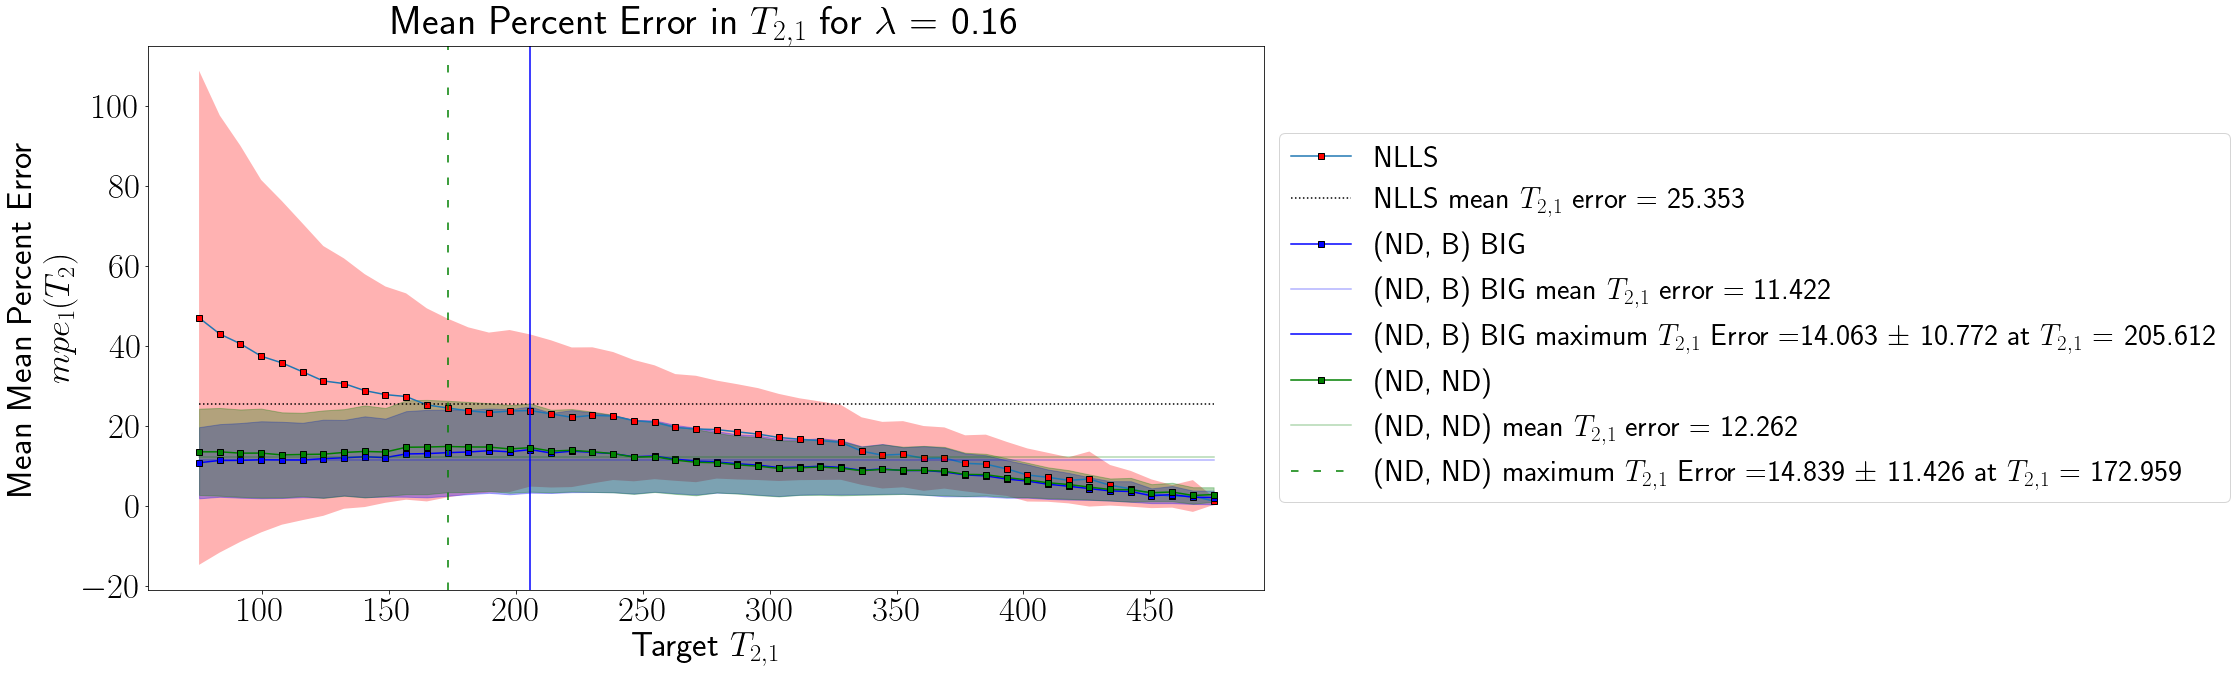

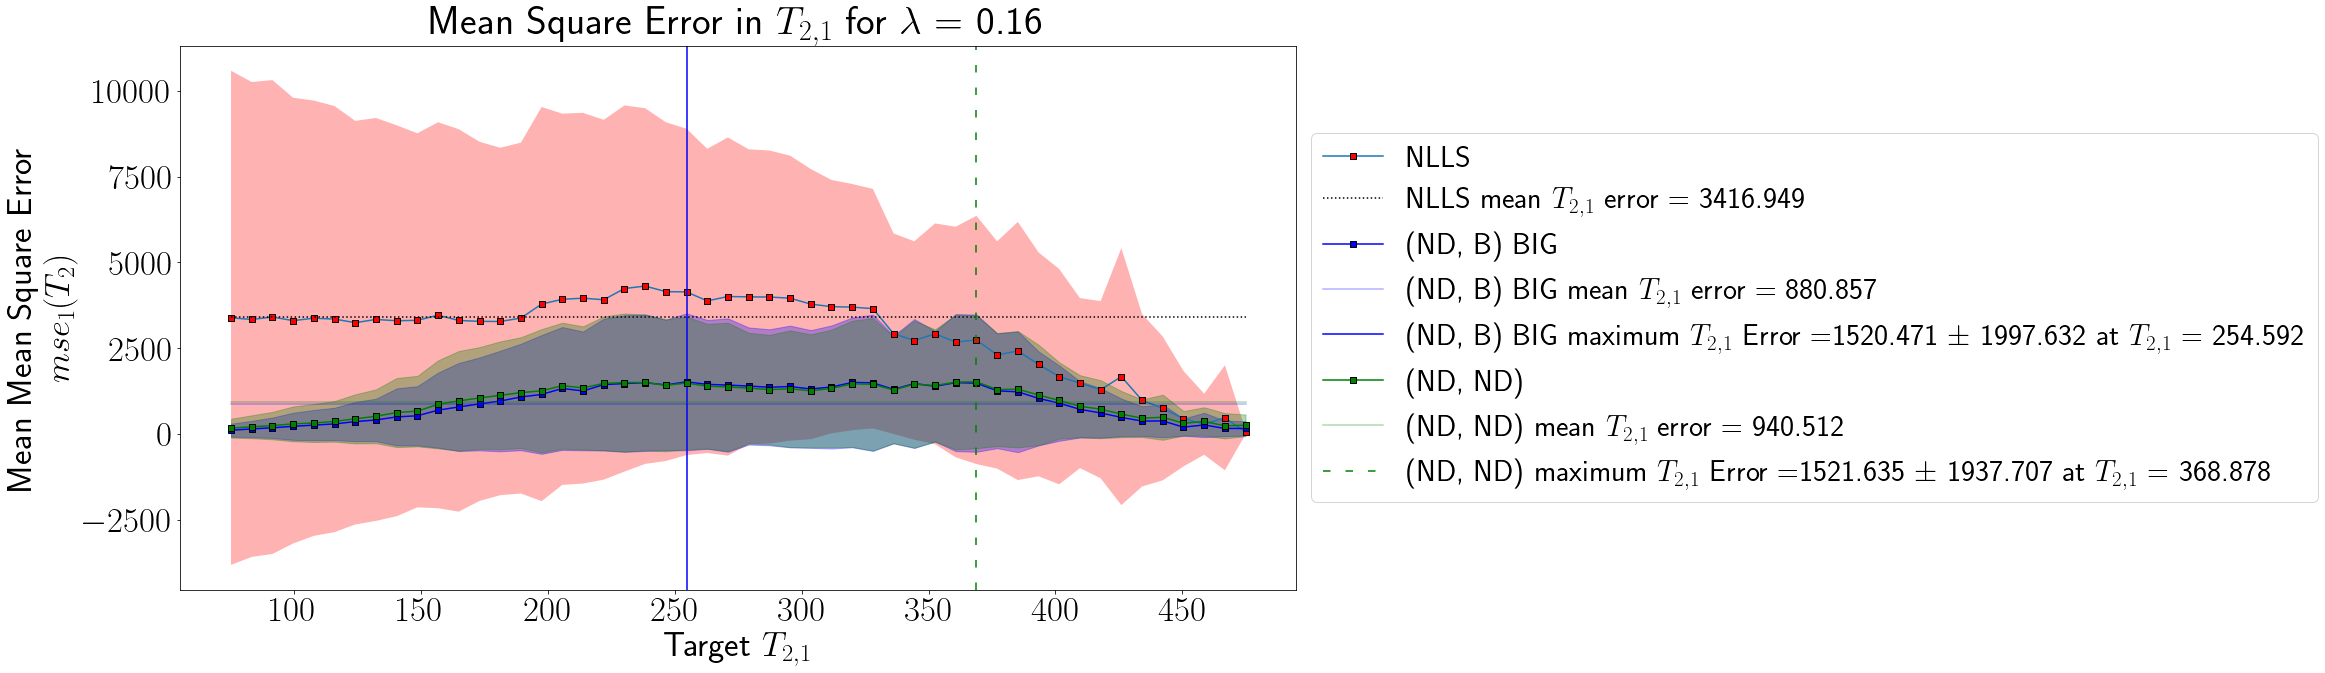

In [18]:
fignum = 0
inx = 0
Multiplier = 0
print(ErrorType)
NewErrorType = [ErrorType[0], ErrorType[1]]
print(NewErrorType)


ColorList = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
linestyle_list = ['solid', (0, (5,10)),'solid', (0, (5,10)),'solid', (0, (5,10)),'solid', (0, (5,10))]



for Error in NewErrorType:
                        Multiplier = 0
                        if Error == 'PE':
                            num = PEnum
                        if Error == 'SE':
                            num = SEnum
                        if Error == 'LPE':
                            num = LPEnum
                        if Error == 'LSE':
                            num = LSEnum

                        MethodLoop = len(ErrorType)
                        inx = (Multiplier*MethodLoop)+num
        
                        plt.figure(fignum, figsize=(20, 10))
                        plt.clf()
                        
                        #nlls
                        
                        plt.plot(unique_T21_targets_list[inx], twoT21_error_means_nlls_list[inx], marker='s', mfc='r', mec='k', label='NLLS')

                        plt.fill_between(unique_T21_targets_list[inx], twoT21_error_means_nlls_list[inx] - twoT21_error_stdevs_nlls_list[inx],
                                         twoT21_error_means_nlls_list[inx] + twoT21_error_stdevs_nlls_list[inx],alpha=0.3, facecolor='r')

                        plt.plot(T21_bounds_list[inx], [mean_T21_error_nlls_list[inx], mean_T21_error_nlls_list[inx]],

                                 'k:',

                                 label='NLLS mean $T_{2,1}$ error $=$ ' + f'{mean_T21_error_nlls_list[inx]:.3f} %')
                        
                        #plt.figtext(.131, -0.1, '[NLLS]' + ' maximum $T_{2,1}$ error $=$' + f'{max(twoT21_error_means_nlls_list[inx]):.3f}%')
                        
                        #rnlls

                        #plt.plot(unique_T21_targets_list[inx], twoT21_error_means_rnlls_list[inx], marker='s', mfc='b', mec='k', label='RNLLS')

                        #plt.fill_between(unique_T21_targets_list[inx], twoT21_error_means_rnlls_list[inx] - twoT21_error_stdevs_rnlls_list[inx], twoT21_error_means_rnlls_list[inx] + twoT21_error_stdevs_rnlls_list[inx], alpha=0.3, facecolor='b')

                        #plt.plot(T21_bounds_list[inx], [mean_T21_error_rnlls_list[inx], mean_T21_error_rnlls_list[inx]], 'k--', label='RNLLS mean $T_{2,1}$ error $=$ ' + f'{mean_T21_error_rnlls_list[inx]:.3f} %')
                        
                        #ma
                        Multiplier = 0
                        for place in Compare_List:
                            inx = (Multiplier*MethodLoop)+num

                            plt.plot(unique_T21_targets, twoT21_error_means_ma_list[inx], marker='s', mec='k', label=Description_List[place], color = ColorList[place])
                            
                            string = ' $\pm$ ' + str(round(twoT21_error_stdevs_ma_list[inx][twoT21_error_means_ma_list[inx].tolist().index(max(twoT21_error_means_ma_list[inx]))],3))                            
                            string2 = ' at $T_{2,1}$ = ' + str(round(unique_T21_targets_list[inx][twoT21_error_means_ma_list[inx].tolist().index(max(twoT21_error_means_ma_list[inx]))].item(), 3))
                            plt.fill_between(unique_T21_targets, twoT21_error_means_ma_list[inx] - twoT21_error_stdevs_ma_list[inx], twoT21_error_means_ma_list[inx] + twoT21_error_stdevs_ma_list[inx], alpha=0.3, color = ColorList[place])
                            plt.plot(T21_bounds, [mean_T21_error_ma_list[inx], mean_T21_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,1}$ error $=$ ' + f'{mean_T21_error_ma_list[inx]:.3f} %', color = ColorList[place])
                            plt.axvline(x=unique_T21_targets_list[inx][twoT21_error_means_ma_list[inx].tolist().index(max(twoT21_error_means_ma_list[inx]))], label = Description_List[place] + ' maximum $T_{2,1}$ Error $=$' + str(round(max(twoT21_error_means_ma_list[inx]), 3)) + string + string2, color = ColorList[place], linestyle = linestyle_list[place])
                            
                            Multiplier = Multiplier+1
                        
                        
                        plt.title(str(error_name_list[num])+' in $T_{2,1}$ for $\lambda$ = '+str(ld_list[place]), fontsize=40)


                        plt.xticks(fontsize=35)
                        plt.yticks(fontsize=35)
                        
                        plt.xlabel('Target $T_{2,1}$', fontsize=35)
                            
                        plt.ylabel('Mean '+error_name_list[num]+'\n'+error_abv_list[num]+'$_{1}(T_2)$', fontsize=35)
                        plt.tick_params(axis='x', labelsize = 35)
                        plt.tick_params(axis='y', labelsize = 35)
                        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})

                        fignum = fignum+1
                        plt.savefig(FIG_PATH + 'fig_T21_MPE_MSE_1D_plot.png', bbox_inches="tight")
                        
                        print(plt.rcParams['font.family'])
                        '''
                        #DESCRIPTION OF WHAT ERROR IS BEING PLOT
                        if num == PEnum:
                            plt.figtext(.691, .925, '$(Approximate - Exact)/Exact$', fontsize=18)
                        if num == SEnum:
                            plt.figtext(.731, .925, '$(Approximate - Exact)^{2}$', fontsize=18)
                        if num == LPEnum:
                            plt.figtext(.731, .975, '(log(Approximate) - log(Exact))/log(Exact)', fontsize=16)
                        if num == LSEnum:
                            plt.figtext(.731, .975, '(log(Approximate) - log(Exact))**2', fontsize=16)
                        '''
                        
                        
print('finished')


In [19]:
matplotlib.rcParams['font.family']

['sans-serif']

['PE', 'SE', 'LPE', 'LSE']
['PE', 'SE']


/tmp/ipykernel_1521587/3942606514.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(T22_bounds, [mean_T22_error_ma_list[inx], mean_T22_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,2}$ error $=$ ' + f'{mean_T22_error_ma_list[inx]:.3f} %', color = ColorList[place])
/tmp/ipykernel_1521587/3942606514.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(T22_bounds, [mean_T22_error_ma_list[inx], mean_T22_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,2}$ error $=$ ' + f'{mean_T22_error_ma_list[inx]:.3f} %', color = ColorList[place])
/tmp/ipykernel_1521587/3942606514.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (->

finished


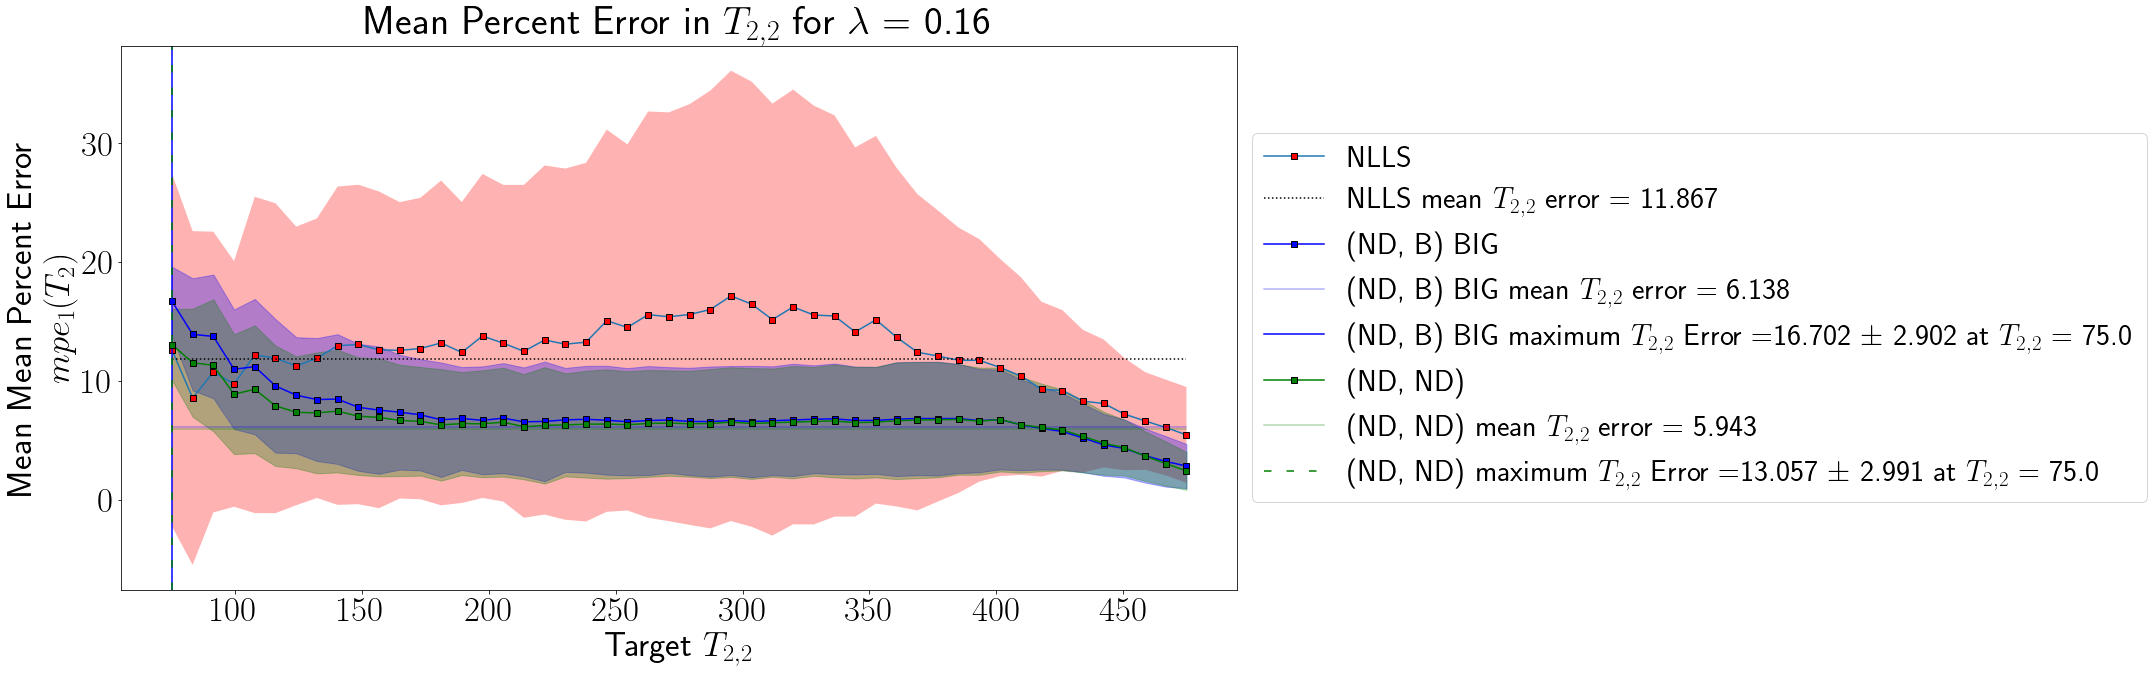

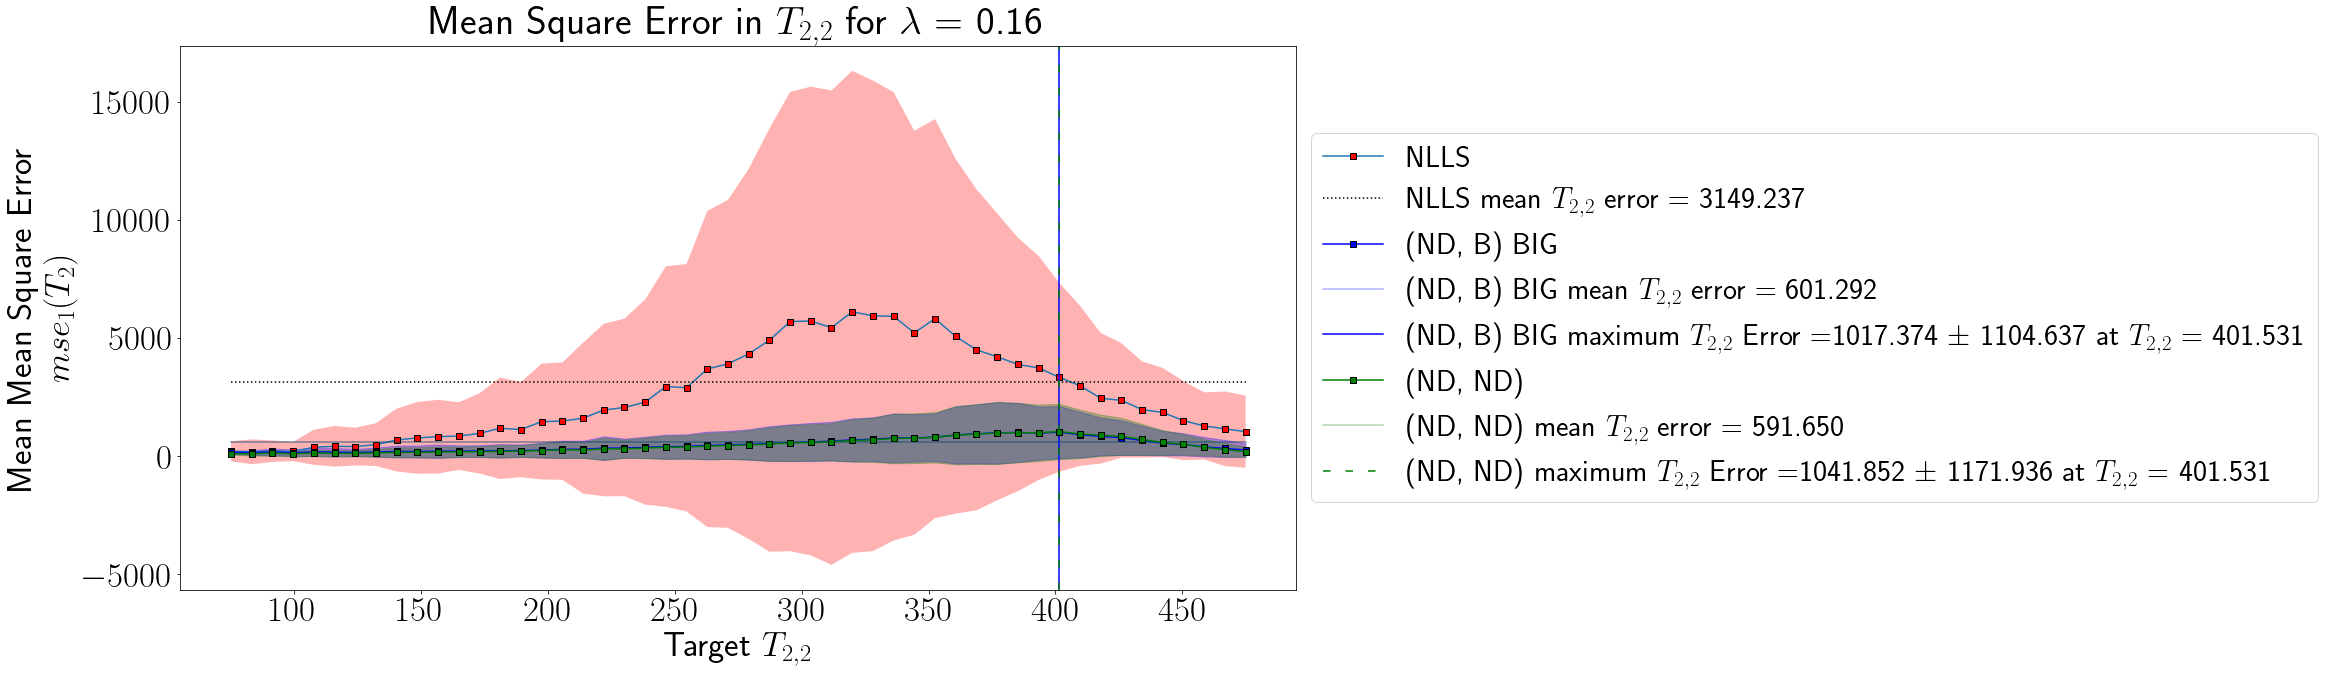

In [20]:
fignum = 0
inx = 0
Multiplier = 0
print(ErrorType)
NewErrorType = [ErrorType[0], ErrorType[1]]
print(NewErrorType)


ColorList = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
linestyle_list = ['solid', (0, (5,10)),'solid', (0, (5,10)),'solid', (0, (5,10)),'solid', (0, (5,10))]



for Error in NewErrorType:
                        Multiplier = 0
                        if Error == 'PE':
                            num = PEnum
                        if Error == 'SE':
                            num = SEnum
                        if Error == 'LPE':
                            num = LPEnum
                        if Error == 'LSE':
                            num = LSEnum

                        MethodLoop = len(ErrorType)
                        inx = (Multiplier*MethodLoop)+num
        
                        plt.figure(fignum, figsize=(20, 10))
                        plt.clf()
                        
                        #nlls
                        
                        plt.plot(unique_T22_targets_list[inx], twoT22_error_means_nlls_list[inx], marker='s', mfc='r', mec='k', label='NLLS')

                        plt.fill_between(unique_T22_targets_list[inx], twoT22_error_means_nlls_list[inx] - twoT22_error_stdevs_nlls_list[inx],
                                         twoT22_error_means_nlls_list[inx] + twoT22_error_stdevs_nlls_list[inx],alpha=0.3, facecolor='r')

                        plt.plot(T22_bounds_list[inx], [mean_T22_error_nlls_list[inx], mean_T22_error_nlls_list[inx]],

                                 'k:',

                                 label='NLLS mean $T_{2,2}$ error $=$ ' + f'{mean_T22_error_nlls_list[inx]:.3f} %')
                        
                        #plt.figtext(.131, -0.1, '[NLLS]' + ' maximum $T_{2,2}$ error $=$' + f'{max(twoT22_error_means_nlls_list[inx]):.3f}%')
                        
                        #rnlls

                        #plt.plot(unique_T22_targets_list[inx], twoT22_error_means_rnlls_list[inx], marker='s', mfc='b', mec='k', label='RNLLS')

                        #plt.fill_between(unique_T22_targets_list[inx], twoT22_error_means_rnlls_list[inx] - twoT22_error_stdevs_rnlls_list[inx], twoT22_error_means_rnlls_list[inx] + twoT22_error_stdevs_rnlls_list[inx], alpha=0.3, facecolor='b')

                        #plt.plot(T22_bounds_list[inx], [mean_T22_error_rnlls_list[inx], mean_T22_error_rnlls_list[inx]], 'k--', label='RNLLS mean $T_{2,2}$ error $=$ ' + f'{mean_T22_error_rnlls_list[inx]:.3f} %')
                        
                        #ma
                        Multiplier = 0
                        for place in Compare_List:
                            inx = (Multiplier*MethodLoop)+num

                            plt.plot(unique_T22_targets, twoT22_error_means_ma_list[inx], marker='s', mec='k', label=Description_List[place], color = ColorList[place])
                            
                            string = ' $\pm$ ' + str(round(twoT22_error_stdevs_ma_list[inx][twoT22_error_means_ma_list[inx].tolist().index(max(twoT22_error_means_ma_list[inx]))],3))                            
                            string2 = ' at $T_{2,2}$ = ' + str(round(unique_T22_targets_list[inx][twoT22_error_means_ma_list[inx].tolist().index(max(twoT22_error_means_ma_list[inx]))].item(), 3))
                            plt.fill_between(unique_T22_targets, twoT22_error_means_ma_list[inx] - twoT22_error_stdevs_ma_list[inx], twoT22_error_means_ma_list[inx] + twoT22_error_stdevs_ma_list[inx], alpha=0.3, color = ColorList[place])
                            plt.plot(T22_bounds, [mean_T22_error_ma_list[inx], mean_T22_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean $T_{2,2}$ error $=$ ' + f'{mean_T22_error_ma_list[inx]:.3f} %', color = ColorList[place])
                            plt.axvline(x=unique_T22_targets_list[inx][twoT22_error_means_ma_list[inx].tolist().index(max(twoT22_error_means_ma_list[inx]))], label = Description_List[place] + ' maximum $T_{2,2}$ Error $=$' + str(round(max(twoT22_error_means_ma_list[inx]), 3)) + string + string2, color = ColorList[place], linestyle = linestyle_list[place])
                            
                            Multiplier = Multiplier+1
                        
                        
                        plt.title(str(error_name_list[num])+' in $T_{2,2}$ for $\lambda$ = '+str(ld_list[place]), fontsize=40)


                        plt.xticks(fontsize=35)
                        plt.yticks(fontsize=35)
                        
                        plt.xlabel('Target $T_{2,2}$', fontsize=35)
                            
                        plt.ylabel('Mean '+error_name_list[num]+'\n'+error_abv_list[num]+'$_{1}(T_2)$', fontsize=35)
                        plt.tick_params(axis='x', labelsize = 35)
                        plt.tick_params(axis='y', labelsize = 35)
                        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})

                        fignum = fignum+1
                        plt.savefig(FIG_PATH + 'fig_T22_MPE_MSE_1D_plot.png', bbox_inches="tight")
                        '''
                        #DESCRIPTION OF WHAT ERROR IS BEING PLOT
                        if num == PEnum:
                            plt.figtext(.691, .925, '$(Approximate - Exact)/Exact$', fontsize=18)
                        if num == SEnum:
                            plt.figtext(.731, .925, '$(Approximate - Exact)^{2}$', fontsize=18)
                        if num == LPEnum:
                            plt.figtext(.731, .975, '(log(Approximate) - log(Exact))/log(Exact)', fontsize=16)
                        if num == LSEnum:
                            plt.figtext(.731, .975, '(log(Approximate) - log(Exact))**2', fontsize=16)
                        '''
                        
                        
print('finished')


['PE', 'SE', 'LPE', 'LSE']
['PE', 'SE']
finished


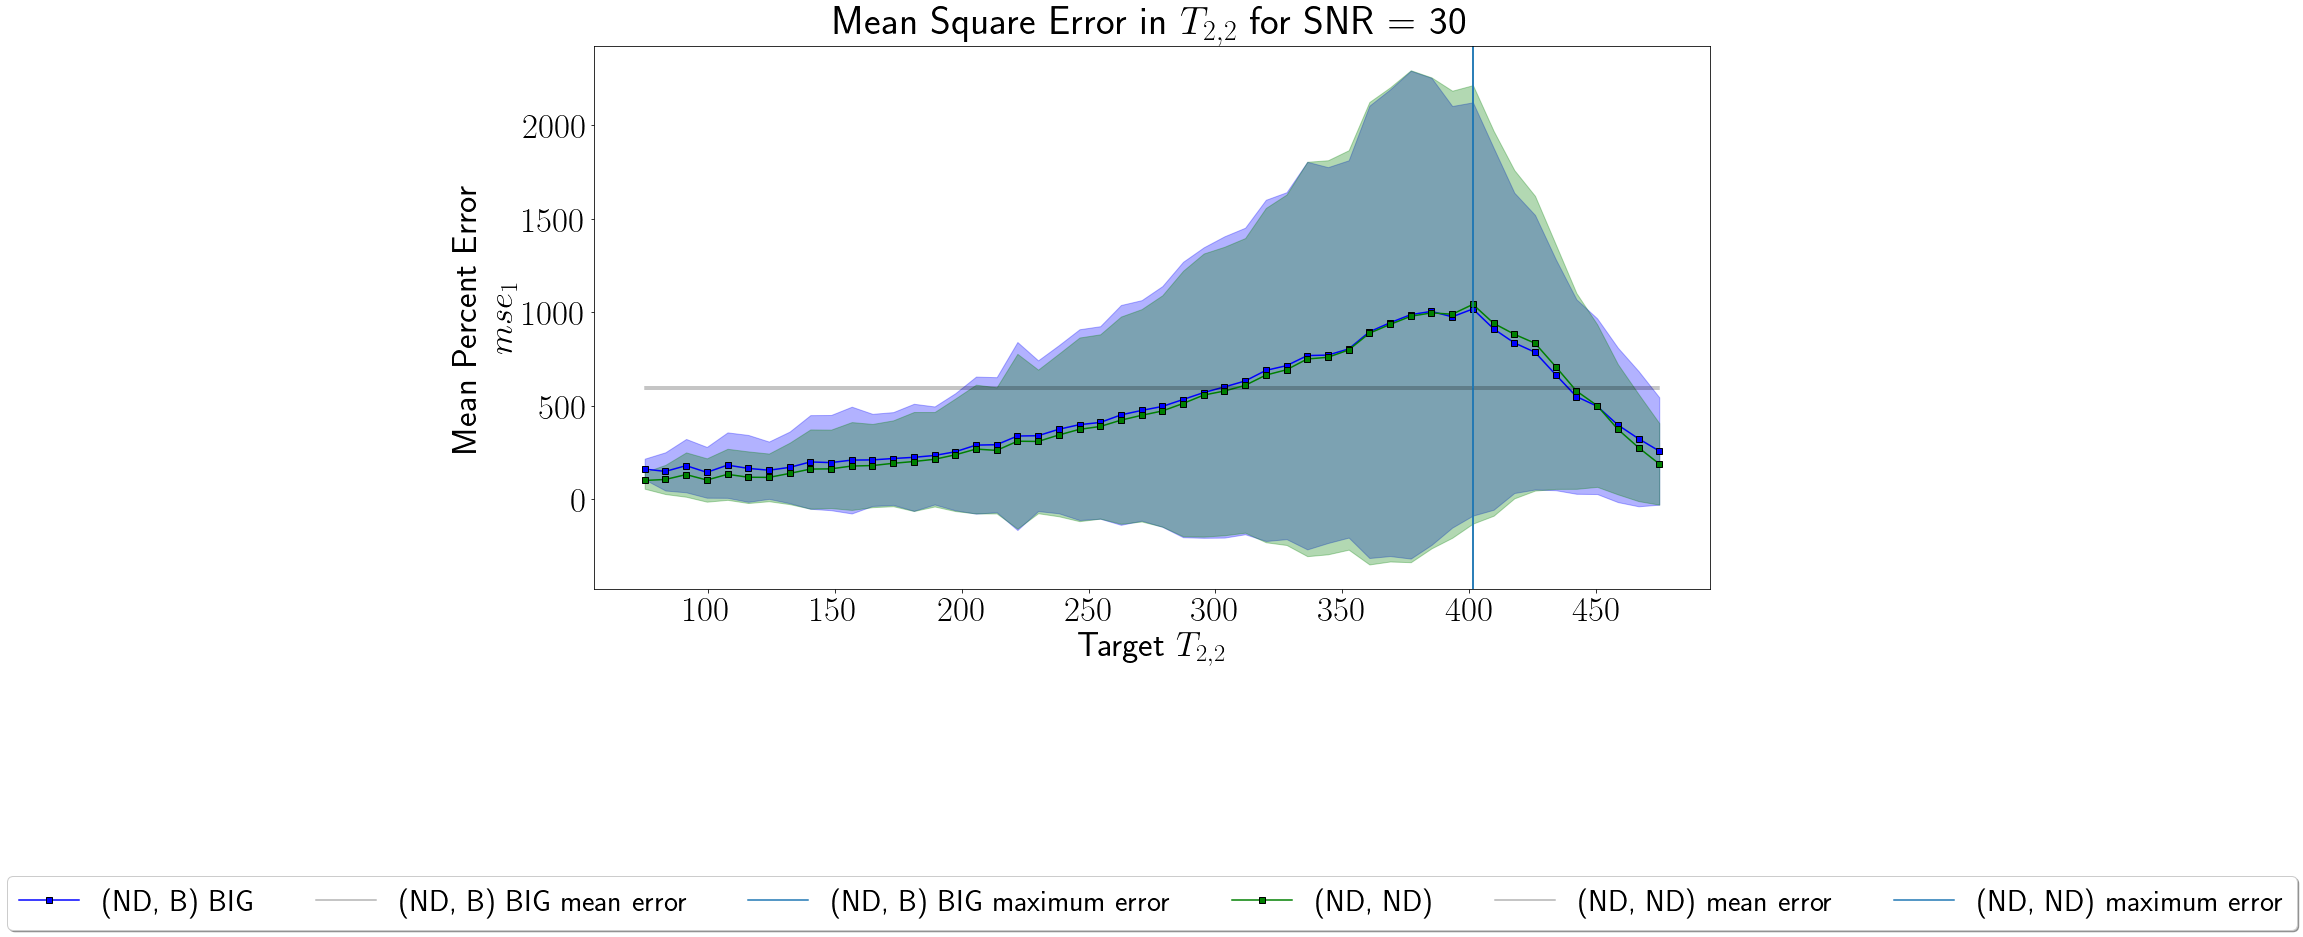

In [21]:
fignum = 0
inx = 0
Multiplier = 0
print(ErrorType)
NewErrorType = [ErrorType[0], ErrorType[1]]
print(NewErrorType)


plt.figure(fignum, figsize=(20, 10))
for Error in NewErrorType:
                        Multiplier = 0
                        if Error == 'PE':
                            num = PEnum
                        if Error == 'SE':
                            num = SEnum
                        if Error == 'LPE':
                            num = LPEnum
                        if Error == 'LSE':
                            num = LSEnum

                        MethodLoop = len(ErrorType)
                        inx = (Multiplier*MethodLoop)+num
        
                        
                        plt.clf()
                        '''
                        #nlls
                        
                        plt.plot(unique_T22_targets_list[inx], twoT22_error_means_nlls_list[inx], marker='s', mfc='r', mec='k', label='NLLS')

                        plt.fill_between(unique_T22_targets_list[inx], twoT22_error_means_nlls_list[inx] - twoT22_error_stdevs_nlls_list[inx],
                                         twoT22_error_means_nlls_list[inx] + twoT22_error_stdevs_nlls_list[inx],alpha=0.3, facecolor='r')

                        plt.plot(T22_bounds_list[inx], [mean_T22_error_nlls_list[inx], mean_T22_error_nlls_list[inx]],

                                 'k:',

                                 label='NLLS mean $T_{2,2}$ error $=$ ' + f'{mean_T22_error_nlls_list[inx]:.3f} %')
                        
                        plt.figtext(.131, -0.1, '[NLLS]' + ' maximum $T_{2,2}$ error $=$' + f'{max(twoT22_error_means_nlls_list[inx]):.3f}%')
                        
                        #rnlls

                        #plt.plot(unique_T22_targets_list[inx], twoT22_error_means_rnlls_list[inx], marker='s', mfc='b', mec='k', label='RNLLS')

                        #plt.fill_between(unique_T22_targets_list[inx], twoT22_error_means_rnlls_list[inx] - twoT22_error_stdevs_rnlls_list[inx], twoT22_error_means_rnlls_list[inx] + twoT22_error_stdevs_rnlls_list[inx], alpha=0.3, facecolor='b')

                        #plt.plot(T22_bounds_list[inx], [mean_T22_error_rnlls_list[inx], mean_T22_error_rnlls_list[inx]], 'k--', label='RNLLS mean $T_{2,2}$ error $=$ ' + f'{mean_T22_error_rnlls_list[inx]:.3f} %')
                        '''
                        #ma
                        Multiplier = 0
                        for place in Compare_List:
                            inx = (Multiplier*MethodLoop)+num

                            plt.plot(unique_T22_targets, twoT22_error_means_ma_list[inx], marker='s', mec='k', label=Description_List[place], color = ColorList[place])
                            
                            string = ' $\pm$ ' + str(round(twoT22_error_stdevs_ma_list[inx][twoT22_error_means_ma_list[inx].tolist().index(max(twoT22_error_means_ma_list[inx]))],3))                            
                            string2 = ' at $T_{2,2}$ = ' + str(round(unique_T22_targets_list[inx][twoT22_error_means_ma_list[inx].tolist().index(max(twoT22_error_means_ma_list[inx]))].item(), 3))
                            plt.fill_between(unique_T22_targets, twoT22_error_means_ma_list[inx] - twoT22_error_stdevs_ma_list[inx], twoT22_error_means_ma_list[inx] + twoT22_error_stdevs_ma_list[inx], alpha=0.3, color = ColorList[place])
                            plt.plot(T22_bounds, [mean_T22_error_ma_list[inx], mean_T22_error_ma_list[inx]], 'k-',alpha = 0.3, label= Description_List[place] + ' mean error')
                            plt.axvline(x=unique_T22_targets_list[inx][twoT22_error_means_ma_list[inx].tolist().index(max(twoT22_error_means_ma_list[inx]))], label = Description_List[place] + ' maximum error')
                            
                            Multiplier = Multiplier+1
                        
                        
                        plt.title(str(error_name_list[num])+' in $T_{2,2}$ for SNR = '+str(round(np.sqrt(SNR_A))), fontsize=40)


                        plt.xticks(fontsize=35)
                        plt.yticks(fontsize=35)
                        
                        plt.xlabel('Target $T_{2,2}$', fontsize=35)
                            
                        plt.ylabel('Mean Percent Error'+'\n'+error_abv_list[num]+'$_{1}$', fontsize=35)

                        

                        fignum = fignum+1
                        
                        '''
                        #DESCRIPTION OF WHAT ERROR IS BEING PLOT
                        if num == PEnum:
                            plt.figtext(.691, .925, '$(Approximate - Exact)/Exact$', fontsize=18)
                        if num == SEnum:
                            plt.figtext(.731, .925, '$(Approximate - Exact)^{2}$', fontsize=18)
                        if num == LPEnum:
                            plt.figtext(.731, .975, '(log(Approximate) - log(Exact))/log(Exact)', fontsize=16)
                        if num == LSEnum:
                            plt.figtext(.731, .975, '(log(Approximate) - log(Exact))**2', fontsize=16)
                        '''
            
                        
print('finished')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=6, prop={'size':30})
plt.savefig(FIG_PATH + 'fig_T22_MPE_MSE_1D_plot.png', bbox_inches="tight")

/tmp/ipykernel_1521587/3868025056.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h1 = ax1.pcolormesh(unique_T21_targets_list[val], unique_T22_targets_list[val], out, cmap=cmap, vmin = vmin, vmax=vmax)


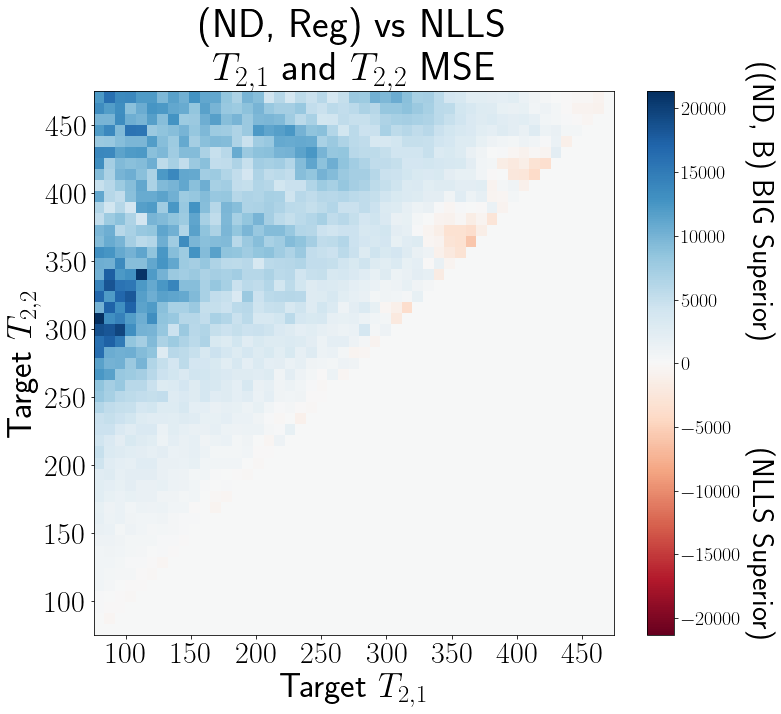

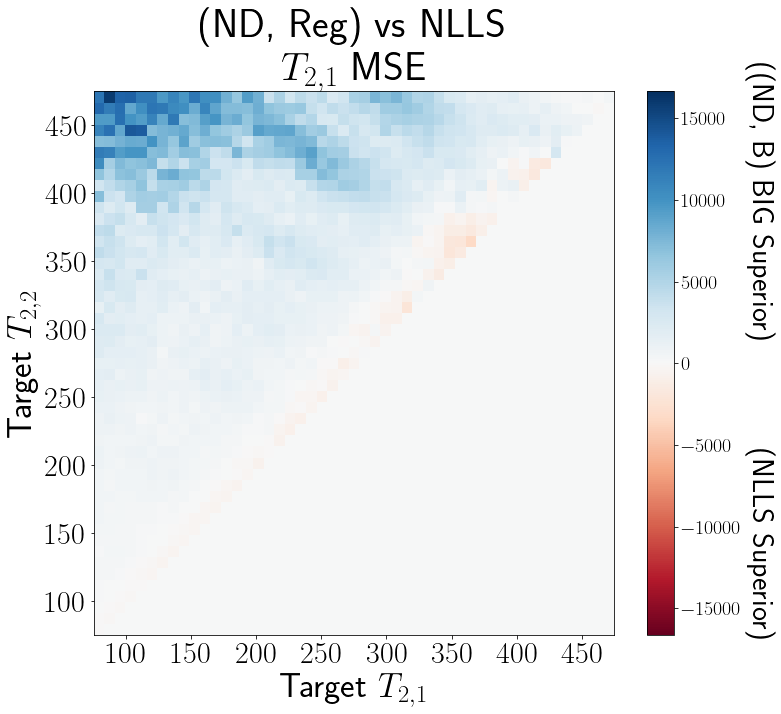

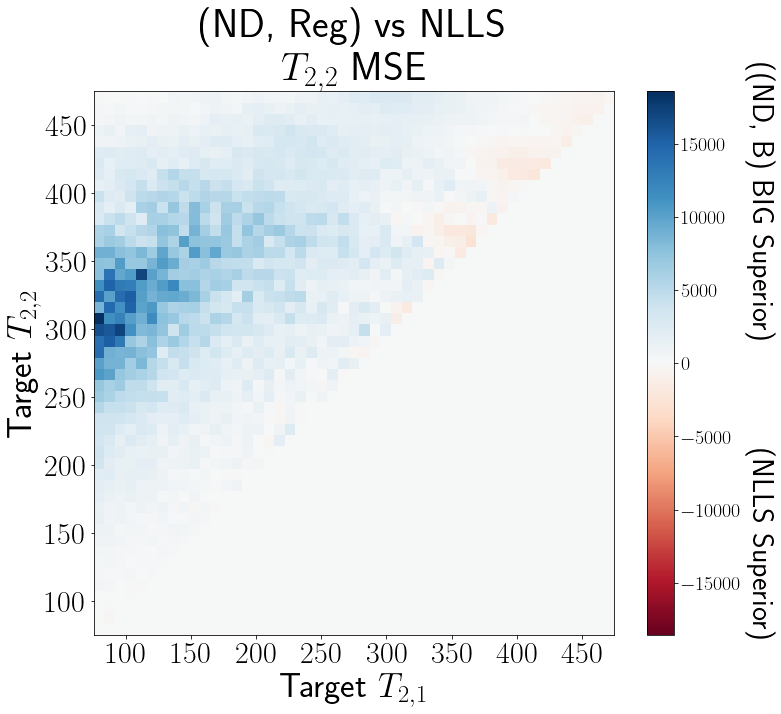

In [22]:
val = 0

def heat_plot3(n, out, title, vmin, vmax, Even = 'Even', T2 = 'T21 & T22'):
    #plt.clf()
    
    heatmap_conditionnum_T21_A = plt.figure(figsize=(70/6,10))

    cmap = 'RdBu'
    
    ax1 = heatmap_conditionnum_T21_A.add_subplot(1, 1, 1)
    h1 = ax1.pcolormesh(unique_T21_targets_list[val], unique_T22_targets_list[val], out, cmap=cmap, vmin = vmin, vmax=vmax)
    ttl = ax1.set_title(title, fontsize=40)  
    
    ax1.set_xlabel('Target $T_{2,1}$', fontsize=35)
    ax1.set_ylabel('Target $T_{2,2}$', fontsize=35)
    
    
    
    #if Even == 'Even':
    #    plt.figtext(.365,0.9, '$(Approximate - Exact)/Exact$', fontsize=20)
    #else:
    #    plt.figtext(.405,0.9, '$(Approximate - Exact)^{2}$', fontsize=20)
    
    #heatmap_conditionnum_T21_A.colorbar()
    plt.colorbar(h1)
    ax1.text(575,295,'('+Description_A+' Superior)', rotation=270, fontsize=30)
    ax1.text(575,75,'(NLLS Superior)', rotation=270, fontsize=30)
    '''
    if T2 == 'T21 & T22':
        ax1.text(695,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T21}$', rotation=270, fontsize=30)
        ax1.text(675,275,'+', rotation=270, fontsize=30)
        ax1.text(655,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T22}$', rotation=270, fontsize=30)
    if T2 == 'T21':
        ax1.text(655,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T21}$', rotation=270, fontsize=30)
    if T2 == 'T22':
        ax1.text(655,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T22}$', rotation=270, fontsize=30)
    '''
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    
    #heatmap_conditionnum_T21_A = plt.figure(figsize=plt.figaspect(0.5))
 
#list1 = [torch.min(((twoT21_error_means_nlls_xy_list[val+4]-twoT21_error_means_ma_xy_list[val])+(twoT22_error_means_ma_xy_list[val+4]-twoT22_error_means_ma_xy_list[val])).T), torch.max(((twoT21_error_means_ma_xy_list[val+4]-twoT21_error_means_ma_xy_list[val])+(twoT22_error_means_ma_xy_list[val+4]-twoT22_error_means_ma_xy_list[val])).T)]
list2 = [torch.min(((twoT21_error_means_nlls_xy_list[val+1]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_nlls_xy_list[val+1]-twoT22_error_means_ma_xy_list[val+1])).T), torch.max(((twoT21_error_means_nlls_xy_list[val+1]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_nlls_xy_list[val+1]-twoT22_error_means_ma_xy_list[val+1])).T)]
list3 = [torch.min(((twoT21_error_means_nlls_xy_list[val+1]-twoT21_error_means_ma_xy_list[val+1])).T), torch.max(((twoT21_error_means_nlls_xy_list[val+1]-twoT21_error_means_ma_xy_list[val+1])).T)]
list4 = [torch.min(((twoT22_error_means_nlls_xy_list[val+1]-twoT22_error_means_ma_xy_list[val+1])).T), torch.max(((twoT22_error_means_nlls_xy_list[val+1]-twoT22_error_means_ma_xy_list[val+1])).T)]

#a = np.max(np.abs(list1))
b = np.max(np.abs(list2))
b2 = np.max(np.abs(list3))
b3 = np.max(np.abs(list4))

title = '(ND, Reg) vs NLLS    \n $T_{2,1}$ and $T_{2,2}$ MSE'
title2 = '(ND, Reg) vs NLLS    \n $T_{2,1}$ MSE'
title3 = '(ND, Reg) vs NLLS    \n $T_{2,2}$ MSE'


#heat_plot3(2, ((twoT21_error_means_ma_xy_list[val+4]-twoT21_error_means_ma_xy_list[val])+(twoT22_error_means_ma_xy_list[val+4]-twoT22_error_means_ma_xy_list[val])).T, Description_B+' vs '+Description_A+': \n Difference in Totaled Percent Error, \n (SNR = ~'+str(round(np.sqrt(SNR_A)))+ ')', -a, a)
heat_plot3(2, ((twoT21_error_means_nlls_xy_list[val+1]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_nlls_xy_list[val+1]-twoT22_error_means_ma_xy_list[val+1])).T,  title, -b, b, Even = 'Odd')
heat_plot3(2, ((twoT21_error_means_nlls_xy_list[val+1]-twoT21_error_means_ma_xy_list[val+1])).T,  title2, -b2, b2, Even = 'Odd')
heat_plot3(2, ((twoT22_error_means_nlls_xy_list[val+1]-twoT22_error_means_ma_xy_list[val+1])).T,  title3, -b3, b3, Even = 'Odd')


/tmp/ipykernel_1521587/1693349096.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h1 = ax1.pcolormesh(unique_T21_targets_list[val], unique_T22_targets_list[val], out, cmap=cmap, vmin = vmin, vmax=vmax)


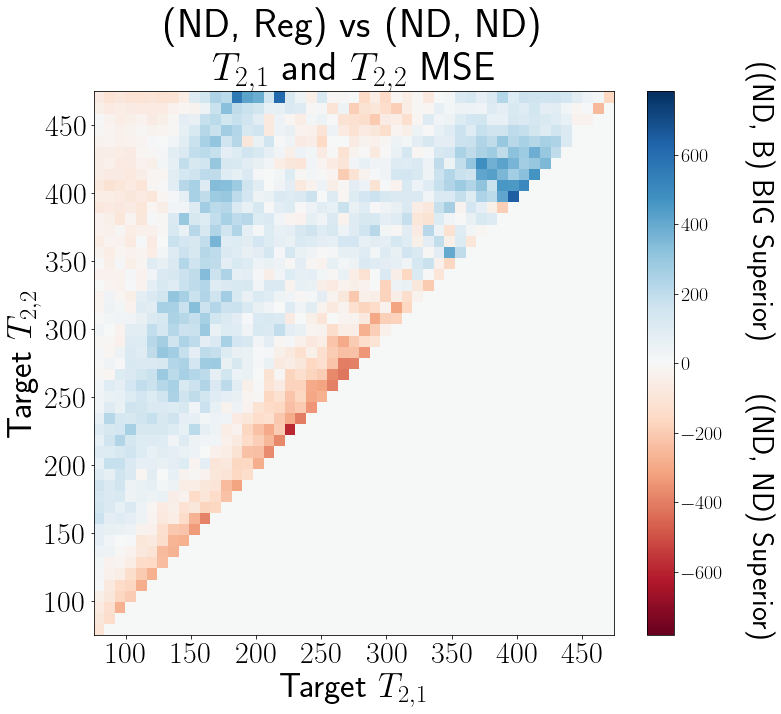

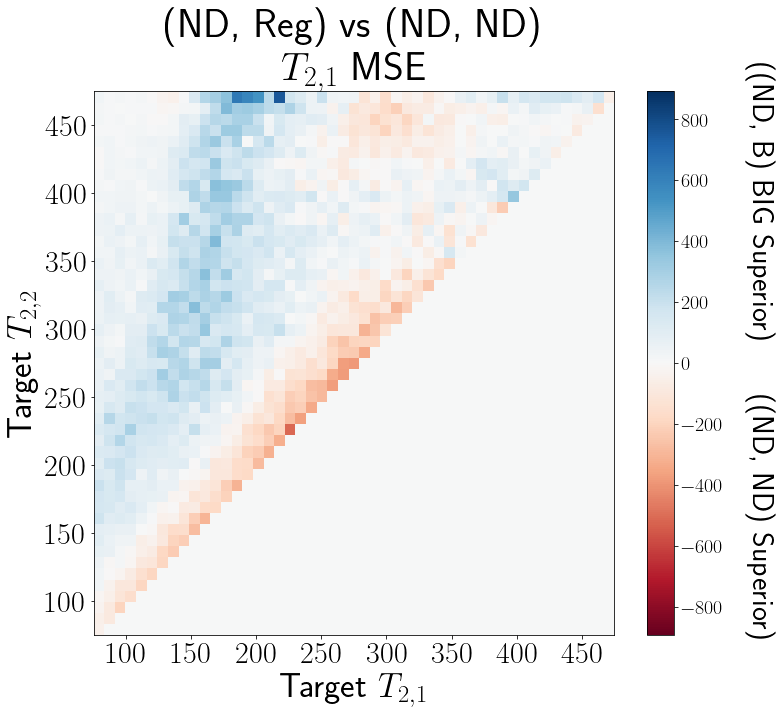

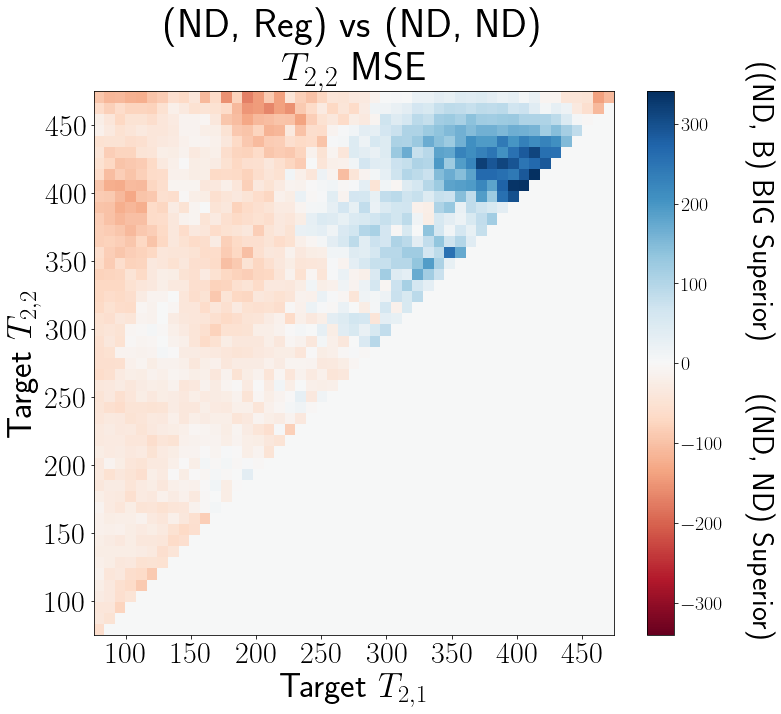

In [23]:
val = 0

def heat_plot3(n, out, title, vmin, vmax, Even = 'Even', T2 = 'T21 & T22'):
    #plt.clf()
    
    heatmap_conditionnum_T21_A = plt.figure(figsize=(70/6,10))

    cmap = 'RdBu'
    
    ax1 = heatmap_conditionnum_T21_A.add_subplot(1, 1, 1)
    h1 = ax1.pcolormesh(unique_T21_targets_list[val], unique_T22_targets_list[val], out, cmap=cmap, vmin = vmin, vmax=vmax)
    ttl = ax1.set_title(title, fontsize=40)  
    
    ax1.set_xlabel('Target $T_{2,1}$', fontsize=35)
    ax1.set_ylabel('Target $T_{2,2}$', fontsize=35)
    
    
    
    #if Even == 'Even':
    #    plt.figtext(.365,0.9, '$(Approximate - Exact)/Exact$', fontsize=20)
    #else:
    #    plt.figtext(.405,0.9, '$(Approximate - Exact)^{2}$', fontsize=20)
    
    #heatmap_conditionnum_T21_A.colorbar()
    plt.colorbar(h1)
    ax1.text(575,295,'('+Description_A+' Superior)', rotation=270, fontsize=30)
    ax1.text(575,75,'((ND, ND) Superior)', rotation=270, fontsize=30)
    '''
    if T2 == 'T21 & T22':
        ax1.text(695,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T21}$', rotation=270, fontsize=30)
        ax1.text(675,275,'+', rotation=270, fontsize=30)
        ax1.text(655,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T22}$', rotation=270, fontsize=30)
    if T2 == 'T21':
        ax1.text(655,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T21}$', rotation=270, fontsize=30)
    if T2 == 'T22':
        ax1.text(655,115,'($Error_{\; NLLS } \; - \; Error_{\;'+Description_A+'}$)$_{ T22}$', rotation=270, fontsize=30)
    '''
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    
    #heatmap_conditionnum_T21_A = plt.figure(figsize=plt.figaspect(0.5))
 
#list1 = [torch.min(((twoT21_error_means_nlls_xy_list[val+4]-twoT21_error_means_ma_xy_list[val])+(twoT22_error_means_ma_xy_list[val+4]-twoT22_error_means_ma_xy_list[val])).T), torch.max(((twoT21_error_means_ma_xy_list[val+4]-twoT21_error_means_ma_xy_list[val])+(twoT22_error_means_ma_xy_list[val+4]-twoT22_error_means_ma_xy_list[val])).T)]
list2 = [torch.min(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T), torch.max(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T)]
list3 = [torch.min(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])).T), torch.max(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])).T)]
list4 = [torch.min(((twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T), torch.max(((twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T)]

#a = np.max(np.abs(list1))
b = np.max(np.abs(list2))
b2 = np.max(np.abs(list3))
b3 = np.max(np.abs(list4))

title = '(ND, Reg) vs (ND, ND)    \n $T_{2,1}$ and $T_{2,2}$ MSE'
title2 = '(ND, Reg) vs (ND, ND)    \n $T_{2,1}$ MSE'
title3 = '(ND, Reg) vs (ND, ND)    \n $T_{2,2}$ MSE'


#heat_plot3(2, ((twoT21_error_means_ma_xy_list[val+4]-twoT21_error_means_ma_xy_list[val])+(twoT22_error_means_ma_xy_list[val+4]-twoT22_error_means_ma_xy_list[val])).T, Description_B+' vs '+Description_A+': \n Difference in Totaled Percent Error, \n (SNR = ~'+str(round(np.sqrt(SNR_A)))+ ')', -a, a)
heat_plot3(2, ((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T,  title, -b, b, Even = 'Odd')
heat_plot3(2, ((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])).T,  title2, -b2, b2, Even = 'Odd')
heat_plot3(2, ((twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T,  title3, -b3, b3, Even = 'Odd')


In [24]:
unique_T21_targets.shape

torch.Size([50])

<Figure size 432x288 with 0 Axes>

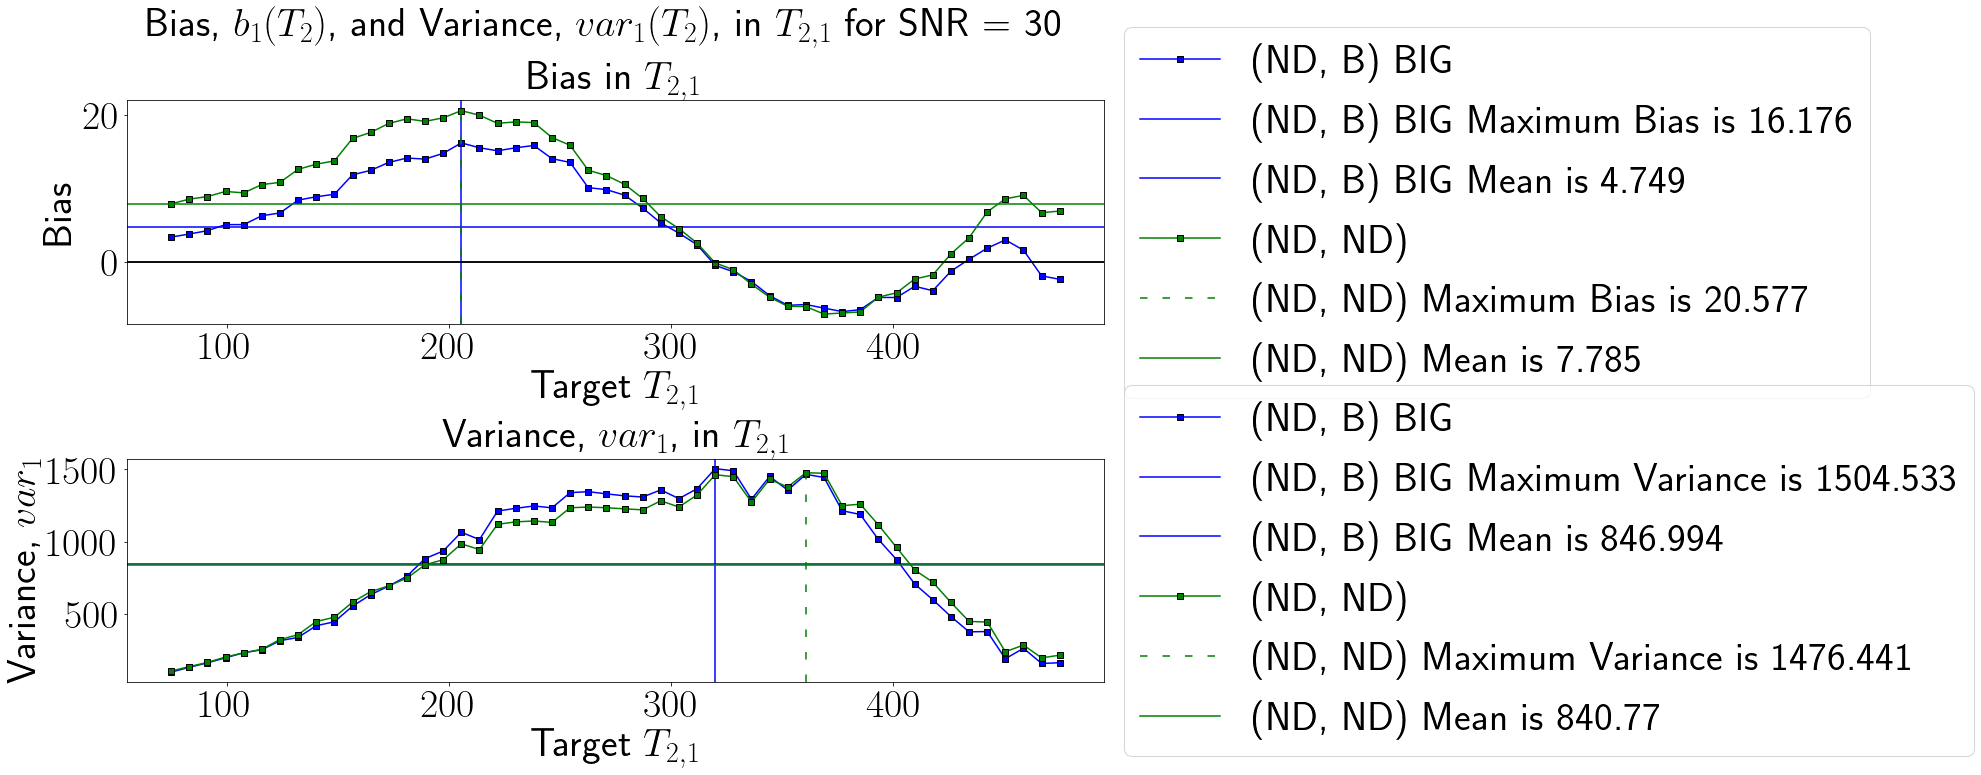

In [25]:
##### BIAS AND VARIANCE PLOTS #########
inx = 0

plt.clf()

bias_variance = plt.figure(figsize=(15,10))
numb = 40


bias_variance.suptitle(
    'Bias, $b_{1}(T_2)$, and Variance, $var_{1}(T_2)$, in $T_{2,1}$ for SNR = '+str(round(np.sqrt(SNR_A))), fontsize = numb)
ax1 = bias_variance.add_subplot(2, 1, 1)

ttl = ax1.title
ttl.set_position([.5, 1.05])

bias_variance.tight_layout(pad=1.5, w_pad=3, h_pad=6)

bias_variance.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

Multiplier = 0

#ax1.plot(unique_T21_targets_list[inx], (predicted_T21_means_rnlls_list[inx]-unique_T21_targets_list[inx].numpy()), marker='s', mec='k', label='rnlls')
#ax1.plot(unique_T21_targets_list[inx], (predicted_T21_means_nlls_list[inx]-unique_T21_targets_list[inx].numpy()), marker='s', mec='k', label='nlls')

for place in Compare_List:
    inx = (Multiplier*MethodLoop)+num           
    #inx = 4*x
    #print(inx)
    
    #BIAS
    ax1.plot(unique_T21_targets_list[inx], ((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())), marker='s', mec='k', label=Description_List[place], color = ColorList[place])
    
    
    ax1.axvline(x=unique_T21_targets_list[inx][(predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy()).tolist().index(max((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())))], label = Description_List[place] + ' Maximum Bias is ' + str(round(max((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())), 3)), color = ColorList[place], linestyle = linestyle_list[place])
    ax1.axhline(y=0, color='black')
    ax1.axhline(y=np.average((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())), label = Description_List[place] + ' Mean is ' + str(round(np.average(predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy()),3)), color = ColorList[place])
    
    Multiplier = Multiplier+1

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':numb})    
ax2 = bias_variance.add_subplot(2, 1, 2)

Multiplier = 0

for place in Compare_List:
    inx = (Multiplier*MethodLoop)+num           
    #inx = 4*x
    
    #VARIANCE
    ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_ma_list[inx] ** 2), marker='s', mec='k', label=Description_List[place], color = ColorList[place])
    
    
    ax2.axvline(x=unique_T21_targets_list[inx][(predicted_T21_stdevs_ma_list[inx] ** 2).tolist().index(max((predicted_T21_stdevs_ma_list[inx] ** 2)))], label = Description_List[place] + ' Maximum Variance is ' + str(round(max((predicted_T21_stdevs_ma_list[inx] ** 2)), 3)), color = ColorList[place], linestyle = linestyle_list[place])
    ax2.axhline(y=np.average((predicted_T21_stdevs_ma_list[inx] ** 2)), label = Description_List[place] + ' Mean is ' + str(round(np.average(predicted_T21_stdevs_ma_list[inx] ** 2),3)), color = ColorList[place])
    Multiplier = Multiplier+1

#ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_rnlls_list[inx] ** 2)/new_every, marker='s', mec='k', label='rnlls')
#ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_nlls_list[inx] ** 2)/new_every, marker='s', mec='k', label='nlls')


ax1.set_ylabel('Bias', size=numb)
ax1.set_title('Bias in $T_{2,1}$', size=numb)
ax1.set_xlabel('Target $T_{2,1}$', size=numb)
ax1.tick_params(labelsize=numb)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': numb})

ax2.set_title('Variance, $var_{1}$, in $T_{2,1}$', size=numb)
ax2.set_xlabel('Target $T_{2,1}$', size=numb)
ax2.set_ylabel('Variance, $var_{1}$', size=numb)
ax2.tick_params(labelsize=numb)

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': numb})

plt.savefig(FIG_PATH + 'fig_biaa_variance_T21_stdev_seperate.png', bbox_inches="tight")

In [26]:
print(predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())
print('-----------------')
print(np.abs(predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy()))

[ 7.87493896  8.50580971  8.86013015  9.55566001  9.36447875 10.49309882
 10.7956462  12.57294791 13.27505431 13.72337653 16.78174513 17.60705099
 18.83071806 19.46402258 19.11386762 19.59546926 20.57740659 19.95018254
 18.84488538 19.04534383 18.94611966 16.90999058 15.84795208 12.44433033
 11.73104672 10.53607365  8.61343944  6.10694294  4.4927499   2.51576389
 -0.19202657 -1.1062074  -3.10101567 -4.86126584 -6.10698965 -6.14610944
 -7.16673559 -7.02113249 -6.87012778 -4.85678786 -4.26727606 -2.38543639
 -1.81963675  1.0347371   3.24604455  6.773331    8.55064797  9.024254
  6.66210564  6.88388062]
-----------------
[ 7.87493896  8.50580971  8.86013015  9.55566001  9.36447875 10.49309882
 10.7956462  12.57294791 13.27505431 13.72337653 16.78174513 17.60705099
 18.83071806 19.46402258 19.11386762 19.59546926 20.57740659 19.95018254
 18.84488538 19.04534383 18.94611966 16.90999058 15.84795208 12.44433033
 11.73104672 10.53607365  8.61343944  6.10694294  4.4927499   2.51576389
  0.19202

<Figure size 432x288 with 0 Axes>

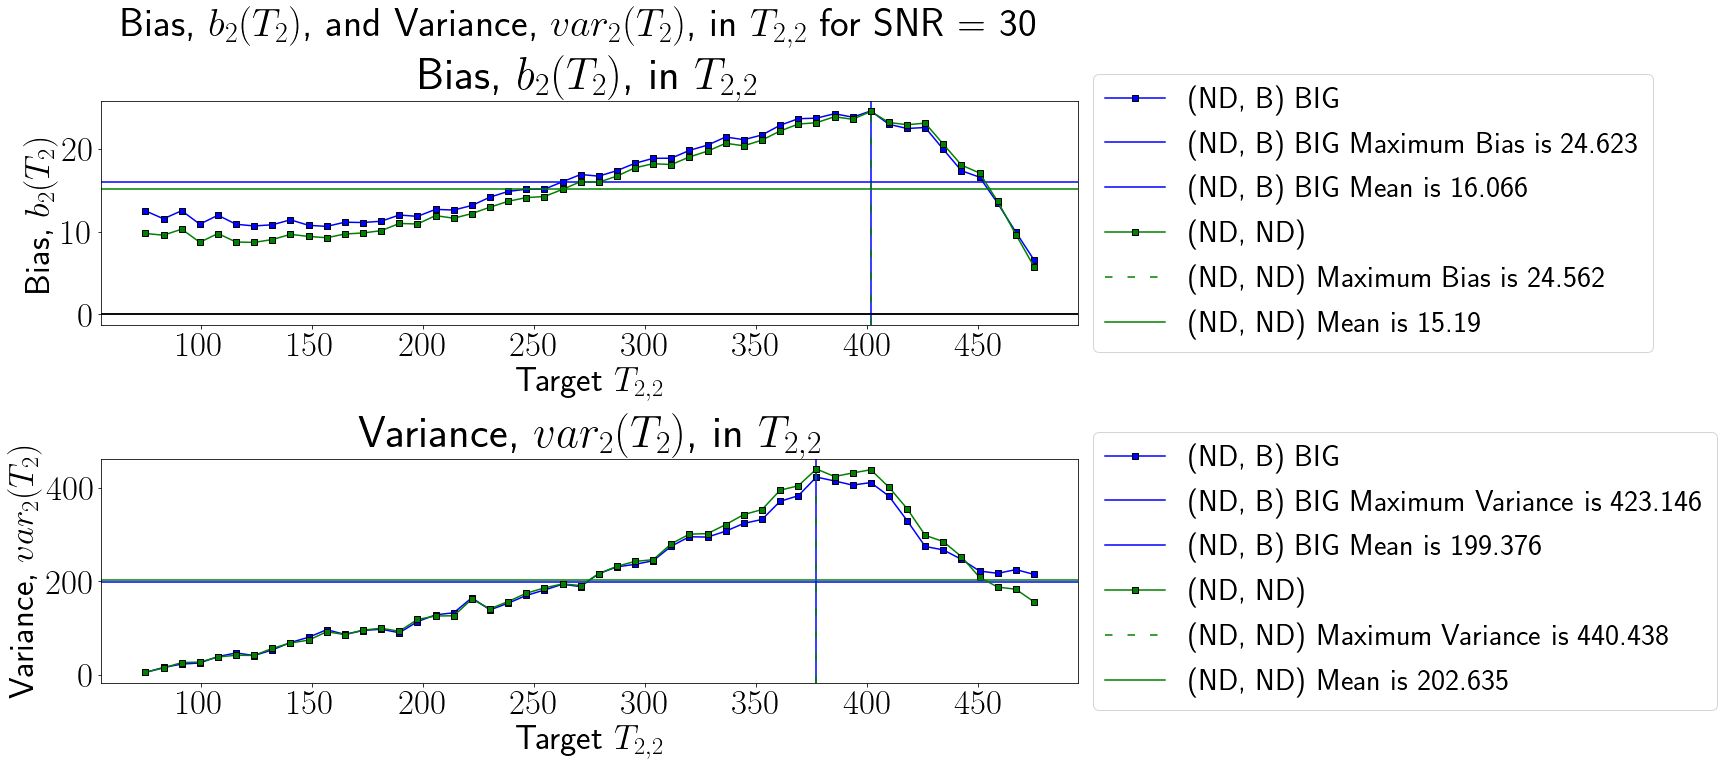

In [27]:
##### BIAS AND VARIANCE PLOTS #########
inx = 0

plt.clf()

bias_variance = plt.figure(figsize=(15,10))



bias_variance.suptitle(
    'Bias, $b_{2}(T_2)$, and Variance, $var_{2}(T_2)$, in $T_{2,2}$ for SNR = '+str(round(np.sqrt(SNR_A))), fontsize = 40)
ax1 = bias_variance.add_subplot(2, 1, 1)

ttl = ax1.title
ttl.set_position([.5, 1.05])

bias_variance.tight_layout(pad=1.5, w_pad=3, h_pad=6)

bias_variance.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

Multiplier = 0

#ax1.plot(unique_T21_targets_list[inx], (predicted_T21_means_rnlls_list[inx]-unique_T21_targets_list[inx].numpy()), marker='s', mec='k', label='rnlls')
#ax1.plot(unique_T21_targets_list[inx], (predicted_T21_means_nlls_list[inx]-unique_T21_targets_list[inx].numpy()), marker='s', mec='k', label='nlls')

for place in Compare_List:
    inx = (Multiplier*MethodLoop)+num           
    #inx = 4*x
    #print(inx)
    
    
    ax1.plot(unique_T22_targets_list[inx], np.abs((predicted_T22_means_ma_list[inx]-unique_T22_targets_list[inx].numpy())), marker='s', mec='k', label=Description_List[place], color = ColorList[place])
    ax1.axvline(x=unique_T22_targets_list[inx][(predicted_T22_means_ma_list[inx]-unique_T22_targets_list[inx].numpy()).tolist().index(max((predicted_T22_means_ma_list[inx]-unique_T22_targets_list[inx].numpy())))], label = Description_List[place] + ' Maximum Bias is ' + str(round(max((predicted_T22_means_ma_list[inx]-unique_T22_targets_list[inx].numpy())), 3)), color = ColorList[place], linestyle = linestyle_list[place])
    ax1.axhline(y=0, color='black')
    ax1.axhline(y=np.average((predicted_T22_means_ma_list[inx]-unique_T22_targets_list[inx].numpy())), label = Description_List[place] + ' Mean is ' + str(round(np.average(predicted_T22_means_ma_list[inx]-unique_T22_targets_list[inx].numpy()),3)), color = ColorList[place])
    
    Multiplier = Multiplier+1

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':30})    
ax2 = bias_variance.add_subplot(2, 1, 2)

Multiplier = 0

for place in Compare_List:
    inx = (Multiplier*MethodLoop)+num           
    #inx = 4*x

    ax2.plot(unique_T22_targets_list[inx], (predicted_T22_stdevs_ma_list[inx] ** 2), marker='s', mec='k', label=Description_List[place], color = ColorList[place])
    ax2.axvline(x=unique_T22_targets_list[inx][(predicted_T22_stdevs_ma_list[inx] ** 2).tolist().index(max((predicted_T22_stdevs_ma_list[inx] ** 2)))], label = Description_List[place] + ' Maximum Variance is ' + str(round(max((predicted_T22_stdevs_ma_list[inx] ** 2)), 3)), color = ColorList[place], linestyle = linestyle_list[place])
    ax2.axhline(y=np.average((predicted_T22_stdevs_ma_list[inx] ** 2)), label = Description_List[place] + ' Mean is ' + str(round(np.average(predicted_T22_stdevs_ma_list[inx] ** 2),3)), color = ColorList[place])
    Multiplier = Multiplier+1

#ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_rnlls_list[inx] ** 2)/new_every, marker='s', mec='k', label='rnlls')
#ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_nlls_list[inx] ** 2)/new_every, marker='s', mec='k', label='nlls')


ax1.set_ylabel('Bias, $b_{2}(T_2)$', size=35)
ax1.set_title('Bias, $b_{2}(T_2)$, in $T_{2,2}$', size=45)
ax1.set_xlabel('Target $T_{2,2}$', size=35)
ax1.tick_params(labelsize=35)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})

ax2.set_title('Variance, $var_{2}(T_2)$, in $T_{2,2}$', size=45)
ax2.set_xlabel('Target $T_{2,2}$', size=35)
ax2.set_ylabel('Variance, $var_{2}(T_2)$', size=35)
ax2.tick_params(labelsize=35)

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})

plt.savefig(FIG_PATH + 'fig_biaa_variance_T22_stdev_seperate.png', bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

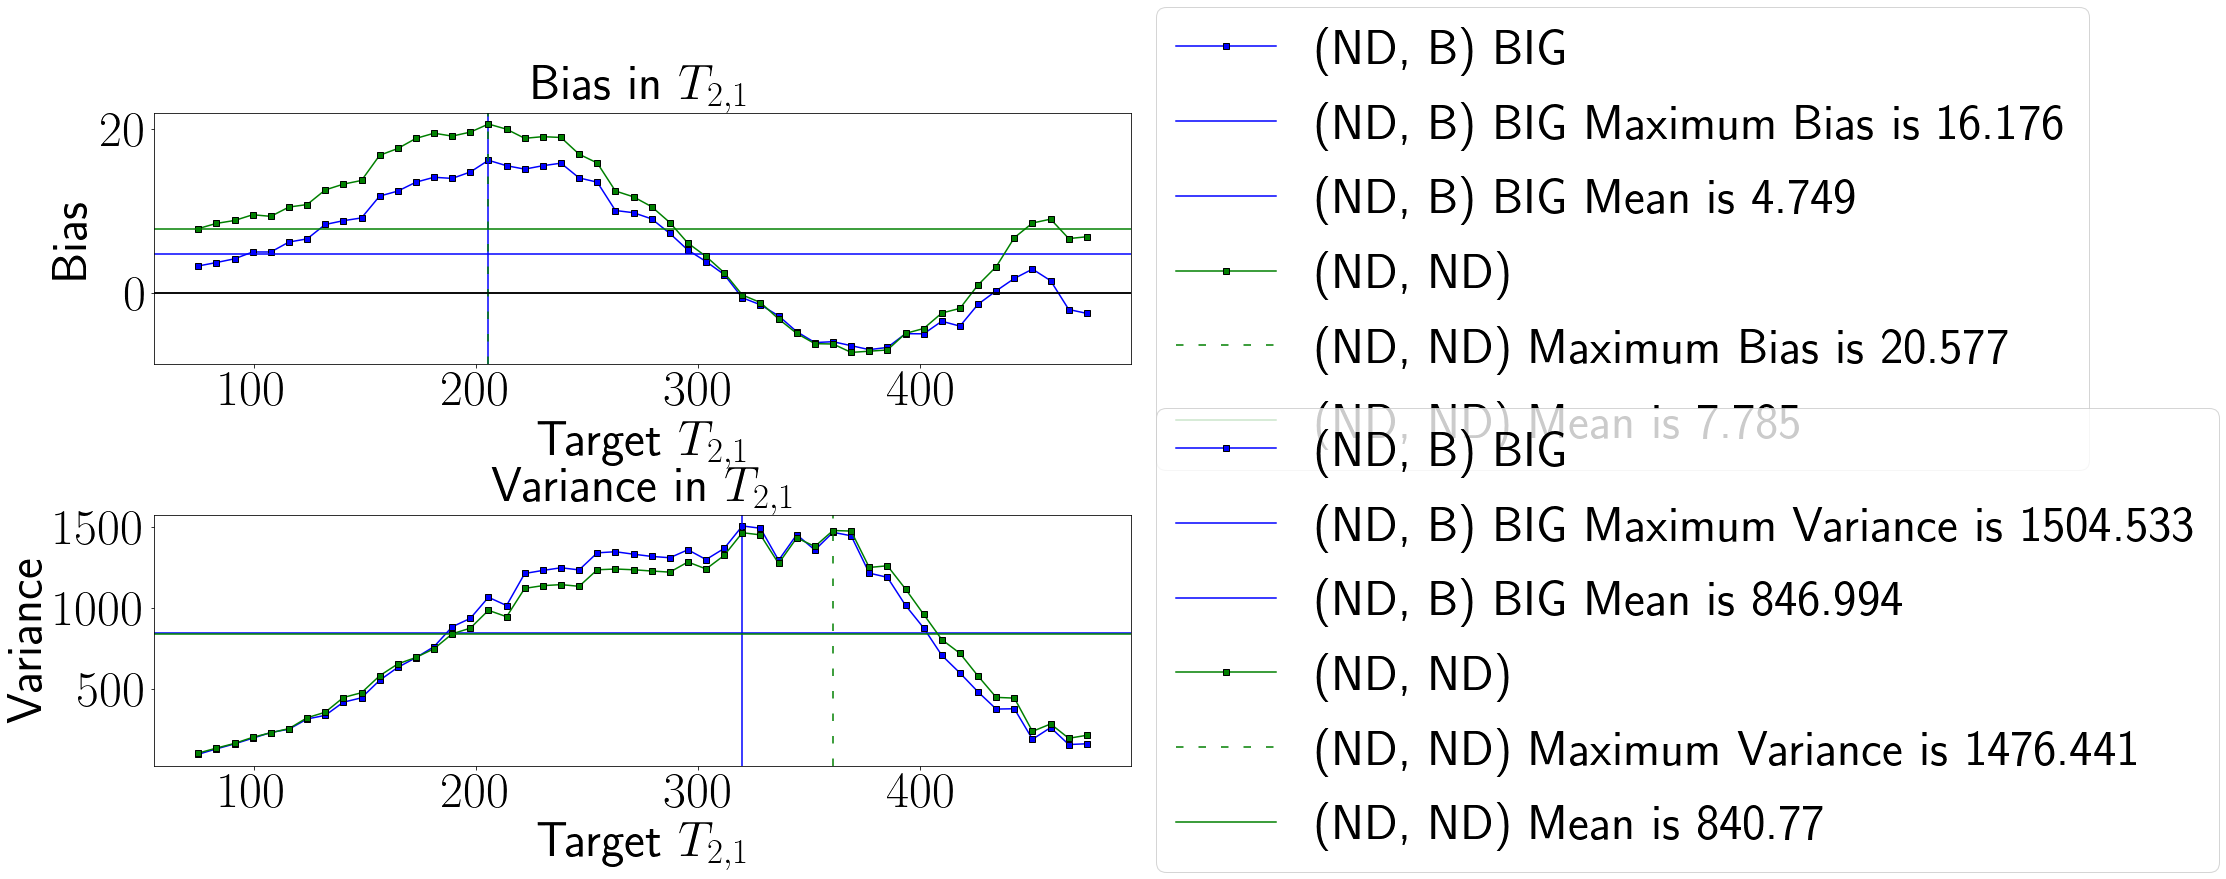

In [28]:
##### BIAS AND VARIANCE PLOTS #########
inx = 0

plt.clf()

bias_variance = plt.figure(figsize=(15,10))

numb = 50


ax1 = bias_variance.add_subplot(2, 1, 1)

ttl = ax1.title
ttl.set_position([.5, 1.05])

bias_variance.tight_layout(pad=1.5, w_pad=3, h_pad=6)

bias_variance.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

Multiplier = 0

#ax1.plot(unique_T21_targets_list[inx], (predicted_T21_means_rnlls_list[inx]-unique_T21_targets_list[inx].numpy()), marker='s', mec='k', label='rnlls')
#ax1.plot(unique_T21_targets_list[inx], (predicted_T21_means_nlls_list[inx]-unique_T21_targets_list[inx].numpy()), marker='s', mec='k', label='nlls')

for place in Compare_List:
    inx = (Multiplier*MethodLoop)+num           
    #inx = 4*x
    #print(inx)
    
    #BIAS
    ax1.plot(unique_T21_targets_list[inx], ((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())), marker='s', mec='k', label=Description_List[place], color = ColorList[place])
    
    
    ax1.axvline(x=unique_T21_targets_list[inx][(predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy()).tolist().index(max((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())))], label = Description_List[place] + ' Maximum Bias is ' + str(round(max((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())), 3)), color = ColorList[place], linestyle = linestyle_list[place])
    ax1.axhline(y=0, color='black')
    ax1.axhline(y=np.average((predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy())), label = Description_List[place] + ' Mean is ' + str(round(np.average(predicted_T21_means_ma_list[inx]-unique_T21_targets_list[inx].numpy()),3)), color = ColorList[place])
    
    Multiplier = Multiplier+1

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':numb})    
ax2 = bias_variance.add_subplot(2, 1, 2)

Multiplier = 0

for place in Compare_List:
    inx = (Multiplier*MethodLoop)+num           
    #inx = 4*x
    
    #VARIANCE
    ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_ma_list[inx] ** 2), marker='s', mec='k', label=Description_List[place], color = ColorList[place])
    
    
    ax2.axvline(x=unique_T21_targets_list[inx][(predicted_T21_stdevs_ma_list[inx] ** 2).tolist().index(max((predicted_T21_stdevs_ma_list[inx] ** 2)))], label = Description_List[place] + ' Maximum Variance is ' + str(round(max((predicted_T21_stdevs_ma_list[inx] ** 2)), 3)), color = ColorList[place], linestyle = linestyle_list[place])
    ax2.axhline(y=np.average((predicted_T21_stdevs_ma_list[inx] ** 2)), label = Description_List[place] + ' Mean is ' + str(round(np.average(predicted_T21_stdevs_ma_list[inx] ** 2),3)), color = ColorList[place])
    Multiplier = Multiplier+1

#ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_rnlls_list[inx] ** 2)/new_every, marker='s', mec='k', label='rnlls')
#ax2.plot(unique_T21_targets_list[inx], (predicted_T21_stdevs_nlls_list[inx] ** 2)/new_every, marker='s', mec='k', label='nlls')


ax1.set_ylabel('Bias', size=numb)
ax1.set_title('Bias in $T_{2,1}$', size=numb)
ax1.set_xlabel('Target $T_{2,1}$', size=numb)
ax1.tick_params(labelsize=numb)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': numb})

ax2.set_title('Variance in $T_{2,1}$', size=numb)
ax2.set_xlabel('Target $T_{2,1}$', size=numb)
ax2.set_ylabel('Variance', size=numb)
ax2.tick_params(labelsize=numb)

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': numb})

plt.savefig(FIG_PATH + 'fig_biaa_variance_T21_stdev_seperate.png', bbox_inches="tight")

/tmp/ipykernel_1521587/1693349096.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h1 = ax1.pcolormesh(unique_T21_targets_list[val], unique_T22_targets_list[val], out, cmap=cmap, vmin = vmin, vmax=vmax)


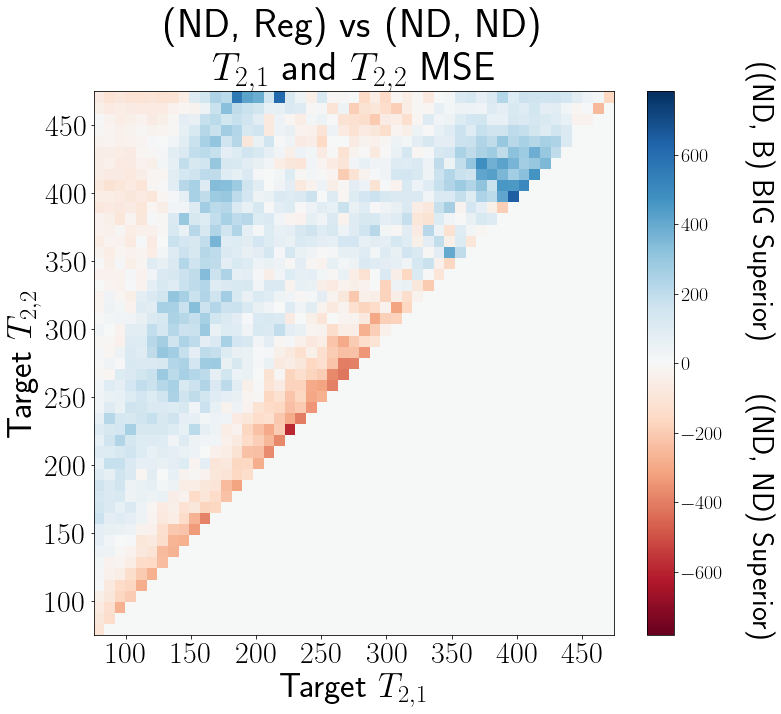

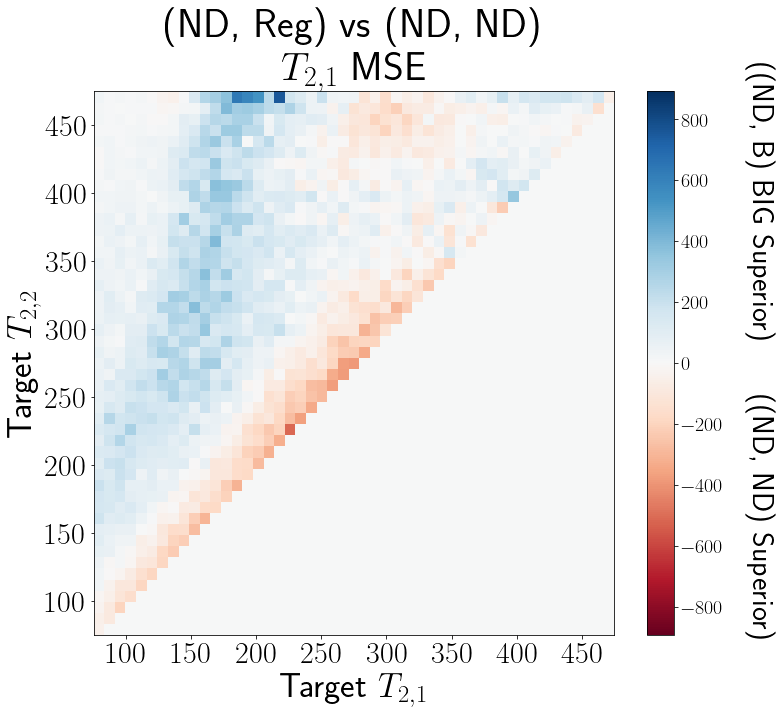

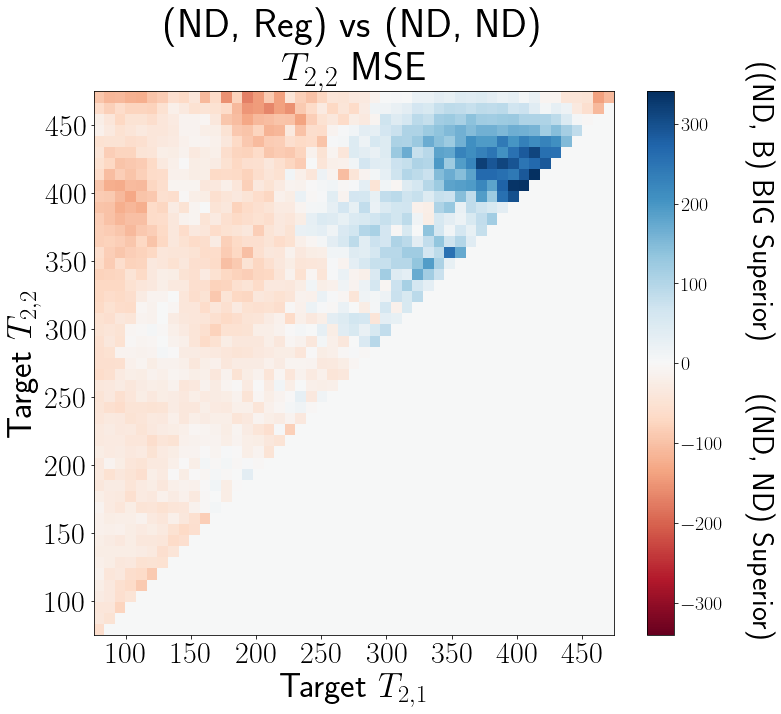

In [29]:
heat_plot3(2, ((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T,  title, -b, b, Even = 'Odd')
heat_plot3(2, ((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])).T,  title2, -b2, b2, Even = 'Odd')
heat_plot3(2, ((twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T,  title3, -b3, b3, Even = 'Odd')


list2 = [torch.min(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T), torch.max(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])+(twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T)]
list3 = [torch.min(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])).T), torch.max(((twoT21_error_means_ma_xy_list[val+5]-twoT21_error_means_ma_xy_list[val+1])).T)]
list4 = [torch.min(((twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T), torch.max(((twoT22_error_means_ma_xy_list[val+5]-twoT22_error_means_ma_xy_list[val+1])).T)]

#a = np.max(np.abs(list1))
b = np.max(np.abs(list2))
b2 = np.max(np.abs(list3))
b3 = np.max(np.abs(list4))

title = '(ND, Reg) vs (ND, ND)    \n $T_{2,1}$ and $T_{2,2}$ MSE'
title2 = '(ND, Reg) vs (ND, ND)    \n $T_{2,1}$ MSE'
title3 = '(ND, Reg) vs (ND, ND)    \n $T_{2,2}$ MSE'

In [30]:
val = 0

m1_bias_tensor_T21 = torch.empty(predicted_T21_means_ma_xy_list[val+1].shape)*0.0
counter = 0
for value in predicted_T21_means_ma_xy_list[val+1].T:
    counter2 = 0
    for elem in value:
        if elem == 0:
            counter2 = counter2+1
        else:
            m1_bias_tensor_T21[counter][counter2] = elem-unique_T21_targets_list[0][counter]
            counter2 = counter2+1
    counter = counter + 1
#display(bias_tensor_T21)

m1_bias_tensor_T22 = torch.empty(predicted_T22_means_ma_xy_list[val+1].shape)*0.0
counter = 0
for value in predicted_T22_means_ma_xy_list[val+1].T:
    counter2 = 0
    for elem in value:
        if elem == 0:
            counter2 = counter2+1
        else:
            m1_bias_tensor_T22[counter][counter2] = elem-unique_T22_targets_list[0][counter]
            counter2 = counter2+1
    counter = counter + 1
#display(bias_tensor_T22)

m1_total_bias_tensor = torch.abs(m1_bias_tensor_T21)+torch.abs(m1_bias_tensor_T22)
#display(total_bias_tensor)


#----

val = 0

m2_bias_tensor_T21 = torch.empty(predicted_T21_means_ma_xy_list[val+5].shape)*0.0
counter = 0
for value in predicted_T21_means_ma_xy_list[val+5].T:
    counter2 = 0
    for elem in value:
        if elem == 0:
            counter2 = counter2+1
        else:
            m2_bias_tensor_T21[counter][counter2] = elem-unique_T21_targets_list[0][counter]
            counter2 = counter2+1
    counter = counter + 1
#display(bias_tensor_T21)

m2_bias_tensor_T22 = torch.empty(predicted_T22_means_ma_xy_list[val+5].shape)*0.0
counter = 0
for value in predicted_T22_means_ma_xy_list[val+5].T:
    counter2 = 0
    for elem in value:
        if elem == 0:
            counter2 = counter2+1
        else:
            m2_bias_tensor_T22[counter][counter2] = elem-unique_T22_targets_list[0][counter]
            counter2 = counter2+1
    counter = counter + 1
#display(bias_tensor_T22)

m2_total_bias_tensor = torch.abs(m2_bias_tensor_T21)+torch.abs(m2_bias_tensor_T22)
#display(total_bias_tensor)


bias_tensor_T21 = torch.abs(m2_bias_tensor_T21) - torch.abs(m1_bias_tensor_T21)
bias_tensor_T22 = torch.abs(m2_bias_tensor_T22) - torch.abs(m1_bias_tensor_T22)
total_bias_tensor = m2_total_bias_tensor - m1_total_bias_tensor

In [31]:
np.min(np.asarray(bias_tensor_T21))

-11.592773

In [32]:
list2 = [torch.min((predicted_T21_stdevs_ma_xy_list[val+5]**2).T-(predicted_T21_stdevs_ma_xy_list[val+1]**2).T), torch.max((predicted_T21_stdevs_ma_xy_list[val+5]**2).T-(predicted_T21_stdevs_ma_xy_list[val+1]**2).T)]
list3 = [np.nanmin(np.asarray(bias_tensor_T21)), np.nanmax(np.asarray(bias_tensor_T21))]
list4 = [np.nanmin(np.asarray(bias_tensor_T22)), np.nanmax(np.asarray(bias_tensor_T22))]
list5 = [np.nanmin(np.asarray(total_bias_tensor)), np.nanmax(np.asarray(total_bias_tensor))]

b = np.max(np.abs(list2))
b1 = np.max(np.abs(list3))
b2 = np.max(np.abs(list4))
b3 = np.max(np.abs(list5))

b1, b3, b3

(11.592773, 16.442139, 16.442139)

/tmp/ipykernel_1521587/1693349096.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h1 = ax1.pcolormesh(unique_T21_targets_list[val], unique_T22_targets_list[val], out, cmap=cmap, vmin = vmin, vmax=vmax)


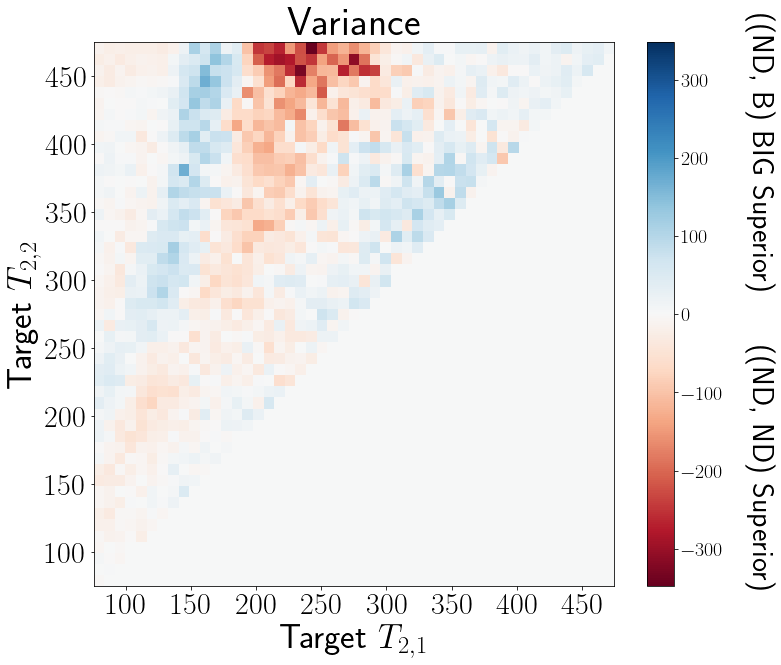

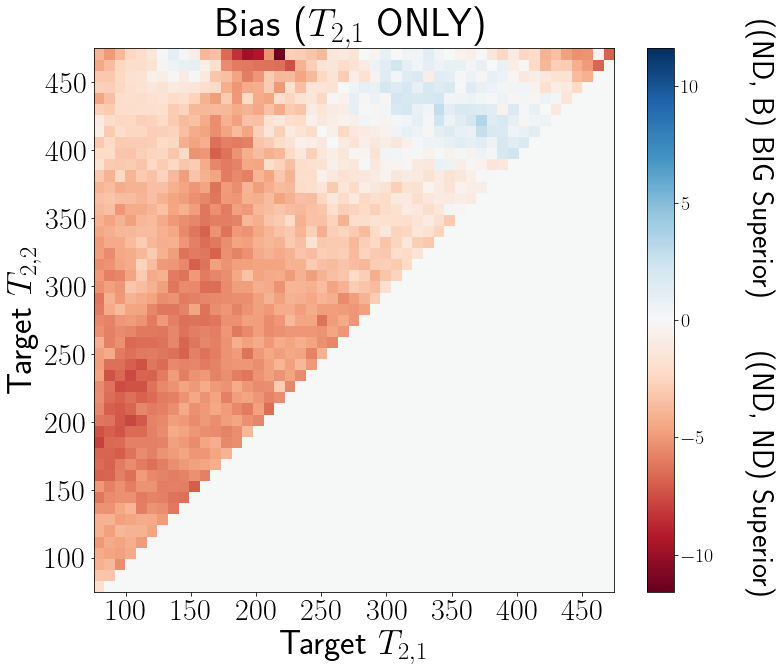

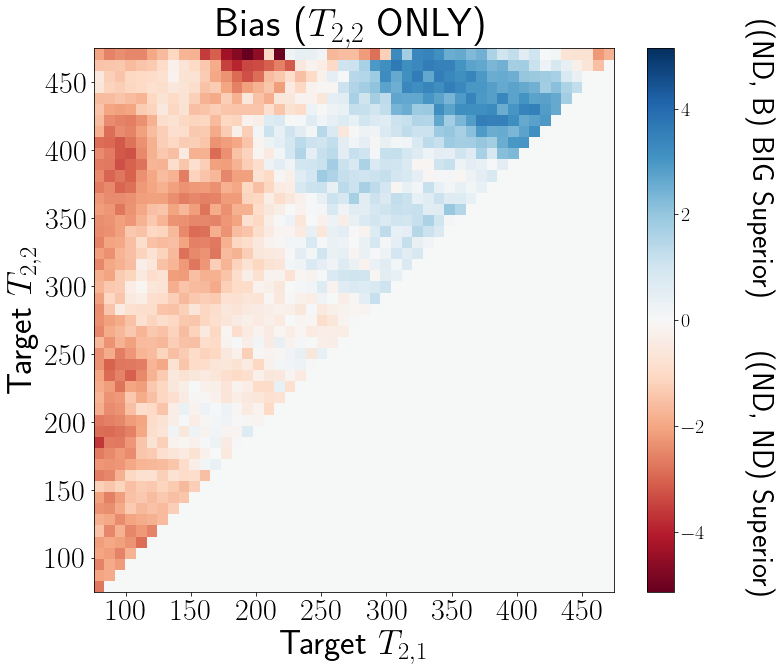

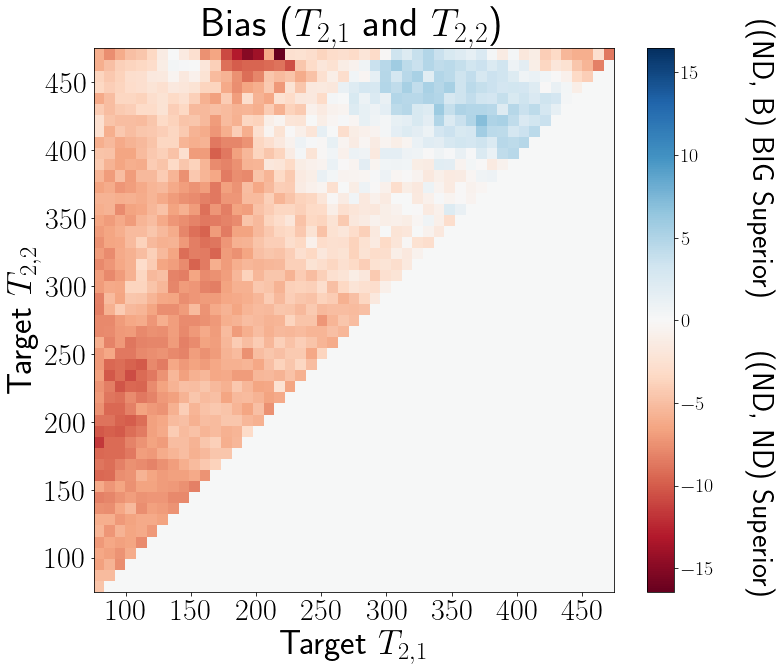

In [33]:




val = 0
heat_plot3(2, (predicted_T21_stdevs_ma_xy_list[val+5]**2).T-(predicted_T21_stdevs_ma_xy_list[val+1]**2).T,  'Variance', vmin = -b, vmax = b)


heat_plot3(2, bias_tensor_T21,  'Bias ($T_{2,1}$ ONLY)', vmin = -b1, vmax = b1)
heat_plot3(2, bias_tensor_T22,  'Bias ($T_{2,2}$ ONLY)', vmin = -b2, vmax = b2)
heat_plot3(2, total_bias_tensor,  'Bias ($T_{2,1}$ and $T_{2,2}$)', vmin = -b3, vmax = b3)


In [34]:
var2 = predicted_T21_stdevs_ma_xy_list[val+5]**2
var1 = predicted_T21_stdevs_ma_xy_list[val+1]**2
bias2 = m2_total_bias_tensor
bias1 = m1_total_bias_tensor

newMSE = (var2+bias2**2)-(var1+bias1**2)

/tmp/ipykernel_1521587/1693349096.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h1 = ax1.pcolormesh(unique_T21_targets_list[val], unique_T22_targets_list[val], out, cmap=cmap, vmin = vmin, vmax=vmax)


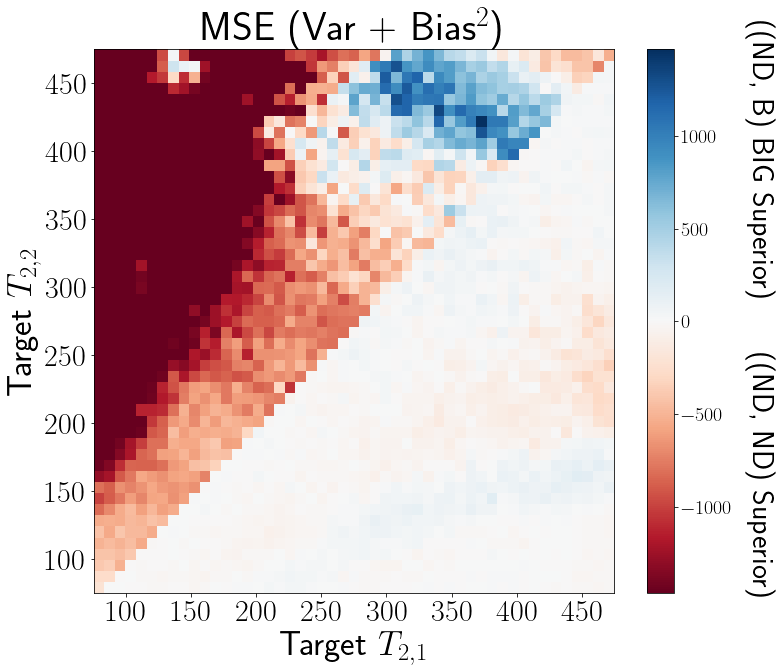

In [35]:
bound = np.nanmax([np.nanmin(newMSE), np.nanmax(newMSE)])


heat_plot3(2, newMSE,  'MSE (Var + Bias$^{2}$)', vmin = -bound, vmax = bound)
